In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [2]:
dataset_name = "W15_only"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (495, 13)


In [5]:
from cycler import cycler
def nice_bar_plot(ser1, ser2, normalize = 'columns', sort_labels=False, output_folder = BES_output_folder,
                  text_width=8, text_fontsize=14, min_sample_size=100, title=None, drop_insig=True, fuckErrors=True,
                  mask=1, title_fontsize=14, color=None, label=None, char_limit=40):
    var1 = ser1.name
    var2 = ser2.name
    
    mask = ser1.notnull() & ser2.notnull() & mask
    ids = ser1[mask].index
    ser1 = ser1[mask]
    ser2 = ser2[mask]
#     ct = pd.crosstab( ser1, ser2,
#                       values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(ids), aggfunc=sum, normalize=normalize)*100    
    if sort_labels:
        sorted_labels = list(ser2.value_counts().index)
    else:
        sorted_labels = list(ser2.cat.categories)
           

    unweighted = pd.crosstab( ser1, ser2 )
    errors = 100 * np.sqrt(unweighted)/unweighted     

    labels_by_sample_size = {unweighted.sum().values[x]:sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))}    
    labels_by_sample_size = {sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")":unweighted.sum().values[x] for x in range(0,len(sorted_labels))}    
    labels_restricted = [x for x in labels_by_sample_size.keys() if labels_by_sample_size[x] > min_sample_size] 
#     return labels_by_sample_size, labels_restricted
    if drop_insig:
        rubbish_entries = ct<errors
        ct[rubbish_entries]=np.nan
        errors[rubbish_entries]=np.nan
#     return(sorted_labels, errors, labels_by_sample_size)
    all_nan_rows = ~errors.isnull().any(axis=1)
    errors.columns = list( labels_by_sample_size.keys() )
   
    ct.columns = list( labels_by_sample_size.keys() )
    ct = ct.loc[all_nan_rows, labels_restricted]
#     return errors, labels_restricted
    errors = errors.loc[all_nan_rows, labels_restricted]
#     errors=errors.T
#     return errors
#     return errors, ct
    treatment = var2 +" by " + var1
    output_subfolder = create_subdir(output_folder, treatment)
    import textwrap 

    wrapper = textwrap.TextWrapper(width=text_width) 

    stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    err_stacked = errors.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

#     a = [np.ones(16),np.ones(16)]
#     a = errors.values
#     return a
#     iter(a)    
    
    stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )
    stacked[var1].cat.set_categories(stacked[var1].cat.categories[all_nan_rows],inplace=True)
#     return stacked
#     return stacked['%'].shape,err_stacked["%"].values.reshape(len(stacked),1).shape
    if fuckErrors:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted);
    else:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted,
                    yerr = errors.values);        
                    # err_stacked["%"].values );
# .reshape(len(stacked),1)

#     hatch_cycle = cycler(hatch=['/', '*', '-','+','x','\\','o' '|'])
    # Define some hatches
#     hatches = ['-', '+', 'x', '\\', '*', 'o']
    hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
    # Loop over the bars
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(next(hatch_cycle))

    if title is None:
        title = var2 +" by " + var1
    plt.title(title, fontsize=title_fontsize)
    sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))] 
    ax.set_xticklabels([ wrapper.fill(text=x) for x in labels_restricted], rotation=0, fontsize=text_fontsize);

    ax.annotate(dataset_citation, (0,0), (0, -140),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + clean_filename(title, char_limit = char_limit) + ".png"
    fig.savefig( fname, bbox_inches='tight' )    

In [6]:
def get_all_weights(ids, specific_wave = None):

    if specific_wave is None:
        wts = BES_Panel.loc[ids, list(num_to_weight.values())]
    else:
        wts = BES_Panel.loc[ids, specific_wave]
    # wts.hist(bins=100,figsize=(16,12));

    wts = wts/wts.mean()
    # wts.mean(axis=1).hist(bins=100,figsize=(16,12));
    # # wts = wts/wts.mean(axis=1)
    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts
# wts

In [7]:
def sort_by_wave(lst):
    dict_by_wave = {int(x.split("W")[-1]):x for x in lst}
    return [dict_by_wave[x] for x in sorted(dict_by_wave.keys())]
    
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

IndexError: list index out of range

In [ ]:
max_wave = int(re.match("W(\d+)_",dataset_name).groups()[0])
num_to_wave = {x:"W"+str(x) for x in range(1,max_wave+1)}
{ y:[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,max_wave+1) }

In [29]:
search(BES_reduced_with_na,"al_scale")

al_scaleW14__Authoritarian    31629
dtype: int64

In [30]:
BES_reduced_with_na[["lr_scaleW14__Right","al_scaleW14__Authoritarian"]].corr()


lr_scaleW14__Right  al_scaleW14__Authoritarian
lr_scaleW14__Right                    1.000000                    0.051349
al_scaleW14__Authoritarian            0.051349                    1.000000

In [9]:
num_to_weight = { 15:"wt_new_" }

In [ ]:
# Needed for Factor Analysis
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
def display_corr(df, name, corr_type, top_num = 20, round_places = 2,
                 correlation_text = "r", p_value_text = "p", sample_size_text = "N",
                 text_wrap_length=50):
#     df.index = [x[0:60] for x in df.index]
    df.index =  [trim_strings(x) for x in df.index.str.wrap(width = text_wrap_length)]
    
    df[correlation_text] = df[correlation_text].round(round_places)
    
    df1 = df.sort_values(by=correlation_text, ascending=False)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    df2 = df.sort_values(by=correlation_text)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    
    df1[p_value_text]     = df1[p_value_text].apply(lambda x: "{0:0.2f}".format(x))
    df2[p_value_text]     = df2[p_value_text].apply(lambda x: "{0:0.2f}".format(x))

    df1_caption = "Top "+str(top_num)+ " positive "+"("+corr_type+")"+" correlations for "+name
    df2_caption = "Top "+str(top_num)+ " negative "+"("+corr_type+")"+" correlations for "+name

    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_().replace("\\n","<br />")+df2_styler._repr_html_().replace("\\n","<br />"), raw=True)


def make_corr_summary(input_df, name,  corr_type = "spearman", pattern=None, sample_size_text = "N", correlation_text = "r",
                      abs_correlation_text = "abs_r", p_value_text = "p",
                      min_p_value = 0.01, min_variance = 0.0, min_sample_size = 500):

    if pattern is None:
        pattern=name
    df1 = input_df.copy()
    focal_var = df1[name]
    focal_mask = focal_var.notnull()


    pattern_list = [x for x in df1.columns if re.search(pattern,x)]

    variances = df1[focal_mask].var()
    low_var_list = list(variances[variances<min_variance].index)
    sample_sizes = df1[focal_mask].notnull().sum()
    low_sample_size_list = list(sample_sizes[sample_sizes<min_sample_size].index)

    drop_list = pattern_list+low_var_list+low_sample_size_list
    df1.drop(drop_list,axis=1,inplace=True)

    if corr_type == "pearson":
        df = df1.apply(lambda x: corr_simple_pearsonr(x,focal_var)).apply(pd.Series)
    elif corr_type == "spearman":
        df = df1.apply(lambda x: corr_simple_spearmanr(x,focal_var)).apply(pd.Series)

    if len(df.columns)!=3:
        df=df.T
    df.columns = [correlation_text,p_value_text,sample_size_text]
 
    df[sample_size_text] = df[sample_size_text].astype('int')
    df[abs_correlation_text] = df[correlation_text].abs()

    zero_var_other_way_around_list = list(df[df[correlation_text].isnull()].index)
    df.dropna(inplace=True)

    insignificant_list = df[df[p_value_text]>min_p_value].index
    df.drop(insignificant_list,inplace=True)

    df.sort_values(by=abs_correlation_text,ascending=False,inplace=True)


    stub_dict = {}
    drop_list = []
    # drop repeated references to same variable in different waves???
    # so, what about different categories??? eg. blahWX_subcat
    # how about, just replace wave match as "X"
    # create a dictionary keyed on the top corr variable with all the drops inside
    for ind in df.index:
        waveless = remove_wave(ind)
        if waveless in stub_dict.keys():
            drop_list.append(ind)
            stub_dict[waveless].append(ind)
        else:
            stub_dict[waveless] = [ind]
    df.drop(drop_list,inplace=True)
    return df, corr_type    
    

How would you vote in another referendum?
Warning, filename truncated because it was over 50. Filenames may no longer be unique


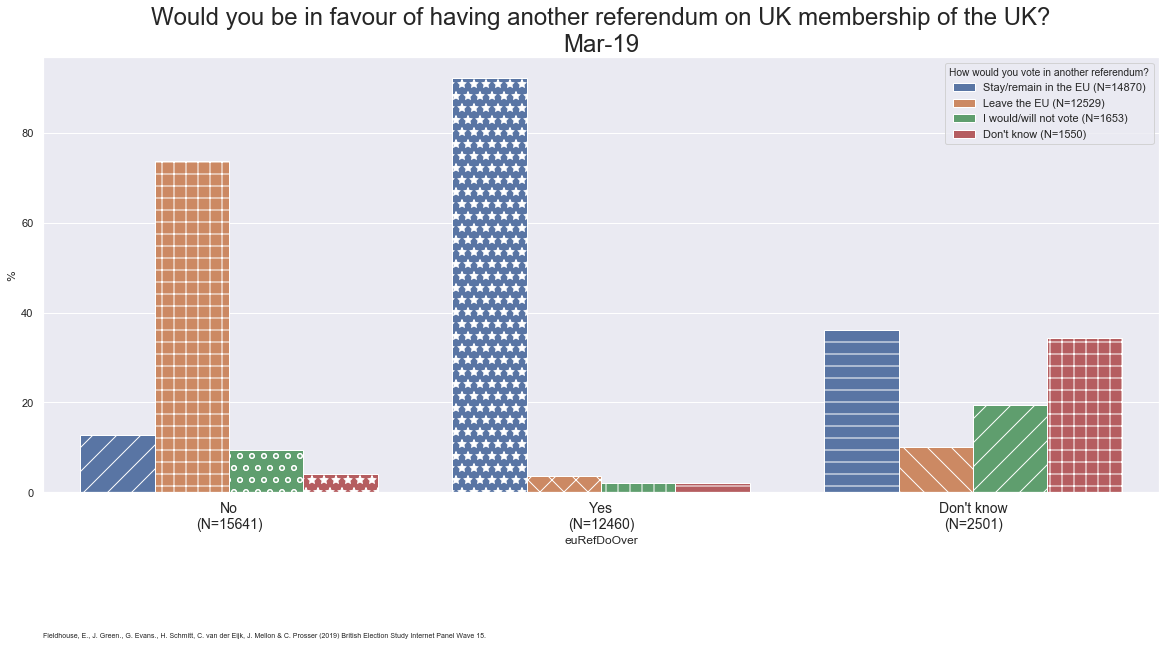

In [26]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 15

var2 ="euRefDoOver"
var1 ="euRefVote"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]

df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
df1.name = "How would you vote in another referendum?"
print(df1.name)
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Would you be in favour of having another referendum on UK membership of the UK?"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Wall time: 1min 51s


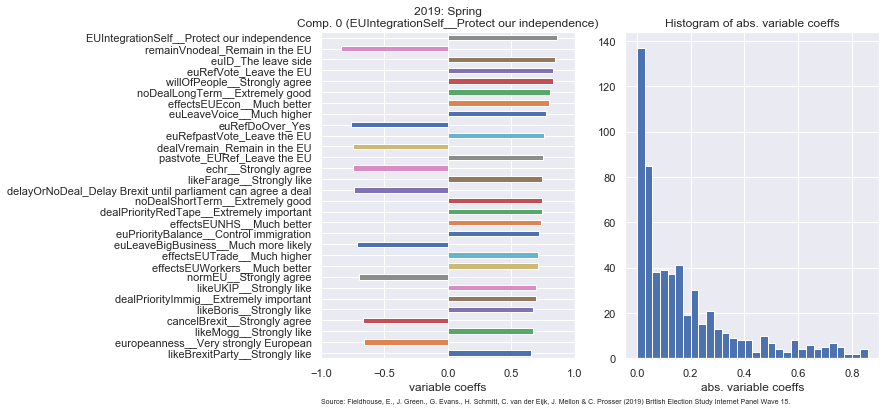

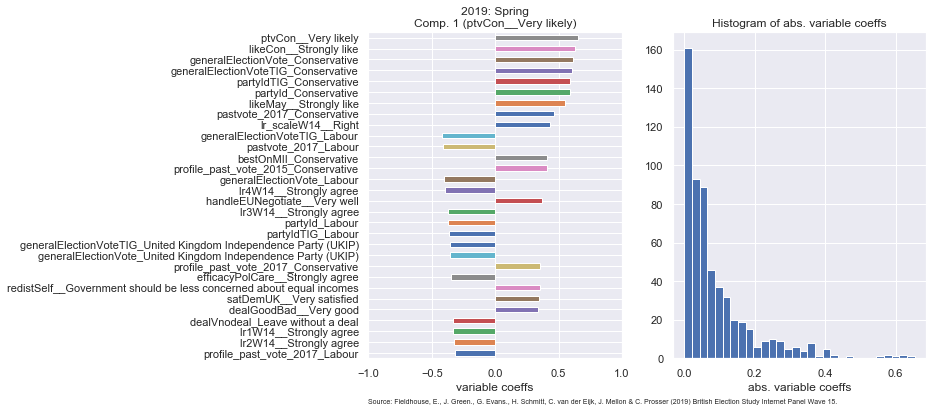

In [12]:
%%time

df = BES_reduced_with_na.copy()

df = df.fillna(df.mean())




output_subfolder = BES_output_folder+os.sep + "racism_fusion" + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    

# standardise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df.columns,
                             index   = df.index      )



n_components = BES_std.shape[1]
n_components = 2
alpha = 18
decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
# decomp = SparsePCA(n_components = n_components, alpha = alpha)
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method


# display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df.columns, BES_decomp, manifest=manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 10, show_histogram = True)

In [43]:
search(BES_Panel,"wt_(new|full)")

wt_new_    30842
dtype: int64

In [44]:
num_to_weight = {15:"wt_new_"}

In [26]:
pattern = "partyIdStrengthTIG"
name = "partyIdStrengthTIG__3.0"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Top 20 positive (spearman) correlations for partyIdStrengthTIG__3.0 
 
 
 r 
 p 
 N 
 
 
 partyIdStrength__Not very strong 
 0.74 
 0.00 
 22419 
 
 euIDStrength__Not very strong 
 0.28 
 0.00 
 21611 
 
 bestOnMII_No party is best able to handle this[...] 
 0.26 
 0.00 
 19964 
 
 partyIdTIG_No - None 
 0.25 
 0.00 
 22791 
 
 partyId_No - none 
 0.24 
 0.00 
 22377 
 
 efficacyNoMatter__Strongly agree 
 0.21 
 0.00 
 22912 
 
 ptvLD__Very likely 
 0.19 
 0.00 
 22363 
 
 efficacyNotUnderstand__Strongly agree 
 0.16 
 0.00 
 23071 
 
 approveUKGovt__Strongly approve 
 0.16 
 0.00 
 3859 
 
 partydiffconlab__There is not much difference[...] 
 0.15 
 0.00 
 22656 
 
 partyIdSqueeze_Conservative 
 0.15 
 0.00 
 2381 
 
 partyIdSqueezeTIG_Liberal Democrat 
 0.15 
 0.00 
 2193 
 
 partyIdSqueezeTIG_Conservative 
 0.15 
 0.00 
 2193 
 
 likeLD__Strongly like 
 0.14 
 0.00 
 22359 
 
 efficacyTooMuchEffort__Strongly agree 
 0.14 
 0.00 
 22256 
 
 likeTIG__Strongly like 
 0.14 
 0.00 
 16948 
 
 generalElectionVote_Liberal Democrat 
 0.13 
 0.00 
 17615 
 
 generalElectionVoteTIG_Liberal Democrat 
 0.13 
 0.00 
 18249 
 
 likeUmunna__Strongly like 
 0.13 
 0.00 
 16262 
 
 ptvTIG__Very likely 
 0.12 
 0.00 
 18675 
 
 
 Top 20 negative (spearman) correlations for partyIdStrengthTIG__3.0 
 
 
 r 
 p 
 N 
 
 
 pidPraiseGood__Strongly agree 
 -0.4 
 0.00 
 20131 
 
 pidCommonParty__Strongly agree 
 -0.39 
 0.00 
 17767 
 
 pidConnected__Strongly agree 
 -0.39 
 0.00 
 20223 
 
 pidMyParty__Strongly agree 
 -0.39 
 0.00 
 21572 
 
 pidWeThey__Strongly agree 
 -0.37 
 0.00 
 21181 
 
 pidCriticiseParty__Strongly agree 
 -0.35 
 0.00 
 21835 
 
 pidRuinDay__Strongly agree 
 -0.3 
 0.00 
 21874 
 
 polAttention__Pay a great deal of attention 
 -0.27 
 0.00 
 23250 
 
 euID7__Strongly agree 
 -0.25 
 0.00 
 18273 
 
 partyIdSqueezeTIG_United Kingdom Independence[...] 
 -0.25 
 0.00 
 2193 
 
 euID6__Strongly agree 
 -0.25 
 0.00 
 18560 
 
 efficacyUnderstand__Strongly agree 
 -0.24 
 0.00 
 22918 
 
 partyIdSqueeze_United Kingdom Independence Party[...] 
 -0.23 
 0.00 
 2381 
 
 pidInterestedOthers__Strongly agree 
 -0.21 
 0.00 
 21691 
 
 partyMember__Yes, I am a member of a party 
 -0.21 
 0.00 
 23129 
 
 euID4__Strongly agree 
 -0.19 
 0.00 
 17950 
 
 bestOnMII_Labour 
 -0.18 
 0.00 
 19964 
 
 euID1__Strongly agree 
 -0.18 
 0.00 
 19420 
 
 euID3__Strongly agree 
 -0.16 
 0.00 
 20426 
 
 turnoutUKGeneral__Very likely that I will vote 
 -0.16 
 0.00 
 22697

In [54]:
search(BES_reduced_with_na,"EUIntegrationCorbyn")

EUIntegrationCorbyn__Protect our independence    23574
dtype: int64

In [28]:
pattern = "dealVnodeal_Leave without a deal"
name = "dealVnodeal_Leave without a deal"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for dealVnodeal_Leave without a deal 
 
 
 r 
 p 
 N 
 
 
 noDealLongTerm__Extremely good 
 0.62 
 0.00 
 18442 
 
 euID_The leave side 
 0.62 
 0.00 
 18924 
 
 EUIntegrationSelf__Protect our independence 
 0.61 
 0.00 
 19784 
 
 euRefVote_Leave the EU 
 0.61 
 0.00 
 19057 
 
 noDealShortTerm__Extremely good 
 0.58 
 0.00 
 18813 
 
 pastvote_EURef_Leave the EU 
 0.58 
 0.00 
 18827 
 
 euRefpastVote_Leave the EU 
 0.58 
 0.00 
 18631 
 
 profile_eurefvote_Leave the EU 
 0.57 
 0.00 
 15579 
 
 willOfPeople__Strongly agree 
 0.56 
 0.00 
 19870 
 
 likeBrexitParty__Strongly like 
 0.53 
 0.00 
 14162 
 
 likeFarage__Strongly like 
 0.52 
 0.00 
 19716 
 
 effectsEUEcon__Much better 
 0.51 
 0.00 
 19287 
 
 euPriorityBalance__Control immigration 
 0.5 
 0.00 
 18733 
 
 likeUKIP__Strongly like 
 0.49 
 0.00 
 19533 
 
 euLeaveVoice__Much higher 
 0.49 
 0.00 
 19562 
 
 dealPriorityRedTape__Extremely important 
 0.48 
 0.00 
 19508 
 
 ptvBrexitParty__Very likely 
 0.47 
 0.00 
 16726 
 
 ptvUKIP__Very likely 
 0.47 
 0.00 
 19367 
 
 socialIdentityGlobalLeave__A great deal in common 
 0.47 
 0.00 
 3933 
 
 effectsEUTrade__Much higher 
 0.46 
 0.00 
 19093 
 
 
 Top 20 negative (spearman) correlations for dealVnodeal_Leave without a deal 
 
 
 r 
 p 
 N 
 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.67 
 0.00 
 19140 
 
 remainVnodeal_Remain in the EU 
 -0.64 
 0.00 
 19498 
 
 noDealEmotions_5_Yes 
 -0.5 
 0.00 
 4417 
 
 euRefDoOver_Yes 
 -0.5 
 0.00 
 19330 
 
 normEU__Strongly agree 
 -0.49 
 0.00 
 18781 
 
 euLeaveBigBusiness__Much more likely 
 -0.49 
 0.00 
 18603 
 
 cancelBrexit__Strongly agree 
 -0.48 
 0.00 
 19309 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.46 
 0.00 
 3922 
 
 noDealEmotions_1_Yes 
 -0.45 
 0.00 
 4417 
 
 europeanness__Very strongly European 
 -0.45 
 0.00 
 19831 
 
 echr__Strongly agree 
 -0.45 
 0.00 
 19312 
 
 dealVremain_Remain in the EU 
 -0.44 
 0.00 
 16573 
 
 noDealEmotions_7_Yes 
 -0.43 
 0.00 
 4417 
 
 immigSelf__Allow many more 
 -0.43 
 0.00 
 19148 
 
 likeLD__Strongly like 
 -0.42 
 0.00 
 19218 
 
 immigCultural__Enriches cultural life 
 -0.42 
 0.00 
 19643 
 
 immigEcon__Good for economy 
 -0.41 
 0.00 
 19554 
 
 ptvLD__Very likely 
 -0.41 
 0.00 
 19039 
 
 likeSoubry__Strongly like 
 -0.41 
 0.00 
 13447 
 
 socialDistRemain__Very happy 
 -0.4 
 0.00 
 4235

In [30]:
pattern = "dealVremain_Remain in the EU"
name = "dealVremain_Remain in the EU"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for dealVremain_Remain in the EU 
 
 
 r 
 p 
 N 
 
 
 remainVnodeal_Remain in the EU 
 0.9 
 0.00 
 22692 
 
 euRefDoOver_Yes 
 0.8 
 0.00 
 22220 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.74 
 0.00 
 21176 
 
 cancelBrexit__Strongly agree 
 0.68 
 0.00 
 22113 
 
 euLeaveBigBusiness__Much more likely 
 0.66 
 0.00 
 21744 
 
 echr__Strongly agree 
 0.64 
 0.00 
 21904 
 
 normEU__Strongly agree 
 0.64 
 0.00 
 21694 
 
 europeanness__Very strongly European 
 0.58 
 0.00 
 22863 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.58 
 0.00 
 4434 
 
 leaveImpactBritain__A very large impact 
 0.55 
 0.00 
 22334 
 
 immigSelf__Allow many more 
 0.55 
 0.00 
 21854 
 
 effectsEUUnemployment__Much higher 
 0.52 
 0.00 
 21927 
 
 immigCultural__Enriches cultural life 
 0.52 
 0.00 
 22586 
 
 noDealEmotions_1_Yes 
 0.51 
 0.00 
 4994 
 
 immigEcon__Good for economy 
 0.51 
 0.00 
 22526 
 
 socialDistRemain__Very happy 
 0.5 
 0.00 
 4772 
 
 euLeaveScotIndep__Much more likely 
 0.47 
 0.00 
 19837 
 
 ptvLab__Very likely 
 0.47 
 0.00 
 22134 
 
 likeLab__Strongly like 
 0.46 
 0.00 
 22795 
 
 leaveImpactSelf__A very large impact 
 0.45 
 0.00 
 21490 
 
 
 Top 20 negative (spearman) correlations for dealVremain_Remain in the EU 
 
 
 r 
 p 
 N 
 
 
 euRefVote_Leave the EU 
 -0.91 
 0.00 
 22535 
 
 euID_The leave side 
 -0.88 
 0.00 
 21969 
 
 EUIntegrationSelf__Protect our independence 
 -0.78 
 0.00 
 22707 
 
 willOfPeople__Strongly agree 
 -0.78 
 0.00 
 22835 
 
 euRefpastVote_Leave the EU 
 -0.75 
 0.00 
 21364 
 
 pastvote_EURef_Leave the EU 
 -0.74 
 0.00 
 21567 
 
 profile_eurefvote_Leave the EU 
 -0.73 
 0.00 
 17621 
 
 noDealLongTerm__Extremely good 
 -0.71 
 0.00 
 20829 
 
 effectsEUEcon__Much better 
 -0.71 
 0.00 
 22195 
 
 noDealShortTerm__Extremely good 
 -0.69 
 0.00 
 21464 
 
 euLeaveVoice__Much higher 
 -0.68 
 0.00 
 22460 
 
 effectsEUNHS__Much better 
 -0.65 
 0.00 
 22142 
 
 dealPriorityRedTape__Extremely important 
 -0.63 
 0.00 
 21949 
 
 likeBrexitParty__Strongly like 
 -0.63 
 0.00 
 16676 
 
 effectsEUTrade__Much higher 
 -0.63 
 0.00 
 21743 
 
 euPriorityBalance__Control immigration 
 -0.62 
 0.00 
 21161 
 
 socialIdentityGlobalLeave__A great deal in common 
 -0.61 
 0.00 
 4435 
 
 likeFarage__Strongly like 
 -0.61 
 0.00 
 22722 
 
 expectAccess_Yes 
 -0.61 
 0.00 
 19157 
 
 effectsEUWorkers__Much better 
 -0.61 
 0.00 
 22118

In [33]:

pattern = "remainVnodeal_Remain in the EU"
name = "remainVnodeal_Remain in the EU"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for remainVnodeal_Remain in the EU 
 
 
 r 
 p 
 N 
 
 
 dealVremain_Remain in the EU 
 0.9 
 0.00 
 22692 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.85 
 0.00 
 24414 
 
 euRefDoOver_Yes 
 0.82 
 0.00 
 25436 
 
 cancelBrexit__Strongly agree 
 0.72 
 0.00 
 25264 
 
 euLeaveBigBusiness__Much more likely 
 0.7 
 0.00 
 24585 
 
 normEU__Strongly agree 
 0.69 
 0.00 
 24757 
 
 echr__Strongly agree 
 0.66 
 0.00 
 25064 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.63 
 0.00 
 5047 
 
 europeanness__Very strongly European 
 0.62 
 0.00 
 26103 
 
 immigSelf__Allow many more 
 0.58 
 0.00 
 24950 
 
 immigCultural__Enriches cultural life 
 0.56 
 0.00 
 25760 
 
 leaveImpactBritain__A very large impact 
 0.56 
 0.00 
 25406 
 
 noDealEmotions_1_Yes 
 0.55 
 0.00 
 5707 
 
 immigEcon__Good for economy 
 0.54 
 0.00 
 25678 
 
 effectsEUUnemployment__Much higher 
 0.54 
 0.00 
 24997 
 
 noDealEmotions_5_Yes 
 0.54 
 0.00 
 5707 
 
 socialDistRemain__Very happy 
 0.53 
 0.00 
 5498 
 
 noDealEmotions_7_Yes 
 0.5 
 0.00 
 5707 
 
 euLeaveScotIndep__Much more likely 
 0.49 
 0.00 
 22341 
 
 EUIntegrationCorbyn__Protect our independence 
 0.48 
 0.00 
 21609 
 
 
 Top 20 negative (spearman) correlations for remainVnodeal_Remain in the EU 
 
 
 r 
 p 
 N 
 
 
 euRefVote_Leave the EU 
 -0.95 
 0.00 
 25579 
 
 euID_The leave side 
 -0.93 
 0.00 
 25073 
 
 EUIntegrationSelf__Protect our independence 
 -0.83 
 0.00 
 25900 
 
 euRefpastVote_Leave the EU 
 -0.82 
 0.00 
 24411 
 
 willOfPeople__Strongly agree 
 -0.82 
 0.00 
 26087 
 
 pastvote_EURef_Leave the EU 
 -0.8 
 0.00 
 24694 
 
 profile_eurefvote_Leave the EU 
 -0.79 
 0.00 
 20243 
 
 noDealLongTerm__Extremely good 
 -0.78 
 0.00 
 23875 
 
 noDealShortTerm__Extremely good 
 -0.75 
 0.00 
 24513 
 
 effectsEUEcon__Much better 
 -0.75 
 0.00 
 25281 
 
 euLeaveVoice__Much higher 
 -0.71 
 0.00 
 25583 
 
 effectsEUTrade__Much higher 
 -0.67 
 0.00 
 24823 
 
 likeBrexitParty__Strongly like 
 -0.67 
 0.00 
 18942 
 
 dealPriorityRedTape__Extremely important 
 -0.67 
 0.00 
 25116 
 
 effectsEUNHS__Much better 
 -0.67 
 0.00 
 25211 
 
 likeFarage__Strongly like 
 -0.67 
 0.00 
 25920 
 
 euPriorityBalance__Control immigration 
 -0.65 
 0.00 
 24134 
 
 socialIdentityGlobalLeave__A great deal in common 
 -0.65 
 0.00 
 5050 
 
 likeUKIP__Strongly like 
 -0.64 
 0.00 
 25706 
 
 dealVnodeal_Leave without a deal 
 -0.64 
 0.00 
 19498

In [55]:

pattern = "EUIntegrationCorbyn__Protect our independence"
name = "EUIntegrationCorbyn__Protect our independence"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for EUIntegrationCorbyn__Protect our independence 
 
 
 r 
 p 
 N 
 
 
 EUIntegrationLab__Protect our independence 
 0.73 
 0.00 
 21219 
 
 remainVnodeal_Remain in the EU 
 0.48 
 0.00 
 21609 
 
 dealVremain_Remain in the EU 
 0.45 
 0.00 
 18831 
 
 echr__Strongly agree 
 0.43 
 0.00 
 22454 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.43 
 0.00 
 21578 
 
 europeanness__Very strongly European 
 0.42 
 0.00 
 23133 
 
 immigSelf__Allow many more 
 0.42 
 0.00 
 22561 
 
 euLeaveBigBusiness__Much more likely 
 0.41 
 0.00 
 21962 
 
 euRefDoOver_Yes 
 0.41 
 0.00 
 22280 
 
 normEU__Strongly agree 
 0.4 
 0.00 
 22066 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.39 
 0.00 
 4600 
 
 cancelBrexit__Strongly agree 
 0.39 
 0.00 
 22444 
 
 immigCultural__Enriches cultural life 
 0.38 
 0.00 
 22960 
 
 immigEcon__Good for economy 
 0.37 
 0.00 
 22884 
 
 likeBerry__Strongly like 
 0.37 
 0.00 
 4374 
 
 ptvLD__Very likely 
 0.36 
 0.00 
 22380 
 
 likeLD__Strongly like 
 0.35 
 0.00 
 22596 
 
 likeSoubry__Strongly like 
 0.34 
 0.00 
 15832 
 
 integrityCorbyn__Complete integrity 
 0.34 
 0.00 
 4987 
 
 ptvLab__Very likely 
 0.34 
 0.00 
 22672 
 
 
 Top 20 negative (spearman) correlations for EUIntegrationCorbyn__Protect our independence 
 
 
 r 
 p 
 N 
 
 
 euID_The leave side 
 -0.47 
 0.00 
 21761 
 
 immigLab__Allow many more 
 -0.46 
 0.00 
 19956 
 
 willOfPeople__Strongly agree 
 -0.46 
 0.00 
 23135 
 
 euRefVote_Leave the EU 
 -0.46 
 0.00 
 21715 
 
 EUIntegrationSelf__Protect our independence 
 -0.46 
 0.00 
 23121 
 
 euRefpastVote_Leave the EU 
 -0.45 
 0.00 
 21263 
 
 profile_eurefvote_Leave the EU 
 -0.45 
 0.00 
 17667 
 
 pastvote_EURef_Leave the EU 
 -0.44 
 0.00 
 21577 
 
 euPriorityBalance__Control immigration 
 -0.44 
 0.00 
 21851 
 
 dealPriorityRedTape__Extremely important 
 -0.43 
 0.00 
 22615 
 
 noDealLongTerm__Extremely good 
 -0.43 
 0.00 
 21488 
 
 noDealShortTerm__Extremely good 
 -0.43 
 0.00 
 21964 
 
 effectsEUEcon__Much better 
 -0.43 
 0.00 
 22603 
 
 euLeaveVoice__Much higher 
 -0.43 
 0.00 
 22865 
 
 dealPriorityImmig__Extremely important 
 -0.42 
 0.00 
 22838 
 
 populism1__Strongly agree 
 -0.42 
 0.00 
 5102 
 
 likeFarage__Strongly like 
 -0.4 
 0.00 
 23158 
 
 likeBrexitParty__Strongly like 
 -0.4 
 0.00 
 17315 
 
 effectsEUNHS__Much better 
 -0.4 
 0.00 
 22587 
 
 likeUKIP__Strongly like 
 -0.39 
 0.00 
 22988

In [122]:
Remainers = BES_reduced_with_na["euRefVote_Leave the EU"]==0.0
BES_reduced_with_na["EUIntegrationCorbyn__Protect our independence(RemainersOnly)"] = BES_reduced_with_na["EUIntegrationCorbyn__Protect our independence"]
BES_reduced_with_na["EUIntegrationCorbyn__Protect our independence(RemainersOnly)"][~Remainers] = np.nan


pattern = "EUIntegrationCorbyn__Protect our independence"
name = "EUIntegrationCorbyn__Protect our independence(RemainersOnly)"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


BES_reduced_with_na.drop("EUIntegrationCorbyn__Protect our independence(RemainersOnly)", axis=1, inplace=True)

Top 20 positive (spearman) correlations for EUIntegrationCorbyn__Protect our independence(RemainersOnly) 
 
 
 r 
 p 
 N 
 
 
 EUIntegrationLab__Protect our independence 
 0.62 
 0.00 
 10047 
 
 likeBerger__Strongly like 
 0.23 
 0.00 
 4705 
 
 likeTIG__Strongly like 
 0.23 
 0.00 
 8365 
 
 ptvTIG__Very likely 
 0.23 
 0.00 
 9018 
 
 EUIntegrationCon__Protect our independence 
 0.21 
 0.00 
 10119 
 
 likeSoubry__Strongly like 
 0.2 
 0.00 
 7340 
 
 polAttention__Pay a great deal of attention 
 0.19 
 0.00 
 11191 
 
 echr__Strongly agree 
 0.18 
 0.00 
 10550 
 
 generalElectionVote_Liberal Democrat 
 0.18 
 0.00 
 8545 
 
 ldUnited__Very united 
 0.18 
 0.00 
 8939 
 
 partyIdSqueeze_Liberal Democrat 
 0.17 
 0.00 
 1920 
 
 europeanness__Very strongly European 
 0.17 
 0.00 
 11003 
 
 immigEcon__Good for economy 
 0.17 
 0.00 
 10956 
 
 EUIntegrationMay__Protect our independence 
 0.17 
 0.00 
 10872 
 
 redistUKIP__Government should be less concerned[...] 
 0.16 
 0.00 
 7453 
 
 euLeaveBigBusiness__Much more likely 
 0.16 
 0.00 
 10897 
 
 leaveImpactBritain__A very large impact 
 0.16 
 0.00 
 10926 
 
 likeUmunna__Strongly like 
 0.16 
 0.00 
 7883 
 
 likeBerry__Strongly like 
 0.16 
 0.00 
 2020 
 
 euLeaveScotIndep__Much more likely 
 0.15 
 0.00 
 10204 
 
 
 Top 20 negative (spearman) correlations for EUIntegrationCorbyn__Protect our independence(RemainersOnly) 
 
 
 r 
 p 
 N 
 
 
 competentCorbyn__A great deal of competence 
 -0.25 
 0.00 
 2376 
 
 antiIntellectual__Strongly agree 
 -0.24 
 0.00 
 10842 
 
 immigLab__Allow many more 
 -0.24 
 0.00 
 9561 
 
 populism1__Strongly agree 
 -0.22 
 0.00 
 2281 
 
 labUnited__Very united 
 -0.22 
 0.00 
 10822 
 
 euLeaveVoice__Much higher 
 -0.22 
 0.00 
 10945 
 
 likeCorbyn__Strongly like 
 -0.21 
 0.00 
 11065 
 
 dealPriorityRedTape__Extremely important 
 -0.21 
 0.00 
 10592 
 
 dealPriorityImmig__Extremely important 
 -0.21 
 0.00 
 10780 
 
 approveUKGovt__Strongly approve 
 -0.21 
 0.00 
 2178 
 
 euPriorityBalance__Control immigration 
 -0.21 
 0.00 
 10367 
 
 generalElectionVoteTIG_Labour 
 -0.2 
 0.00 
 8895 
 
 al_scaleW14__Authoritarian 
 -0.2 
 0.00 
 8004 
 
 refAreGood__Strongly agree 
 -0.2 
 0.00 
 10919 
 
 likeBatten__Strongly like 
 -0.2 
 0.00 
 4616 
 
 generalElectionVote_Labour 
 -0.19 
 0.00 
 8545 
 
 handleEUNegotiateLab__Very well 
 -0.19 
 0.00 
 10403 
 
 willOfPeople__Strongly agree 
 -0.19 
 0.00 
 10927 
 
 taxSpendCon__Government should increase taxes a[...] 
 -0.19 
 0.00 
 2034 
 
 dealPriorityTradeDeal__Extremely important 
 -0.18 
 0.00 
 10712

In [123]:
Leavers = BES_reduced_with_na["euRefVote_Leave the EU"]==1.0
varname = "EUIntegrationCorbyn__Protect our independence(LeaversOnly)"

BES_reduced_with_na[varname] = BES_reduced_with_na["EUIntegrationCorbyn__Protect our independence"]
BES_reduced_with_na[varname][~Leavers] = np.nan


pattern = "EUIntegrationCorbyn__Protect our independence"
name = varname
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


BES_reduced_with_na.drop(varname, axis=1, inplace=True)

Top 20 positive (spearman) correlations for EUIntegrationCorbyn__Protect our independence(LeaversOnly) 
 
 
 r 
 p 
 N 
 
 
 EUIntegrationLab__Protect our independence 
 0.71 
 0.00 
 9640 
 
 integrityCorbyn__Complete integrity 
 0.45 
 0.00 
 2309 
 
 likeCorbyn__Strongly like 
 0.42 
 0.00 
 10433 
 
 likeLab__Strongly like 
 0.41 
 0.00 
 10418 
 
 competentCorbyn__A great deal of competence 
 0.39 
 0.00 
 2359 
 
 ptvLab__Very likely 
 0.38 
 0.00 
 10161 
 
 handleEUNegotiateLab__Very well 
 0.34 
 0.00 
 10166 
 
 generalElectionVote_Labour 
 0.32 
 0.00 
 7182 
 
 generalElectionVoteTIG_Labour 
 0.31 
 0.00 
 7224 
 
 lrLab__Right 
 0.29 
 0.00 
 8669 
 
 likeBerry__Strongly like 
 0.27 
 0.00 
 2079 
 
 ldUnited__Very united 
 0.27 
 0.00 
 7916 
 
 immigSelf__Allow many more 
 0.27 
 0.00 
 10150 
 
 EUIntegrationLD__Protect our independence 
 0.25 
 0.00 
 8219 
 
 europeanness__Very strongly European 
 0.24 
 0.00 
 10361 
 
 socialDistLab__Very happy 
 0.23 
 0.00 
 2263 
 
 likeLD__Strongly like 
 0.23 
 0.00 
 10142 
 
 likeBerger__Strongly like 
 0.22 
 0.00 
 4247 
 
 bestOnMII_Labour 
 0.22 
 0.00 
 9112 
 
 ptvLD__Very likely 
 0.22 
 0.00 
 10046 
 
 
 Top 20 negative (spearman) correlations for EUIntegrationCorbyn__Protect our independence(LeaversOnly) 
 
 
 r 
 p 
 N 
 
 
 immigLab__Allow many more 
 -0.41 
 0.00 
 9008 
 
 EUIntegrationSelf__Protect our independence 
 -0.28 
 0.00 
 10410 
 
 al_scaleW14__Authoritarian 
 -0.25 
 0.00 
 8097 
 
 generalElectionVoteTIG_United Kingdom Independence[...] 
 -0.24 
 0.00 
 7224 
 
 populism6__Strongly agree 
 -0.23 
 0.00 
 2304 
 
 populism1__Strongly agree 
 -0.23 
 0.00 
 2419 
 
 euPriorityBalance__Control immigration 
 -0.23 
 0.00 
 9924 
 
 generalElectionVote_United Kingdom Independence[...] 
 -0.23 
 0.00 
 7182 
 
 al2W14__Strongly agree 
 -0.22 
 0.00 
 8381 
 
 dealPriorityImmig__Extremely important 
 -0.21 
 0.00 
 10331 
 
 noDealShortTerm__Extremely good 
 -0.21 
 0.00 
 9783 
 
 al5W14__Strongly agree 
 -0.21 
 0.00 
 8524 
 
 ptvUKIP__Very likely 
 -0.21 
 0.00 
 10133 
 
 al1W14__Strongly agree 
 -0.21 
 0.00 
 8515 
 
 populism2__Strongly agree 
 -0.2 
 0.00 
 2357 
 
 dealPriorityRedTape__Extremely important 
 -0.2 
 0.00 
 10330 
 
 noDealLongTerm__Extremely good 
 -0.2 
 0.00 
 9767 
 
 populism5__Strongly agree 
 -0.2 
 0.00 
 2414 
 
 likeUKIP__Strongly like 
 -0.2 
 0.00 
 10240 
 
 efficacyPolCare__Strongly agree 
 -0.2 
 0.00 
 10415

In [127]:
LabourVI = (BES_Panel["generalElectionVote"]=="Labour") & (BES_reduced_with_na["euRefVote_Leave the EU"]==1.0) 
varname = "EUIntegrationCorbyn__Protect our independence(LabourLeaveOnly)"

BES_reduced_with_na[varname] = BES_reduced_with_na["EUIntegrationCorbyn__Protect our independence"]
BES_reduced_with_na[varname][~LabourVI] = np.nan


pattern = "EUIntegrationCorbyn__Protect our independence"
name = varname
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


BES_reduced_with_na.drop(varname, axis=1, inplace=True)

Top 20 positive (spearman) correlations for EUIntegrationCorbyn__Protect our independence(LabourLeaveOnly) 
 
 
 r 
 p 
 N 
 
 
 EUIntegrationLab__Protect our independence 
 0.64 
 0.00 
 767 
 
 handleEUNegotiateLab__Very well 
 0.41 
 0.00 
 759 
 
 achieveReduceImmigLab_Yes 
 0.36 
 0.00 
 645 
 
 likeCorbyn__Strongly like 
 0.33 
 0.00 
 831 
 
 bestOnMII_Labour 
 0.28 
 0.00 
 696 
 
 labUnited__Very united 
 0.28 
 0.00 
 801 
 
 likeLab__Strongly like 
 0.27 
 0.00 
 836 
 
 EUIntegrationLD__Protect our independence 
 0.2 
 0.00 
 580 
 
 pidConnected__Strongly agree 
 0.18 
 0.00 
 725 
 
 ptvLab__Very likely 
 0.18 
 0.00 
 824 
 
 echr__Strongly agree 
 0.17 
 0.00 
 798 
 
 pidPraiseGood__Strongly agree 
 0.15 
 0.00 
 727 
 
 mpBrexitView__Strongly support 
 0.15 
 0.00 
 579 
 
 pidRuinDay__Strongly agree 
 0.15 
 0.00 
 769 
 
 pidMyParty__Strongly agree 
 0.15 
 0.00 
 758 
 
 lrLD__Right 
 0.14 
 0.00 
 614 
 
 britishness__Very strongly British 
 0.13 
 0.00 
 832 
 
 cancelBrexit__Strongly agree 
 0.13 
 0.00 
 798 
 
 knowf2f6_True 
 0.13 
 0.00 
 608 
 
 pidWeThey__Strongly agree 
 0.13 
 0.00 
 739 
 
 
 Top 20 negative (spearman) correlations for EUIntegrationCorbyn__Protect our independence(LabourLeaveOnly) 
 
 
 r 
 p 
 N 
 
 
 immigLab__Allow many more 
 -0.22 
 0.00 
 689 
 
 bestOnMII_No party is best able to handle this[...] 
 -0.22 
 0.00 
 696 
 
 partyIdStrengthTIG__3.0 
 -0.17 
 0.00 
 738 
 
 partydiffconlab__There is not much difference[...] 
 -0.14 
 0.00 
 820 
 
 partyIdStrength__Not very strong 
 -0.14 
 0.00 
 783 
 
 achieveReduceImmigNone_Yes 
 -0.13 
 0.00 
 645 
 
 knowf2f4_True 
 -0.13 
 0.00 
 515 
 
 efficacyPolCare__Strongly agree 
 -0.12 
 0.00 
 832 
 
 achieveReduceImmigUKIP_Yes 
 -0.12 
 0.00 
 645 
 
 headHouseholdPast_No one in my house worked 
 -0.11 
 0.01 
 605 
 
 euKnow1_False 
 -0.11 
 0.01 
 514 
 
 efficacyNoMatter__Strongly agree 
 -0.11 
 0.00 
 831 
 
 EUIntegrationUKIP__Protect our independence 
 -0.1 
 0.01 
 676 
 
 willOfPeople__Strongly agree 
 -0.09 
 0.01 
 829 
 
 dealPriorityTradeDeal__Extremely important 
 -0.09 
 0.01 
 814 
 
 bestOnMII_United Kingdom Independence Party (UKIP) 
 -0.09 
 0.01 
 696 
 
 euRefDoOver_Yes 
 0.09 
 0.01 
 815 
 
 immigSelf__Allow many more 
 0.09 
 0.01 
 797 
 
 profile_religion_Yes - Islam 
 0.09 
 0.01 
 798 
 
 europeanness__Very strongly European 
 0.09 
 0.01 
 815

In [128]:
LabourVI = (BES_Panel["generalElectionVote"]=="Labour") & (BES_reduced_with_na["euRefVote_Leave the EU"]==0.0) 
varname = "EUIntegrationCorbyn__Protect our independence(LabourRemainOnly)"

BES_reduced_with_na[varname] = BES_reduced_with_na["EUIntegrationCorbyn__Protect our independence"]
BES_reduced_with_na[varname][~LabourVI] = np.nan


pattern = "EUIntegrationCorbyn__Protect our independence"
name = varname
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


BES_reduced_with_na.drop(varname, axis=1, inplace=True)

Top 20 positive (spearman) correlations for EUIntegrationCorbyn__Protect our independence(LabourRemainOnly) 
 
 
 r 
 p 
 N 
 
 
 EUIntegrationLab__Protect our independence 
 0.56 
 0.00 
 3631 
 
 ptvTIG__Very likely 
 0.21 
 0.00 
 3186 
 
 likeBerger__Strongly like 
 0.21 
 0.00 
 1770 
 
 likeTIG__Strongly like 
 0.18 
 0.00 
 2940 
 
 polAttention__Pay a great deal of attention 
 0.17 
 0.00 
 3917 
 
 infoSourcePaper__More than 2 hours 
 0.16 
 0.00 
 3806 
 
 freeSpeechIslamistElection__Definitely 
 0.16 
 0.00 
 853 
 
 subjClass_Yes, middle class 
 0.16 
 0.00 
 770 
 
 redistLab__Government should be less concerned[...] 
 0.16 
 0.00 
 3396 
 
 immigTIG__Allow many more 
 0.15 
 0.00 
 2121 
 
 likeBartley__Strongly like 
 0.15 
 0.00 
 696 
 
 ldUnited__Very united 
 0.15 
 0.00 
 2995 
 
 newspaperRead_The Guardian 
 0.14 
 0.00 
 3920 
 
 euKnow1_False 
 0.13 
 0.00 
 2462 
 
 taxSpendSelf__Government should increase taxes a[...] 
 0.13 
 0.00 
 865 
 
 likeSoubry__Strongly like 
 0.13 
 0.00 
 2517 
 
 freeSpeechRacistElection__Definitely 
 0.12 
 0.00 
 855 
 
 likeUmunna__Strongly like 
 0.12 
 0.00 
 2749 
 
 knowf2f2_True 
 0.12 
 0.00 
 2989 
 
 ptvLD__Very likely 
 0.11 
 0.00 
 3775 
 
 
 Top 20 negative (spearman) correlations for EUIntegrationCorbyn__Protect our independence(LabourRemainOnly) 
 
 
 r 
 p 
 N 
 
 
 populism1__Strongly agree 
 -0.24 
 0.00 
 846 
 
 refAreGood__Strongly agree 
 -0.22 
 0.00 
 3806 
 
 populism2__Strongly agree 
 -0.21 
 0.00 
 836 
 
 likeCorbyn__Strongly like 
 -0.2 
 0.00 
 3885 
 
 handleEUNegotiateLab__Very well 
 -0.2 
 0.00 
 3585 
 
 antiIntellectual__Strongly agree 
 -0.19 
 0.00 
 3778 
 
 competentCorbyn__A great deal of competence 
 -0.19 
 0.00 
 891 
 
 taxSpendCon__Government should increase taxes a[...] 
 -0.19 
 0.00 
 782 
 
 labUnited__Very united 
 -0.18 
 0.00 
 3806 
 
 howToReduceDeficit__Only by cutting spending 
 -0.17 
 0.00 
 780 
 
 deficitReduce__It is completely necessary 
 -0.17 
 0.00 
 816 
 
 populism6__Strongly agree 
 -0.16 
 0.00 
 816 
 
 populism4__Strongly agree 
 -0.16 
 0.00 
 800 
 
 al_scaleW14__Authoritarian 
 -0.16 
 0.00 
 2782 
 
 populism5__Strongly agree 
 -0.15 
 0.00 
 853 
 
 al5W14__Strongly agree 
 -0.15 
 0.00 
 2976 
 
 likeLab__Strongly like 
 -0.15 
 0.00 
 3905 
 
 strongLeader__Strongly agree 
 -0.14 
 0.00 
 3733 
 
 immigLab__Allow many more 
 -0.14 
 0.00 
 3479 
 
 bestOnMII_Labour 
 -0.14 
 0.00 
 3373

In [217]:
search(BES_reduced_with_na,"mpVoteConstSelf")

mpVoteConstSelf_MP should vote according to the opinion of voters in their constituency    5741
dtype: int64

In [216]:

pattern = "mpVotePartySelf_MP should vote according to their party's opinion"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for mpVotePartySelf_MP should vote according to their party's opinion 
 
 
 r 
 p 
 N 
 
 
 mpVoteConstSelf_MP should vote according to the[...] 
 0.4 
 0.00 
 5030 
 
 willOfPeople__Strongly agree 
 0.31 
 0.00 
 5219 
 
 effectsEUEcon__Much better 
 0.31 
 0.00 
 5015 
 
 euRefVote_Leave the EU 
 0.31 
 0.00 
 4876 
 
 euID_The leave side 
 0.3 
 0.00 
 4907 
 
 leftRight__Right 
 0.29 
 0.00 
 4388 
 
 pastvote_2017_Conservative 
 0.29 
 0.00 
 4669 
 
 EUIntegrationSelf__Protect our independence 
 0.29 
 0.00 
 5107 
 
 euLeaveVoice__Much higher 
 0.29 
 0.00 
 5109 
 
 profile_past_vote_2017_Conservative 
 0.29 
 0.00 
 3556 
 
 noDealLongTerm__Extremely good 
 0.29 
 0.00 
 4714 
 
 noDealShortTerm__Extremely good 
 0.29 
 0.00 
 4840 
 
 generalElectionVoteTIG_Conservative 
 0.28 
 0.00 
 3770 
 
 effectsEUTrade__Much higher 
 0.27 
 0.00 
 4971 
 
 euPriorityBalance__Control immigration 
 0.27 
 0.00 
 4851 
 
 likeCon__Strongly like 
 0.27 
 0.00 
 5161 
 
 partyIdTIG_Conservative 
 0.27 
 0.00 
 4945 
 
 ptvCon__Very likely 
 0.26 
 0.00 
 5044 
 
 dealPriorityRedTape__Extremely important 
 0.26 
 0.00 
 5049 
 
 expectAccess_Yes 
 0.26 
 0.00 
 4319 
 
 
 Top 20 negative (spearman) correlations for mpVotePartySelf_MP should vote according to their party's opinion 
 
 
 r 
 p 
 N 
 
 
 dealVremain_Remain in the EU 
 -0.34 
 0.00 
 4266 
 
 euRefDoOver_Yes 
 -0.31 
 0.00 
 5028 
 
 remainVnodeal_Remain in the EU 
 -0.31 
 0.00 
 4829 
 
 euLeaveBigBusiness__Much more likely 
 -0.28 
 0.00 
 4922 
 
 echr__Strongly agree 
 -0.27 
 0.00 
 5074 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.26 
 0.00 
 4870 
 
 likeTIG__Strongly like 
 -0.25 
 0.00 
 3804 
 
 normEU__Strongly agree 
 -0.25 
 0.00 
 4955 
 
 cancelBrexit__Strongly agree 
 -0.24 
 0.00 
 5052 
 
 ptvLab__Very likely 
 -0.23 
 0.00 
 5050 
 
 likeGrn__Strongly like 
 -0.23 
 0.00 
 4860 
 
 likeSoubry__Strongly like 
 -0.23 
 0.00 
 3387 
 
 likeLD__Strongly like 
 -0.23 
 0.00 
 5002 
 
 likeLab__Strongly like 
 -0.23 
 0.00 
 5171 
 
 likeBerry__Strongly like 
 -0.22 
 0.00 
 899 
 
 ptvLD__Very likely 
 -0.22 
 0.00 
 4983 
 
 effectsEUUnemployment__Much higher 
 -0.22 
 0.00 
 5001 
 
 europeanness__Very strongly European 
 -0.22 
 0.00 
 5198 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.22 
 0.00 
 4583 
 
 leaveImpactBritain__A very large impact 
 -0.22 
 0.00 
 5059

In [218]:
pattern = "mpVoteConstSelf_MP should vote according to the opinion of voters in their constituency"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for mpVoteConstSelf_MP should vote according to the opinion of voters in their constituency 
 
 
 r 
 p 
 N 
 
 
 mpVotePartySelf_MP should vote according to their[...] 
 0.4 
 0.00 
 5030 
 
 euID_The leave side 
 0.29 
 0.00 
 5292 
 
 willOfPeople__Strongly agree 
 0.29 
 0.00 
 5646 
 
 euRefVote_Leave the EU 
 0.29 
 0.00 
 5231 
 
 noDealLongTerm__Extremely good 
 0.29 
 0.00 
 5072 
 
 effectsEUTrade__Much higher 
 0.28 
 0.00 
 5355 
 
 EUIntegrationSelf__Protect our independence 
 0.28 
 0.00 
 5522 
 
 likeBrexitParty__Strongly like 
 0.26 
 0.00 
 3972 
 
 euLeaveVoice__Much higher 
 0.26 
 0.00 
 5511 
 
 euRefpastVote_Leave the EU 
 0.25 
 0.00 
 5178 
 
 pastvote_EURef_Leave the EU 
 0.25 
 0.00 
 5235 
 
 effectsEUEcon__Much better 
 0.25 
 0.00 
 5409 
 
 dealPriorityRedTape__Extremely important 
 0.25 
 0.00 
 5469 
 
 dealPriorityTradeDeal__Extremely important 
 0.24 
 0.00 
 5530 
 
 profile_eurefvote_Leave the EU 
 0.24 
 0.00 
 4310 
 
 noDealShortTerm__Extremely good 
 0.24 
 0.00 
 5189 
 
 ukCoopMovement__Bad for Britain 
 0.23 
 0.00 
 5451 
 
 likeMogg__Strongly like 
 0.23 
 0.00 
 4872 
 
 immigLab__Allow many more 
 0.23 
 0.00 
 4489 
 
 UKsovereigntyPost__Much more likely 
 0.22 
 0.00 
 5212 
 
 
 Top 20 negative (spearman) correlations for mpVoteConstSelf_MP should vote according to the opinion of voters in their constituency 
 
 
 r 
 p 
 N 
 
 
 cancelBrexit__Strongly agree 
 -0.3 
 0.00 
 5435 
 
 remainVnodeal_Remain in the EU 
 -0.29 
 0.00 
 5189 
 
 dealVremain_Remain in the EU 
 -0.28 
 0.00 
 4527 
 
 euRefDoOver_Yes 
 -0.28 
 0.00 
 5415 
 
 echr__Strongly agree 
 -0.28 
 0.00 
 5499 
 
 likeSoubry__Strongly like 
 -0.27 
 0.00 
 3652 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.26 
 0.00 
 5252 
 
 normEU__Strongly agree 
 -0.24 
 0.00 
 5327 
 
 likeUmunna__Strongly like 
 -0.23 
 0.00 
 3847 
 
 euLeaveBigBusiness__Much more likely 
 -0.23 
 0.00 
 5275 
 
 europeanness__Very strongly European 
 -0.22 
 0.00 
 5609 
 
 likeTIG__Strongly like 
 -0.22 
 0.00 
 4042 
 
 likeLab__Strongly like 
 -0.22 
 0.00 
 5585 
 
 EUIntegrationLab__Protect our independence 
 -0.21 
 0.00 
 4568 
 
 EUIntegrationCorbyn__Protect our independence 
 -0.21 
 0.00 
 4650 
 
 noDealEmotions_1_Yes 
 -0.21 
 0.00 
 5537 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.21 
 0.00 
 4926 
 
 handleEUNegotiateLab__Very well 
 -0.21 
 0.00 
 5336 
 
 ptvLab__Very likely 
 -0.21 
 0.00 
 5458 
 
 likeLD__Strongly like 
 -0.2 
 0.00 
 5405

In [220]:
pattern = "cornLaws__Hurts a great deal"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for cornLaws__Hurts a great deal 
 
 
 r 
 p 
 N 
 
 
 ukCoopTrade__Bad for Britain 
 0.22 
 0.00 
 5472 
 
 euPriorityBalance__Control immigration 
 0.18 
 0.00 
 5214 
 
 strongLeader__Strongly agree 
 0.17 
 0.00 
 5393 
 
 ukCoopMovement__Bad for Britain 
 0.17 
 0.00 
 5397 
 
 ukCoopWorkers__Bad for Britain 
 0.16 
 0.00 
 5191 
 
 efficacyNoMatter__Strongly agree 
 0.15 
 0.00 
 5523 
 
 noDealShortTerm__Extremely good 
 0.15 
 0.00 
 5183 
 
 blackEquality__Gone much too far 
 0.14 
 0.00 
 858 
 
 euIDStrength__Not very strong 
 0.13 
 0.00 
 5078 
 
 immigbrexit__Allow many more 
 0.13 
 0.00 
 3782 
 
 antiIntellectual__Strongly agree 
 0.13 
 0.00 
 5433 
 
 leaveHandle__Very well 
 0.13 
 0.00 
 5563 
 
 femaleEquality__Gone much too far 
 0.13 
 0.00 
 886 
 
 pastvote_EURef_Leave the EU 
 0.12 
 0.00 
 5119 
 
 profile_eurefvote_Leave the EU 
 0.12 
 0.00 
 4222 
 
 euID_The leave side 
 0.12 
 0.00 
 5154 
 
 noDealEmotions_10_Yes 
 0.12 
 0.00 
 5453 
 
 euRefpastVote_Leave the EU 
 0.12 
 0.00 
 5047 
 
 conUnited__Very united 
 0.12 
 0.00 
 5328 
 
 likeUKIP__Strongly like 
 0.11 
 0.00 
 5394 
 
 
 Top 20 negative (spearman) correlations for cornLaws__Hurts a great deal 
 
 
 r 
 p 
 N 
 
 
 immigEcon__Good for economy 
 -0.21 
 0.00 
 5463 
 
 leaveImpactBritain__A very large impact 
 -0.2 
 0.00 
 5413 
 
 dealPriorityMarketAccess__Extremely important 
 -0.19 
 0.00 
 5460 
 
 immigCultural__Enriches cultural life 
 -0.17 
 0.00 
 5488 
 
 noDealEmotions_1_Yes 
 -0.15 
 0.00 
 5453 
 
 dealPriorityNIUKBorder__Extremely important 
 -0.15 
 0.00 
 5355 
 
 dealPriorityNIEireBorder__Extremely important 
 -0.14 
 0.00 
 5316 
 
 euLeaveBigBusiness__Much more likely 
 -0.13 
 0.00 
 5254 
 
 europeanness__Very strongly European 
 -0.13 
 0.00 
 5500 
 
 euLeaveScotIndep__Much more likely 
 -0.12 
 0.00 
 4773 
 
 euRefDoOver_Yes 
 -0.12 
 0.00 
 5293 
 
 noDealEmotions_7_Yes 
 -0.12 
 0.00 
 5453 
 
 immigSelf__Allow many more 
 -0.12 
 0.00 
 5318 
 
 dutyToVote2__Strongly agree 
 -0.11 
 0.00 
 5557 
 
 turnoutUKGeneral__Very likely that I will vote 
 -0.11 
 0.00 
 5426 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.11 
 0.00 
 4906 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.11 
 0.00 
 5126 
 
 dealVremain_Remain in the EU 
 -0.11 
 0.00 
 4454 
 
 polAttention__Pay a great deal of attention 
 -0.11 
 0.00 
 5583 
 
 grnUnited__Very united 
 -0.1 
 0.00 
 3890

In [219]:
search( BES_reduced_with_na , "cornlaws" )

cornLaws__Hurts a great deal    5601
dtype: int64

In [96]:

pattern = "EUIntegrationMay__Protect our independence"
name = "EUIntegrationMay__Protect our independence"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for EUIntegrationMay__Protect our independence 
 
 
 r 
 p 
 N 
 
 
 EUIntegrationCon__Protect our independence 
 0.65 
 0.00 
 22731 
 
 likeSoubry__Strongly like 
 0.24 
 0.00 
 16825 
 
 immigCultural__Enriches cultural life 
 0.23 
 0.00 
 24699 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.23 
 0.00 
 23125 
 
 lrCon__Right 
 0.22 
 0.00 
 21287 
 
 immigEcon__Good for economy 
 0.22 
 0.00 
 24606 
 
 immigSelf__Allow many more 
 0.22 
 0.00 
 24239 
 
 echr__Strongly agree 
 0.22 
 0.00 
 24121 
 
 euLeaveBigBusiness__Much more likely 
 0.21 
 0.00 
 23559 
 
 cancelBrexit__Strongly agree 
 0.21 
 0.00 
 24090 
 
 euRefDoOver_Yes 
 0.21 
 0.00 
 23951 
 
 likeUmunna__Strongly like 
 0.2 
 0.00 
 17643 
 
 likeBerry__Strongly like 
 0.2 
 0.00 
 4554 
 
 remainVnodeal_Remain in the EU 
 0.2 
 0.00 
 23191 
 
 leaveImpactBritain__A very large impact 
 0.2 
 0.00 
 24368 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.2 
 0.00 
 4936 
 
 normEU__Strongly agree 
 0.2 
 0.00 
 23683 
 
 likeBerger__Strongly like 
 0.2 
 0.00 
 10023 
 
 redistUKIP__Government should be less concerned[...] 
 0.2 
 0.00 
 15080 
 
 noDealEmotions_1_Yes 
 0.2 
 0.00 
 5461 
 
 
 Top 20 negative (spearman) correlations for EUIntegrationMay__Protect our independence 
 
 
 r 
 p 
 N 
 
 
 immigCon__Allow many more 
 -0.35 
 0.00 
 21158 
 
 dealVnodeal_Leave without a deal 
 -0.27 
 0.00 
 18262 
 
 generalElectionVote_United Kingdom Independence[...] 
 -0.26 
 0.00 
 17589 
 
 noDealLongTerm__Extremely good 
 -0.26 
 0.00 
 22969 
 
 likeBrexitParty__Strongly like 
 -0.24 
 0.00 
 18301 
 
 willOfPeople__Strongly agree 
 -0.24 
 0.00 
 24884 
 
 generalElectionVoteTIG_United Kingdom Independence[...] 
 -0.24 
 0.00 
 17963 
 
 effectsEUTrade__Much higher 
 -0.22 
 0.00 
 23923 
 
 euLeaveVoice__Much higher 
 -0.22 
 0.00 
 24571 
 
 likeFarage__Strongly like 
 -0.22 
 0.00 
 24876 
 
 noDealShortTerm__Extremely good 
 -0.22 
 0.00 
 23535 
 
 dealPriorityRedTape__Extremely important 
 -0.22 
 0.00 
 24316 
 
 EUIntegrationSelf__Protect our independence 
 -0.22 
 0.00 
 24863 
 
 ptvBrexitParty__Very likely 
 -0.22 
 0.00 
 21370 
 
 profile_eurefvote_Leave the EU 
 -0.21 
 0.00 
 19032 
 
 populism1__Strongly agree 
 -0.21 
 0.00 
 5465 
 
 effectsEUEcon__Much better 
 -0.21 
 0.00 
 24253 
 
 euPriorityBalance__Control immigration 
 -0.21 
 0.00 
 23408 
 
 bestOnMII_United Kingdom Independence Party (UKIP) 
 -0.21 
 0.00 
 21425 
 
 pastvote_EURef_Leave the EU 
 -0.21 
 0.00 
 23219

In [98]:
# noDealShortTerm|noDealLongTerm

pattern = "noDealShortTerm__Extremely good"
name = "noDealShortTerm__Extremely good"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for noDealShortTerm__Extremely good 
 
 
 r 
 p 
 N 
 
 
 noDealLongTerm__Extremely good 
 0.78 
 0.00 
 25558 
 
 euID_The leave side 
 0.73 
 0.00 
 24507 
 
 EUIntegrationSelf__Protect our independence 
 0.73 
 0.00 
 25872 
 
 euRefVote_Leave the EU 
 0.73 
 0.00 
 24518 
 
 effectsEUEcon__Much better 
 0.72 
 0.00 
 25488 
 
 willOfPeople__Strongly agree 
 0.71 
 0.00 
 26003 
 
 euLeaveVoice__Much higher 
 0.68 
 0.00 
 25754 
 
 euRefpastVote_Leave the EU 
 0.66 
 0.00 
 23873 
 
 likeBrexitParty__Strongly like 
 0.66 
 0.00 
 19143 
 
 euPriorityBalance__Control immigration 
 0.65 
 0.00 
 24451 
 
 effectsEUNHS__Much better 
 0.65 
 0.00 
 25387 
 
 pastvote_EURef_Leave the EU 
 0.65 
 0.00 
 24230 
 
 likeFarage__Strongly like 
 0.64 
 0.00 
 25867 
 
 profile_eurefvote_Leave the EU 
 0.64 
 0.00 
 19819 
 
 effectsEUTrade__Much higher 
 0.62 
 0.00 
 25078 
 
 likeUKIP__Strongly like 
 0.62 
 0.00 
 25683 
 
 effectsEUWorkers__Much better 
 0.62 
 0.00 
 25458 
 
 dealPriorityRedTape__Extremely important 
 0.61 
 0.00 
 25287 
 
 socialIdentityGlobalLeave__A great deal in common 
 0.6 
 0.00 
 5127 
 
 expectAccess_Yes 
 0.58 
 0.00 
 21757 
 
 
 Top 20 negative (spearman) correlations for noDealShortTerm__Extremely good 
 
 
 r 
 p 
 N 
 
 
 remainVnodeal_Remain in the EU 
 -0.75 
 0.00 
 24513 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.7 
 0.00 
 24295 
 
 dealVremain_Remain in the EU 
 -0.69 
 0.00 
 21464 
 
 euLeaveBigBusiness__Much more likely 
 -0.67 
 0.00 
 24878 
 
 euRefDoOver_Yes 
 -0.66 
 0.00 
 25058 
 
 normEU__Strongly agree 
 -0.6 
 0.00 
 24715 
 
 echr__Strongly agree 
 -0.59 
 0.00 
 25186 
 
 leaveImpactBritain__A very large impact 
 -0.58 
 0.00 
 25667 
 
 cancelBrexit__Strongly agree 
 -0.58 
 0.00 
 25213 
 
 noDealEmotions_1_Yes 
 -0.57 
 0.00 
 5723 
 
 europeanness__Very strongly European 
 -0.55 
 0.00 
 25998 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.55 
 0.00 
 5121 
 
 immigSelf__Allow many more 
 -0.53 
 0.00 
 25119 
 
 immigEcon__Good for economy 
 -0.53 
 0.00 
 25761 
 
 effectsEUUnemployment__Much higher 
 -0.52 
 0.00 
 25218 
 
 immigCultural__Enriches cultural life 
 -0.52 
 0.00 
 25837 
 
 socialDistRemain__Very happy 
 -0.51 
 0.00 
 5479 
 
 noDealEmotions_7_Yes 
 -0.5 
 0.00 
 5723 
 
 euLeaveScotIndep__Much more likely 
 -0.48 
 0.00 
 22668 
 
 dealPriorityMarketAccess__Extremely important 
 -0.47 
 0.00 
 25623

In [99]:
# noDealShortTerm|noDealLongTerm

pattern = "noDealLongTerm__Extremely good"
name = "noDealLongTerm__Extremely good"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for noDealLongTerm__Extremely good 
 
 
 r 
 p 
 N 
 
 
 noDealShortTerm__Extremely good 
 0.78 
 0.00 
 25558 
 
 EUIntegrationSelf__Protect our independence 
 0.77 
 0.00 
 25196 
 
 euID_The leave side 
 0.76 
 0.00 
 23876 
 
 euRefVote_Leave the EU 
 0.76 
 0.00 
 23859 
 
 willOfPeople__Strongly agree 
 0.75 
 0.00 
 25310 
 
 effectsEUEcon__Much better 
 0.73 
 0.00 
 24841 
 
 euLeaveVoice__Much higher 
 0.7 
 0.00 
 25085 
 
 euRefpastVote_Leave the EU 
 0.69 
 0.00 
 23240 
 
 pastvote_EURef_Leave the EU 
 0.68 
 0.00 
 23583 
 
 likeBrexitParty__Strongly like 
 0.68 
 0.00 
 18702 
 
 effectsEUTrade__Much higher 
 0.68 
 0.00 
 24497 
 
 profile_eurefvote_Leave the EU 
 0.68 
 0.00 
 19317 
 
 effectsEUNHS__Much better 
 0.67 
 0.00 
 24749 
 
 likeFarage__Strongly like 
 0.66 
 0.00 
 25166 
 
 euPriorityBalance__Control immigration 
 0.64 
 0.00 
 23832 
 
 dealPriorityRedTape__Extremely important 
 0.64 
 0.00 
 24640 
 
 effectsEUWorkers__Much better 
 0.63 
 0.00 
 24835 
 
 socialIdentityGlobalLeave__A great deal in common 
 0.63 
 0.00 
 5004 
 
 likeUKIP__Strongly like 
 0.62 
 0.00 
 24989 
 
 likeMogg__Strongly like 
 0.62 
 0.00 
 22438 
 
 
 Top 20 negative (spearman) correlations for noDealLongTerm__Extremely good 
 
 
 r 
 p 
 N 
 
 
 remainVnodeal_Remain in the EU 
 -0.78 
 0.00 
 23875 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.74 
 0.00 
 23713 
 
 dealVremain_Remain in the EU 
 -0.71 
 0.00 
 20829 
 
 euRefDoOver_Yes 
 -0.68 
 0.00 
 24423 
 
 euLeaveBigBusiness__Much more likely 
 -0.68 
 0.00 
 24196 
 
 cancelBrexit__Strongly agree 
 -0.66 
 0.00 
 24575 
 
 echr__Strongly agree 
 -0.65 
 0.00 
 24573 
 
 normEU__Strongly agree 
 -0.63 
 0.00 
 24065 
 
 europeanness__Very strongly European 
 -0.58 
 0.00 
 25306 
 
 leaveImpactBritain__A very large impact 
 -0.57 
 0.00 
 24975 
 
 noDealEmotions_1_Yes 
 -0.57 
 0.00 
 5586 
 
 immigCultural__Enriches cultural life 
 -0.54 
 0.00 
 25127 
 
 immigSelf__Allow many more 
 -0.54 
 0.00 
 24453 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.54 
 0.00 
 4996 
 
 effectsEUUnemployment__Much higher 
 -0.53 
 0.00 
 24612 
 
 socialDistRemain__Very happy 
 -0.52 
 0.00 
 5344 
 
 immigEcon__Good for economy 
 -0.51 
 0.00 
 25060 
 
 noDealEmotions_7_Yes 
 -0.5 
 0.00 
 5586 
 
 euLeaveScotIndep__Much more likely 
 -0.48 
 0.00 
 22079 
 
 noDealEmotions_5_Yes 
 -0.47 
 0.00 
 5586

In [101]:

pattern = "normEU__Strongly agree"
name = "normEU__Strongly agree"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for normEU__Strongly agree 
 
 
 r 
 p 
 N 
 
 
 remainVnodeal_Remain in the EU 
 0.69 
 0.00 
 24757 
 
 dealVremain_Remain in the EU 
 0.64 
 0.00 
 21694 
 
 euRefDoOver_Yes 
 0.62 
 0.00 
 25674 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.61 
 0.00 
 24420 
 
 euLeaveBigBusiness__Much more likely 
 0.59 
 0.00 
 25161 
 
 echr__Strongly agree 
 0.58 
 0.00 
 25863 
 
 cancelBrexit__Strongly agree 
 0.58 
 0.00 
 25978 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.57 
 0.00 
 5276 
 
 europeanness__Very strongly European 
 0.54 
 0.00 
 26752 
 
 immigSelf__Allow many more 
 0.53 
 0.00 
 25505 
 
 immigCultural__Enriches cultural life 
 0.52 
 0.00 
 26380 
 
 immigEcon__Good for economy 
 0.51 
 0.00 
 26274 
 
 socialDistRemain__Very happy 
 0.49 
 0.00 
 5634 
 
 leaveImpactBritain__A very large impact 
 0.48 
 0.00 
 25967 
 
 noDealEmotions_1_Yes 
 0.47 
 0.00 
 5889 
 
 noDealEmotions_7_Yes 
 0.44 
 0.00 
 5889 
 
 effectsEUUnemployment__Much higher 
 0.44 
 0.00 
 25609 
 
 euLeaveScotIndep__Much more likely 
 0.42 
 0.00 
 22910 
 
 noDealEmotions_5_Yes 
 0.41 
 0.00 
 5889 
 
 likeLD__Strongly like 
 0.4 
 0.00 
 25656 
 
 
 Top 20 negative (spearman) correlations for normEU__Strongly agree 
 
 
 r 
 p 
 N 
 
 
 EUIntegrationSelf__Protect our independence 
 -0.69 
 0.00 
 26291 
 
 euRefVote_Leave the EU 
 -0.69 
 0.00 
 25092 
 
 euID_The leave side 
 -0.69 
 0.00 
 25130 
 
 willOfPeople__Strongly agree 
 -0.67 
 0.00 
 26953 
 
 euRefpastVote_Leave the EU 
 -0.63 
 0.00 
 24541 
 
 noDealLongTerm__Extremely good 
 -0.63 
 0.00 
 24065 
 
 pastvote_EURef_Leave the EU 
 -0.62 
 0.00 
 24924 
 
 profile_eurefvote_Leave the EU 
 -0.61 
 0.00 
 20376 
 
 effectsEUEcon__Much better 
 -0.61 
 0.00 
 25832 
 
 noDealShortTerm__Extremely good 
 -0.6 
 0.00 
 24715 
 
 euLeaveVoice__Much higher 
 -0.59 
 0.00 
 26185 
 
 socialIdentityGlobalLeave__A great deal in common 
 -0.57 
 0.00 
 5277 
 
 likeFarage__Strongly like 
 -0.57 
 0.00 
 26435 
 
 likeBrexitParty__Strongly like 
 -0.57 
 0.00 
 19348 
 
 euPriorityBalance__Control immigration 
 -0.57 
 0.00 
 24567 
 
 dealPriorityRedTape__Extremely important 
 -0.56 
 0.00 
 25653 
 
 effectsEUNHS__Much better 
 -0.56 
 0.00 
 25834 
 
 effectsEUTrade__Much higher 
 -0.55 
 0.00 
 25351 
 
 likeUKIP__Strongly like 
 -0.55 
 0.00 
 26229 
 
 effectsEUWorkers__Much better 
 -0.52 
 0.00 
 25825

In [119]:

pattern = "delayOrNoDeal_Delay Brexit until parliament can agree a deal"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


Top 20 positive (spearman) correlations for delayOrNoDeal_Delay Brexit until parliament can agree a deal 
 
 
 r 
 p 
 N 
 
 
 remainVnodeal_Remain in the EU 
 0.85 
 0.00 
 24414 
 
 dealVremain_Remain in the EU 
 0.74 
 0.00 
 21176 
 
 euRefDoOver_Yes 
 0.72 
 0.00 
 25025 
 
 cancelBrexit__Strongly agree 
 0.65 
 0.00 
 25057 
 
 euLeaveBigBusiness__Much more likely 
 0.63 
 0.00 
 24288 
 
 normEU__Strongly agree 
 0.61 
 0.00 
 24420 
 
 echr__Strongly agree 
 0.59 
 0.00 
 24989 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.54 
 0.00 
 5069 
 
 noDealEmotions_5_Yes 
 0.54 
 0.00 
 5707 
 
 europeanness__Very strongly European 
 0.54 
 0.00 
 25780 
 
 noDealEmotions_1_Yes 
 0.53 
 0.00 
 5707 
 
 leaveImpactBritain__A very large impact 
 0.5 
 0.00 
 25234 
 
 immigSelf__Allow many more 
 0.5 
 0.00 
 24816 
 
 immigCultural__Enriches cultural life 
 0.5 
 0.00 
 25537 
 
 noDealEmotions_7_Yes 
 0.49 
 0.00 
 5707 
 
 socialDistRemain__Very happy 
 0.48 
 0.00 
 5422 
 
 immigEcon__Good for economy 
 0.47 
 0.00 
 25437 
 
 effectsEUUnemployment__Much higher 
 0.47 
 0.00 
 24833 
 
 dealPriorityMarketAccess__Extremely important 
 0.45 
 0.00 
 25327 
 
 euLeaveScotIndep__Much more likely 
 0.44 
 0.00 
 22110 
 
 
 Top 20 negative (spearman) correlations for delayOrNoDeal_Delay Brexit until parliament can agree a deal 
 
 
 r 
 p 
 N 
 
 
 euRefVote_Leave the EU 
 -0.79 
 0.00 
 24373 
 
 euID_The leave side 
 -0.77 
 0.00 
 24435 
 
 EUIntegrationSelf__Protect our independence 
 -0.74 
 0.00 
 25548 
 
 willOfPeople__Strongly agree 
 -0.74 
 0.00 
 25871 
 
 noDealLongTerm__Extremely good 
 -0.74 
 0.00 
 23713 
 
 noDealShortTerm__Extremely good 
 -0.7 
 0.00 
 24295 
 
 euRefpastVote_Leave the EU 
 -0.68 
 0.00 
 23843 
 
 dealVnodeal_Leave without a deal 
 -0.67 
 0.00 
 19140 
 
 pastvote_EURef_Leave the EU 
 -0.67 
 0.00 
 24142 
 
 profile_eurefvote_Leave the EU 
 -0.66 
 0.00 
 19826 
 
 effectsEUEcon__Much better 
 -0.65 
 0.00 
 25032 
 
 euLeaveVoice__Much higher 
 -0.62 
 0.00 
 25379 
 
 likeBrexitParty__Strongly like 
 -0.61 
 0.00 
 18607 
 
 effectsEUTrade__Much higher 
 -0.6 
 0.00 
 24650 
 
 euPriorityBalance__Control immigration 
 -0.59 
 0.00 
 24097 
 
 likeFarage__Strongly like 
 -0.59 
 0.00 
 25586 
 
 dealPriorityRedTape__Extremely important 
 -0.58 
 0.00 
 25118 
 
 effectsEUNHS__Much better 
 -0.58 
 0.00 
 25018 
 
 likeUKIP__Strongly like 
 -0.57 
 0.00 
 25365 
 
 socialIdentityGlobalLeave__A great deal in common 
 -0.57 
 0.00 
 5070

In [130]:
pattern = "dealPriorityMarketAccess__Extremely important"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for dealPriorityMarketAccess__Extremely important 
 
 
 r 
 p 
 N 
 
 
 dealPriorityNIEireBorder__Extremely important 
 0.48 
 0.00 
 26823 
 
 remainVnodeal_Remain in the EU 
 0.47 
 0.00 
 25426 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.45 
 0.00 
 25327 
 
 euLeaveBigBusiness__Much more likely 
 0.44 
 0.00 
 25911 
 
 euRefDoOver_Yes 
 0.43 
 0.00 
 26372 
 
 dealVremain_Remain in the EU 
 0.42 
 0.00 
 22334 
 
 leaveImpactBritain__A very large impact 
 0.42 
 0.00 
 26900 
 
 cancelBrexit__Strongly agree 
 0.39 
 0.00 
 26514 
 
 normEU__Strongly agree 
 0.38 
 0.00 
 25974 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.38 
 0.00 
 5376 
 
 echr__Strongly agree 
 0.38 
 0.00 
 26594 
 
 noDealEmotions_1_Yes 
 0.38 
 0.00 
 6047 
 
 immigEcon__Good for economy 
 0.37 
 0.00 
 27178 
 
 europeanness__Very strongly European 
 0.36 
 0.00 
 27548 
 
 dealPriorityNIUKBorder__Extremely important 
 0.35 
 0.00 
 27078 
 
 immigCultural__Enriches cultural life 
 0.35 
 0.00 
 27280 
 
 noDealEmotions_7_Yes 
 0.34 
 0.00 
 6047 
 
 effectsEUUnemployment__Much higher 
 0.34 
 0.00 
 26402 
 
 euLeaveScotIndep__Much more likely 
 0.33 
 0.00 
 23528 
 
 socialDistRemain__Very happy 
 0.33 
 0.00 
 5780 
 
 
 Top 20 negative (spearman) correlations for dealPriorityMarketAccess__Extremely important 
 
 
 r 
 p 
 N 
 
 
 euPriorityBalance__Control immigration 
 -0.48 
 0.00 
 25584 
 
 noDealShortTerm__Extremely good 
 -0.47 
 0.00 
 25623 
 
 noDealLongTerm__Extremely good 
 -0.47 
 0.00 
 24924 
 
 euID_The leave side 
 -0.46 
 0.00 
 25768 
 
 effectsEUEcon__Much better 
 -0.46 
 0.00 
 26660 
 
 euRefVote_Leave the EU 
 -0.46 
 0.00 
 25663 
 
 EUIntegrationSelf__Protect our independence 
 -0.45 
 0.00 
 27160 
 
 likeBrexitParty__Strongly like 
 -0.44 
 0.00 
 19742 
 
 willOfPeople__Strongly agree 
 -0.44 
 0.00 
 27554 
 
 euLeaveVoice__Much higher 
 -0.43 
 0.00 
 27070 
 
 euRefpastVote_Leave the EU 
 -0.42 
 0.00 
 25263 
 
 ukCoopMovement__Bad for Britain 
 -0.41 
 0.00 
 26672 
 
 ukCoopWorkers__Bad for Britain 
 -0.41 
 0.00 
 25443 
 
 effectsEUNHS__Much better 
 -0.41 
 0.00 
 26641 
 
 pastvote_EURef_Leave the EU 
 -0.41 
 0.00 
 25631 
 
 profile_eurefvote_Leave the EU 
 -0.41 
 0.00 
 21053 
 
 effectsEUTrade__Much higher 
 -0.4 
 0.00 
 26231 
 
 likeFarage__Strongly like 
 -0.39 
 0.00 
 27325 
 
 effectsEUWorkers__Much better 
 -0.39 
 0.00 
 26717 
 
 likeUKIP__Strongly like 
 -0.38 
 0.00 
 27034

In [132]:
pattern = "dealPriorityNIUKBorder__Extremely important"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for dealPriorityNIUKBorder__Extremely important 
 
 
 r 
 p 
 N 
 
 
 dealPriorityNIEireBorder__Extremely important 
 0.65 
 0.00 
 26886 
 
 dealPriorityMarketAccess__Extremely important 
 0.35 
 0.00 
 27078 
 
 sdoantiegal4__Strongly favour 
 0.22 
 0.00 
 5961 
 
 immigEcon__Good for economy 
 0.22 
 0.00 
 26565 
 
 leaveImpactBritain__A very large impact 
 0.21 
 0.00 
 26325 
 
 noDealEmotions_1_Yes 
 0.2 
 0.00 
 5903 
 
 sdoantiegal3__Strongly favour 
 0.2 
 0.00 
 5831 
 
 immigCultural__Enriches cultural life 
 0.19 
 0.00 
 26669 
 
 sdodominance4__Strongly favour 
 0.18 
 0.00 
 5930 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.17 
 0.00 
 5254 
 
 warmMuslim__Very warm 
 0.17 
 0.00 
 5621 
 
 euLeaveBigBusiness__Much more likely 
 0.17 
 0.00 
 25358 
 
 immigSelf__Allow many more 
 0.16 
 0.00 
 25965 
 
 dealVremain_Remain in the EU 
 0.16 
 0.00 
 21886 
 
 remainVnodeal_Remain in the EU 
 0.16 
 0.00 
 24894 
 
 socialDistRemain__Very happy 
 0.15 
 0.00 
 5647 
 
 spendHealth__Spend much more 
 0.15 
 0.00 
 5915 
 
 noDealEmotions_7_Yes 
 0.15 
 0.00 
 5903 
 
 euRefDoOver_Yes 
 0.15 
 0.00 
 25794 
 
 warmJewish__Very warm 
 0.15 
 0.00 
 5620 
 
 
 Top 20 negative (spearman) correlations for dealPriorityNIUKBorder__Extremely important 
 
 
 r 
 p 
 N 
 
 
 euPriorityBalance__Control immigration 
 -0.19 
 0.00 
 25052 
 
 noDealShortTerm__Extremely good 
 -0.19 
 0.00 
 25117 
 
 ukCoopWorkers__Bad for Britain 
 -0.18 
 0.00 
 24965 
 
 ukCoopMovement__Bad for Britain 
 -0.17 
 0.00 
 26125 
 
 emEcon__Got a lot better 
 -0.17 
 0.00 
 4765 
 
 ukCoopTrade__Bad for Britain 
 -0.16 
 0.00 
 26519 
 
 femaleEquality__Gone much too far 
 -0.16 
 0.00 
 4237 
 
 likeUKIP__Strongly like 
 -0.16 
 0.00 
 26470 
 
 euRefpastVote_Leave the EU 
 -0.16 
 0.00 
 24712 
 
 socialDistUKIP__Very happy 
 -0.16 
 0.00 
 5622 
 
 likeBrexitParty__Strongly like 
 -0.16 
 0.00 
 19406 
 
 immigbrexit__Allow many more 
 -0.16 
 0.00 
 18111 
 
 effectsEUEcon__Much better 
 -0.16 
 0.00 
 26063 
 
 blackEquality__Gone much too far 
 -0.16 
 0.00 
 4109 
 
 effectsEUNHS__Much better 
 -0.16 
 0.00 
 26059 
 
 euID_The leave side 
 -0.16 
 0.00 
 25210 
 
 strongLeader__Strongly agree 
 -0.16 
 0.00 
 26192 
 
 euLeaveVoice__Much higher 
 -0.15 
 0.00 
 26462 
 
 effectsEUWorkers__Much better 
 -0.15 
 0.00 
 26148 
 
 noDealLongTerm__Extremely good 
 -0.15 
 0.00 
 24429

In [133]:
pattern = "dealPriorityNIEireBorder__Extremely important"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for dealPriorityNIEireBorder__Extremely important 
 
 
 r 
 p 
 N 
 
 
 dealPriorityNIUKBorder__Extremely important 
 0.65 
 0.00 
 26886 
 
 dealPriorityMarketAccess__Extremely important 
 0.48 
 0.00 
 26823 
 
 immigEcon__Good for economy 
 0.35 
 0.00 
 26330 
 
 remainVnodeal_Remain in the EU 
 0.35 
 0.00 
 24661 
 
 immigCultural__Enriches cultural life 
 0.34 
 0.00 
 26421 
 
 leaveImpactBritain__A very large impact 
 0.34 
 0.00 
 26082 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.33 
 0.00 
 24600 
 
 euLeaveBigBusiness__Much more likely 
 0.33 
 0.00 
 25143 
 
 dealVremain_Remain in the EU 
 0.32 
 0.00 
 21691 
 
 echr__Strongly agree 
 0.32 
 0.00 
 25788 
 
 euRefDoOver_Yes 
 0.32 
 0.00 
 25534 
 
 noDealEmotions_1_Yes 
 0.31 
 0.00 
 5848 
 
 immigSelf__Allow many more 
 0.3 
 0.00 
 25719 
 
 normEU__Strongly agree 
 0.3 
 0.00 
 25176 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.3 
 0.00 
 5225 
 
 sdoantiegal3__Strongly favour 
 0.29 
 0.00 
 5794 
 
 europeanness__Very strongly European 
 0.29 
 0.00 
 26655 
 
 cancelBrexit__Strongly agree 
 0.29 
 0.00 
 25735 
 
 noDealEmotions_7_Yes 
 0.27 
 0.00 
 5848 
 
 likeGrn__Strongly like 
 0.27 
 0.00 
 25014 
 
 
 Top 20 negative (spearman) correlations for dealPriorityNIEireBorder__Extremely important 
 
 
 r 
 p 
 N 
 
 
 euPriorityBalance__Control immigration 
 -0.36 
 0.00 
 24823 
 
 noDealLongTerm__Extremely good 
 -0.35 
 0.00 
 24232 
 
 noDealShortTerm__Extremely good 
 -0.35 
 0.00 
 24904 
 
 ukCoopMovement__Bad for Britain 
 -0.35 
 0.00 
 25912 
 
 likeBrexitParty__Strongly like 
 -0.34 
 0.00 
 19287 
 
 willOfPeople__Strongly agree 
 -0.34 
 0.00 
 26653 
 
 euID_The leave side 
 -0.34 
 0.00 
 24974 
 
 EUIntegrationSelf__Protect our independence 
 -0.34 
 0.00 
 26312 
 
 ukCoopWorkers__Bad for Britain 
 -0.34 
 0.00 
 24789 
 
 euRefVote_Leave the EU 
 -0.34 
 0.00 
 24878 
 
 effectsEUEcon__Much better 
 -0.34 
 0.00 
 25814 
 
 euLeaveVoice__Much higher 
 -0.33 
 0.00 
 26205 
 
 euRefpastVote_Leave the EU 
 -0.32 
 0.00 
 24469 
 
 likeFarage__Strongly like 
 -0.32 
 0.00 
 26488 
 
 profile_eurefvote_Leave the EU 
 -0.32 
 0.00 
 20395 
 
 effectsEUNHS__Much better 
 -0.32 
 0.00 
 25826 
 
 leftRight__Right 
 -0.31 
 0.00 
 22693 
 
 likeMogg__Strongly like 
 -0.31 
 0.00 
 23452 
 
 pastvote_EURef_Leave the EU 
 -0.31 
 0.00 
 24834 
 
 likeUKIP__Strongly like 
 -0.31 
 0.00 
 26220

In [134]:
pattern = "dealPriorityTradeDeal__Extremely important"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for dealPriorityTradeDeal__Extremely important 
 
 
 r 
 p 
 N 
 
 
 dealPriorityRedTape__Extremely important 
 0.65 
 0.00 
 27436 
 
 dealPriorityImmig__Extremely important 
 0.63 
 0.00 
 27823 
 
 EUIntegrationSelf__Protect our independence 
 0.56 
 0.00 
 27167 
 
 willOfPeople__Strongly agree 
 0.56 
 0.00 
 27584 
 
 noDealLongTerm__Extremely good 
 0.55 
 0.00 
 24857 
 
 euID_The leave side 
 0.54 
 0.00 
 25766 
 
 euRefVote_Leave the EU 
 0.53 
 0.00 
 25641 
 
 euRefpastVote_Leave the EU 
 0.51 
 0.00 
 25278 
 
 euLeaveVoice__Much higher 
 0.5 
 0.00 
 27039 
 
 pastvote_EURef_Leave the EU 
 0.5 
 0.00 
 25656 
 
 profile_eurefvote_Leave the EU 
 0.5 
 0.00 
 21080 
 
 effectsEUTrade__Much higher 
 0.49 
 0.00 
 26195 
 
 effectsEUEcon__Much better 
 0.49 
 0.00 
 26608 
 
 populism1__Strongly agree 
 0.49 
 0.00 
 6053 
 
 likeBrexitParty__Strongly like 
 0.47 
 0.00 
 19652 
 
 effectsEUNHS__Much better 
 0.47 
 0.00 
 26623 
 
 euPriorityBalance__Control immigration 
 0.47 
 0.00 
 25566 
 
 noDealShortTerm__Extremely good 
 0.47 
 0.00 
 25539 
 
 effectsEUWorkers__Much better 
 0.45 
 0.00 
 26707 
 
 socialIdentityGlobalLeave__A great deal in common 
 0.45 
 0.00 
 5361 
 
 
 Top 20 negative (spearman) correlations for dealPriorityTradeDeal__Extremely important 
 
 
 r 
 p 
 N 
 
 
 remainVnodeal_Remain in the EU 
 -0.55 
 0.00 
 25384 
 
 echr__Strongly agree 
 -0.53 
 0.00 
 26598 
 
 dealVremain_Remain in the EU 
 -0.5 
 0.00 
 22200 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.49 
 0.00 
 25336 
 
 euRefDoOver_Yes 
 -0.48 
 0.00 
 26405 
 
 cancelBrexit__Strongly agree 
 -0.48 
 0.00 
 26528 
 
 europeanness__Very strongly European 
 -0.46 
 0.00 
 27567 
 
 immigSelf__Allow many more 
 -0.46 
 0.00 
 26571 
 
 euLeaveBigBusiness__Much more likely 
 -0.45 
 0.00 
 25809 
 
 normEU__Strongly agree 
 -0.45 
 0.00 
 25957 
 
 immigCultural__Enriches cultural life 
 -0.41 
 0.00 
 27280 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.4 
 0.00 
 5360 
 
 immigEcon__Good for economy 
 -0.39 
 0.00 
 27172 
 
 noDealEmotions_1_Yes 
 -0.39 
 0.00 
 6038 
 
 effectsEUUnemployment__Much higher 
 -0.38 
 0.00 
 26394 
 
 socialDistRemain__Very happy 
 -0.37 
 0.00 
 5802 
 
 EUIntegrationCorbyn__Protect our independence 
 -0.37 
 0.00 
 22792 
 
 EUIntegrationLab__Protect our independence 
 -0.36 
 0.00 
 22336 
 
 integrityCorbyn__Complete integrity 
 -0.36 
 0.00 
 5735 
 
 likeGrn__Strongly like 
 -0.35 
 0.00 
 25681

In [135]:
pattern = "dealPriorityRedTape__Extremely important"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for dealPriorityRedTape__Extremely important 
 
 
 r 
 p 
 N 
 
 
 dealPriorityImmig__Extremely important 
 0.71 
 0.00 
 27513 
 
 EUIntegrationSelf__Protect our independence 
 0.7 
 0.00 
 26871 
 
 willOfPeople__Strongly agree 
 0.68 
 0.00 
 27239 
 
 euID_The leave side 
 0.67 
 0.00 
 25456 
 
 euRefVote_Leave the EU 
 0.66 
 0.00 
 25335 
 
 dealPriorityTradeDeal__Extremely important 
 0.65 
 0.00 
 27436 
 
 noDealLongTerm__Extremely good 
 0.64 
 0.00 
 24640 
 
 euPriorityBalance__Control immigration 
 0.63 
 0.00 
 25354 
 
 pastvote_EURef_Leave the EU 
 0.63 
 0.00 
 25348 
 
 euRefpastVote_Leave the EU 
 0.63 
 0.00 
 24989 
 
 effectsEUEcon__Much better 
 0.63 
 0.00 
 26330 
 
 profile_eurefvote_Leave the EU 
 0.62 
 0.00 
 20867 
 
 euLeaveVoice__Much higher 
 0.62 
 0.00 
 26738 
 
 noDealShortTerm__Extremely good 
 0.61 
 0.00 
 25287 
 
 effectsEUNHS__Much better 
 0.58 
 0.00 
 26321 
 
 likeBrexitParty__Strongly like 
 0.58 
 0.00 
 19482 
 
 effectsEUWorkers__Much better 
 0.57 
 0.00 
 26428 
 
 effectsEUTrade__Much higher 
 0.57 
 0.00 
 25920 
 
 likeFarage__Strongly like 
 0.57 
 0.00 
 26991 
 
 socialIdentityGlobalLeave__A great deal in common 
 0.55 
 0.00 
 5308 
 
 
 Top 20 negative (spearman) correlations for dealPriorityRedTape__Extremely important 
 
 
 r 
 p 
 N 
 
 
 remainVnodeal_Remain in the EU 
 -0.67 
 0.00 
 25116 
 
 echr__Strongly agree 
 -0.66 
 0.00 
 26352 
 
 dealVremain_Remain in the EU 
 -0.63 
 0.00 
 21949 
 
 euRefDoOver_Yes 
 -0.59 
 0.00 
 26080 
 
 immigSelf__Allow many more 
 -0.58 
 0.00 
 26271 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.58 
 0.00 
 25118 
 
 euLeaveBigBusiness__Much more likely 
 -0.58 
 0.00 
 25527 
 
 europeanness__Very strongly European 
 -0.57 
 0.00 
 27217 
 
 normEU__Strongly agree 
 -0.56 
 0.00 
 25653 
 
 cancelBrexit__Strongly agree 
 -0.55 
 0.00 
 26241 
 
 immigCultural__Enriches cultural life 
 -0.54 
 0.00 
 26960 
 
 immigEcon__Good for economy 
 -0.54 
 0.00 
 26837 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.51 
 0.00 
 5307 
 
 noDealEmotions_1_Yes 
 -0.48 
 0.00 
 5972 
 
 effectsEUUnemployment__Much higher 
 -0.47 
 0.00 
 26102 
 
 socialDistRemain__Very happy 
 -0.47 
 0.00 
 5720 
 
 noDealEmotions_7_Yes 
 -0.45 
 0.00 
 5972 
 
 leaveImpactBritain__A very large impact 
 -0.45 
 0.00 
 26532 
 
 ptvLab__Very likely 
 -0.43 
 0.00 
 26357 
 
 EUIntegrationCorbyn__Protect our independence 
 -0.43 
 0.00 
 22615

In [136]:
pattern = "dealPriorityImmig__Extremely important"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for dealPriorityImmig__Extremely important 
 
 
 r 
 p 
 N 
 
 
 dealPriorityRedTape__Extremely important 
 0.71 
 0.00 
 27513 
 
 euPriorityBalance__Control immigration 
 0.7 
 0.00 
 25665 
 
 dealPriorityTradeDeal__Extremely important 
 0.63 
 0.00 
 27823 
 
 EUIntegrationSelf__Protect our independence 
 0.63 
 0.00 
 27243 
 
 willOfPeople__Strongly agree 
 0.62 
 0.00 
 27668 
 
 euID_The leave side 
 0.6 
 0.00 
 25823 
 
 euRefVote_Leave the EU 
 0.58 
 0.00 
 25722 
 
 euRefpastVote_Leave the EU 
 0.57 
 0.00 
 25347 
 
 euLeaveVoice__Much higher 
 0.57 
 0.00 
 27127 
 
 noDealLongTerm__Extremely good 
 0.57 
 0.00 
 24923 
 
 pastvote_EURef_Leave the EU 
 0.57 
 0.00 
 25735 
 
 profile_eurefvote_Leave the EU 
 0.56 
 0.00 
 21141 
 
 ukCoopMovement__Bad for Britain 
 0.56 
 0.00 
 26673 
 
 al_scaleW14__Authoritarian 
 0.56 
 0.00 
 20756 
 
 effectsEUEcon__Much better 
 0.56 
 0.00 
 26702 
 
 effectsEUNHS__Much better 
 0.55 
 0.00 
 26708 
 
 noDealShortTerm__Extremely good 
 0.55 
 0.00 
 25598 
 
 likeFarage__Strongly like 
 0.54 
 0.00 
 27386 
 
 socialDistUKIP__Very happy 
 0.54 
 0.00 
 5791 
 
 likeBrexitParty__Strongly like 
 0.54 
 0.00 
 19721 
 
 
 Top 20 negative (spearman) correlations for dealPriorityImmig__Extremely important 
 
 
 r 
 p 
 N 
 
 
 immigSelf__Allow many more 
 -0.66 
 0.00 
 26657 
 
 immigEcon__Good for economy 
 -0.6 
 0.00 
 27252 
 
 immigCultural__Enriches cultural life 
 -0.6 
 0.00 
 27363 
 
 remainVnodeal_Remain in the EU 
 -0.59 
 0.00 
 25455 
 
 echr__Strongly agree 
 -0.58 
 0.00 
 26697 
 
 dealVremain_Remain in the EU 
 -0.56 
 0.00 
 22275 
 
 europeanness__Very strongly European 
 -0.54 
 0.00 
 27659 
 
 euRefDoOver_Yes 
 -0.53 
 0.00 
 26480 
 
 euLeaveBigBusiness__Much more likely 
 -0.52 
 0.00 
 25890 
 
 normEU__Strongly agree 
 -0.52 
 0.00 
 26022 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.52 
 0.00 
 25418 
 
 cancelBrexit__Strongly agree 
 -0.49 
 0.00 
 26606 
 
 socialIdentityGlobalRemain__A great deal in common 
 -0.48 
 0.00 
 5383 
 
 noDealEmotions_1_Yes 
 -0.45 
 0.00 
 6071 
 
 effectsEUUnemployment__Much higher 
 -0.45 
 0.00 
 26482 
 
 socialDistRemain__Very happy 
 -0.44 
 0.00 
 5816 
 
 EUIntegrationCorbyn__Protect our independence 
 -0.42 
 0.00 
 22838 
 
 leaveImpactBritain__A very large impact 
 -0.41 
 0.00 
 26906 
 
 noDealEmotions_7_Yes 
 -0.4 
 0.00 
 6071 
 
 redistUKIP__Government should be less concerned[...] 
 -0.4 
 0.00 
 15800

In [207]:
pattern = "likeCorbyn__Strongly like"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for likeCorbyn__Strongly like 
 
 
 r 
 p 
 N 
 
 
 likeLab__Strongly like 
 0.79 
 0.00 
 28616 
 
 integrityCorbyn__Complete integrity 
 0.78 
 0.00 
 5913 
 
 competentCorbyn__A great deal of competence 
 0.75 
 0.00 
 6130 
 
 ptvLab__Very likely 
 0.73 
 0.00 
 27428 
 
 generalElectionVote_Labour 
 0.67 
 0.00 
 19678 
 
 generalElectionVoteTIG_Labour 
 0.66 
 0.00 
 20069 
 
 handleEUNegotiateLab__Very well 
 0.66 
 0.00 
 26705 
 
 pastvote_2017_Labour 
 0.58 
 0.00 
 25547 
 
 profile_past_vote_2017_Labour 
 0.57 
 0.00 
 19701 
 
 socialDistLab__Very happy 
 0.54 
 0.00 
 5890 
 
 labLookAfterJews__Very closely 
 0.52 
 0.00 
 4478 
 
 partyId_Labour 
 0.51 
 0.00 
 27298 
 
 partyIdTIG_Labour 
 0.51 
 0.00 
 26608 
 
 likeBerry__Strongly like 
 0.5 
 0.00 
 5080 
 
 likeGrn__Strongly like 
 0.47 
 0.00 
 26667 
 
 bestOnMII_Labour 
 0.47 
 0.00 
 23918 
 
 echr__Strongly agree 
 0.47 
 0.00 
 27126 
 
 remainVnodeal_Remain in the EU 
 0.46 
 0.00 
 26063 
 
 dealVremain_Remain in the EU 
 0.45 
 0.00 
 22848 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.42 
 0.00 
 25750 
 
 
 Top 20 negative (spearman) correlations for likeCorbyn__Strongly like 
 
 
 r 
 p 
 N 
 
 
 profile_past_vote_2017_Conservative 
 -0.57 
 0.00 
 19701 
 
 pastvote_2017_Conservative 
 -0.57 
 0.00 
 25547 
 
 leftRight__Right 
 -0.56 
 0.00 
 23811 
 
 generalElectionVoteTIG_Conservative 
 -0.52 
 0.00 
 20069 
 
 generalElectionVote_Conservative 
 -0.51 
 0.00 
 19678 
 
 ptvCon__Very likely 
 -0.47 
 0.00 
 27355 
 
 EUIntegrationSelf__Protect our independence 
 -0.46 
 0.00 
 27868 
 
 partyId_Conservative 
 -0.45 
 0.00 
 27298 
 
 partyIdTIG_Conservative 
 -0.44 
 0.00 
 26608 
 
 euRefVote_Leave the EU 
 -0.43 
 0.00 
 26494 
 
 willOfPeople__Strongly agree 
 -0.43 
 0.00 
 28274 
 
 conLookAfterMuslims__Very closely 
 -0.43 
 0.00 
 4124 
 
 likeCon__Strongly like 
 -0.43 
 0.00 
 28569 
 
 euID_The leave side 
 -0.43 
 0.00 
 26441 
 
 noDealLongTerm__Extremely good 
 -0.42 
 0.00 
 25308 
 
 effectsEUEcon__Much better 
 -0.4 
 0.00 
 27234 
 
 profile_past_vote_2010_Conservative 
 -0.4 
 0.00 
 19071 
 
 dealPriorityRedTape__Extremely important 
 -0.4 
 0.00 
 27163 
 
 profile_past_vote_2015_Conservative 
 -0.4 
 0.00 
 24592 
 
 profile_past_vote_2005_Conservative 
 -0.39 
 0.00 
 15577

In [210]:
pattern = "Corbyn|Lab|Con"
name = "likeCorbyn__Strongly like"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for likeCorbyn__Strongly like 
 
 
 r 
 p 
 N 
 
 
 labLookAfterJews__Very closely 
 0.52 
 0.00 
 4478 
 
 likeBerry__Strongly like 
 0.5 
 0.00 
 5080 
 
 likeGrn__Strongly like 
 0.47 
 0.00 
 26667 
 
 echr__Strongly agree 
 0.47 
 0.00 
 27126 
 
 remainVnodeal_Remain in the EU 
 0.46 
 0.00 
 26063 
 
 dealVremain_Remain in the EU 
 0.45 
 0.00 
 22848 
 
 ptvGrn__Very likely 
 0.42 
 0.00 
 26933 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.42 
 0.00 
 25750 
 
 euRefDoOver_Yes 
 0.42 
 0.00 
 27258 
 
 likeBartley__Strongly like 
 0.4 
 0.00 
 4627 
 
 labUnited__Very united 
 0.39 
 0.00 
 27118 
 
 immigSelf__Allow many more 
 0.39 
 0.00 
 27074 
 
 immigCultural__Enriches cultural life 
 0.38 
 0.00 
 27914 
 
 normEU__Strongly agree 
 0.38 
 0.00 
 26620 
 
 cancelBrexit__Strongly agree 
 0.37 
 0.00 
 27127 
 
 lr1W14__Strongly agree 
 0.36 
 0.00 
 22721 
 
 euLeaveBigBusiness__Much more likely 
 0.36 
 0.00 
 26400 
 
 europeanness__Very strongly European 
 0.35 
 0.00 
 28408 
 
 socialIdentityGlobalRemain__A great deal in common 
 0.35 
 0.00 
 5483 
 
 likeCable__Strongly like 
 0.34 
 0.00 
 24407 
 
 
 Top 20 negative (spearman) correlations for likeCorbyn__Strongly like 
 
 
 r 
 p 
 N 
 
 
 leftRight__Right 
 -0.56 
 0.00 
 23811 
 
 EUIntegrationSelf__Protect our independence 
 -0.46 
 0.00 
 27868 
 
 willOfPeople__Strongly agree 
 -0.43 
 0.00 
 28274 
 
 conLookAfterMuslims__Very closely 
 -0.43 
 0.00 
 4124 
 
 euID_The leave side 
 -0.43 
 0.00 
 26441 
 
 euRefVote_Leave the EU 
 -0.43 
 0.00 
 26494 
 
 noDealLongTerm__Extremely good 
 -0.42 
 0.00 
 25308 
 
 dealPriorityRedTape__Extremely important 
 -0.4 
 0.00 
 27163 
 
 effectsEUEcon__Much better 
 -0.4 
 0.00 
 27234 
 
 ukCoopWorkers__Bad for Britain 
 -0.38 
 0.00 
 25721 
 
 euRefpastVote_Leave the EU 
 -0.38 
 0.00 
 26070 
 
 pastvote_EURef_Leave the EU 
 -0.37 
 0.00 
 26561 
 
 effectsEUTrade__Much higher 
 -0.37 
 0.00 
 26698 
 
 effectsEUNHS__Much better 
 -0.37 
 0.00 
 27245 
 
 euLeaveVoice__Much higher 
 -0.37 
 0.00 
 27639 
 
 dealPriorityImmig__Extremely important 
 -0.36 
 0.00 
 27590 
 
 noDealShortTerm__Extremely good 
 -0.36 
 0.00 
 26006 
 
 effectsEUWorkers__Much better 
 -0.36 
 0.00 
 27283 
 
 profile_eurefvote_Leave the EU 
 -0.36 
 0.00 
 21819 
 
 changeEconomy__Getting a lot better 
 -0.35 
 0.00 
 28000

In [213]:
pattern = "Corbyn|Con|Lab"
name = "integrityCorbyn__Complete integrity"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for integrityCorbyn__Complete integrity 
 
 
 r 
 p 
 N 
 
 
 likeGrn__Strongly like 
 0.46 
 0.00 
 5511 
 
 likeBerry__Strongly like 
 0.45 
 0.00 
 1104 
 
 remainVnodeal_Remain in the EU 
 0.44 
 0.00 
 5441 
 
 echr__Strongly agree 
 0.44 
 0.00 
 5642 
 
 dealVremain_Remain in the EU 
 0.42 
 0.00 
 4707 
 
 ptvGrn__Very likely 
 0.41 
 0.00 
 5619 
 
 immigSelf__Allow many more 
 0.41 
 0.00 
 5677 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.4 
 0.00 
 5390 
 
 euRefDoOver_Yes 
 0.39 
 0.00 
 5658 
 
 likeBartley__Strongly like 
 0.38 
 0.00 
 966 
 
 europeanness__Very strongly European 
 0.38 
 0.00 
 5867 
 
 immigCultural__Enriches cultural life 
 0.38 
 0.00 
 5780 
 
 labUnited__Very united 
 0.38 
 0.00 
 5663 
 
 normEU__Strongly agree 
 0.36 
 0.00 
 5541 
 
 euLeaveBigBusiness__Much more likely 
 0.36 
 0.00 
 5481 
 
 likeLD__Strongly like 
 0.36 
 0.00 
 5705 
 
 likeCable__Strongly like 
 0.35 
 0.00 
 5126 
 
 immigEcon__Good for economy 
 0.35 
 0.00 
 5749 
 
 cancelBrexit__Strongly agree 
 0.33 
 0.00 
 5656 
 
 socialDistRemain__Very happy 
 0.33 
 0.00 
 5514 
 
 
 Top 20 negative (spearman) correlations for integrityCorbyn__Complete integrity 
 
 
 r 
 p 
 N 
 
 
 leftRight__Right 
 -0.49 
 0.00 
 5005 
 
 EUIntegrationSelf__Protect our independence 
 -0.44 
 0.00 
 5797 
 
 euID_The leave side 
 -0.43 
 0.00 
 5509 
 
 euRefVote_Leave the EU 
 -0.43 
 0.00 
 5485 
 
 dealPriorityRedTape__Extremely important 
 -0.42 
 0.00 
 5680 
 
 willOfPeople__Strongly agree 
 -0.41 
 0.00 
 5839 
 
 noDealLongTerm__Extremely good 
 -0.4 
 0.00 
 5329 
 
 euRefpastVote_Leave the EU 
 -0.39 
 0.00 
 5414 
 
 al_scaleW14__Authoritarian 
 -0.39 
 0.00 
 4415 
 
 pastvote_EURef_Leave the EU 
 -0.39 
 0.00 
 5492 
 
 dealPriorityImmig__Extremely important 
 -0.38 
 0.00 
 5754 
 
 profile_eurefvote_Leave the EU 
 -0.38 
 0.00 
 4474 
 
 effectsEUEcon__Much better 
 -0.38 
 0.00 
 5683 
 
 noDealShortTerm__Extremely good 
 -0.37 
 0.00 
 5448 
 
 ukCoopWorkers__Bad for Britain 
 -0.37 
 0.00 
 5376 
 
 dealPriorityTradeDeal__Extremely important 
 -0.36 
 0.00 
 5735 
 
 effectsEUNHS__Much better 
 -0.36 
 0.00 
 5672 
 
 euLeaveVoice__Much higher 
 -0.36 
 0.00 
 5734 
 
 al1W14__Strongly agree 
 -0.36 
 0.00 
 4718 
 
 socialDistUKIP__Very happy 
 -0.35 
 0.00 
 5514

In [214]:
BES_reduced_with_na.shape

(92587, 585)

In [211]:
search(BES_reduced_with_na, "integrity")

integrityMay__Complete integrity       6010
integrityCorbyn__Complete integrity    5984
dtype: int64

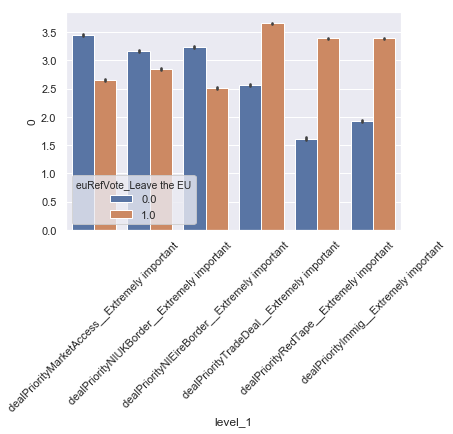

In [158]:
var_list = search(BES_reduced_with_na,"dealPriorityMarketAccess|dealPriorityNIUKBorder|dealPriorityNIEireBorder|dealPriorityTradeDeal|dealPriorityRedTape|dealPriorityImmig").index
df = BES_reduced_with_na.set_index("euRefVote_Leave the EU")[var_list].stack().reset_index()

# df = BES_reduced_with_na[var_list].stack().reset_index()

sns.barplot(y=df[0], x = df["level_1"], hue = df["euRefVote_Leave the EU"] )
plt.xticks(rotation = 45);

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


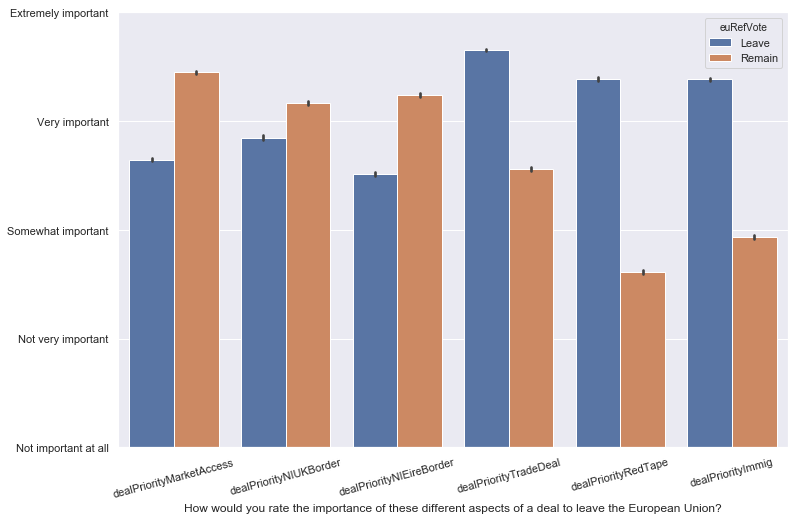

In [188]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"dealPriorityMarketAccess|dealPriorityNIUKBorder|dealPriorityNIEireBorder|dealPriorityTradeDeal|dealPriorityRedTape|dealPriorityImmig").index
df = BES_reduced_with_na.set_index("euRefVote_Leave the EU")[var_list].stack().reset_index()
df.columns = ["euRefVote",
              "How would you rate the importance of these different aspects of a deal to leave the European Union?",
              "values"]
df["euRefVote"] = df["euRefVote"].replace(0.0,"Remain").replace(1.0,"Leave")
df["How would you rate the importance of these different aspects of a deal to leave the European Union?"] = \
    df["How would you rate the importance of these different aspects of a deal to leave the European Union?"].apply(lambda x: x.replace("__Extremely important",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

sns.barplot(y = df["values"],
               x = df["How would you rate the importance of these different aspects of a deal to leave the European Union?"],
               hue = df["euRefVote"])#, split=True, cut=0, bw=.5 )
plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1,2,3,4],["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.ylabel("");


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


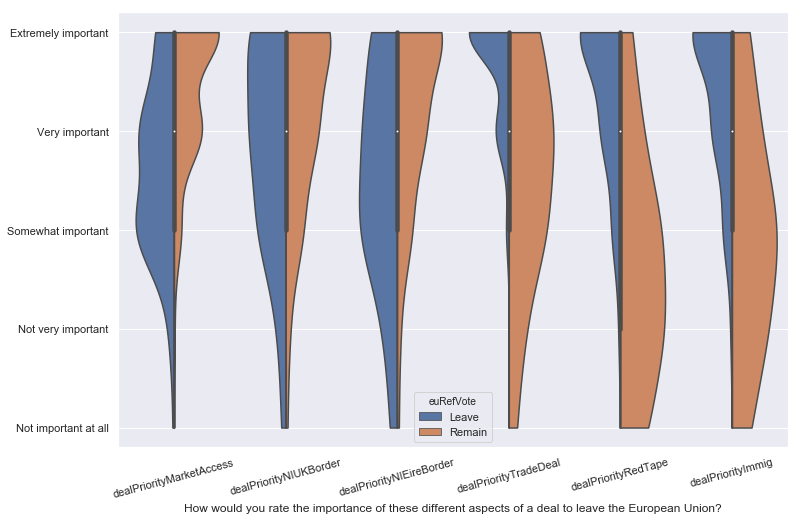

In [205]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"dealPriorityMarketAccess|dealPriorityNIUKBorder|dealPriorityNIEireBorder|dealPriorityTradeDeal|dealPriorityRedTape|dealPriorityImmig").index
df = BES_reduced_with_na.set_index("euRefVote_Leave the EU")[var_list].stack().reset_index()
df.columns = ["euRefVote",
              "How would you rate the importance of these different aspects of a deal to leave the European Union?",
              "values"]
df["euRefVote"] = df["euRefVote"].replace(0.0,"Remain").replace(1.0,"Leave")
df["How would you rate the importance of these different aspects of a deal to leave the European Union?"] = \
    df["How would you rate the importance of these different aspects of a deal to leave the European Union?"].apply(lambda x: x.replace("__Extremely important",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

title = "How would you rate the importance of these different aspects of a deal to leave the European Union?"

sns.violinplot(y = df["values"],
               x = df[title],
               hue = df["euRefVote"], split=True, cut=0, bw=.5, scale='count', scale_hue='true', inner='box' )
plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1,2,3,4],["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.ylabel("");

output_folder = create_subdir(BES_output_folder, "dealPrioritiesW15")
fname = output_folder + title.replace(" ","_").replace("?","") + ".png"
plt.savefig( fname, bbox_inches='tight' )   

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


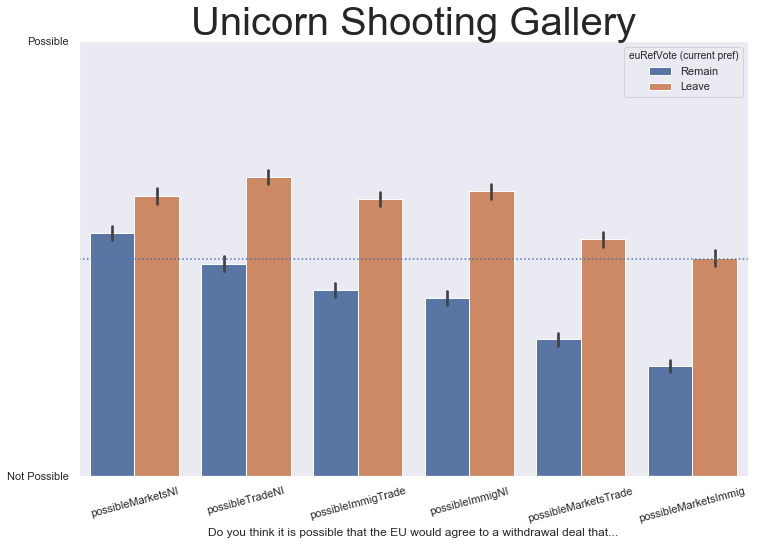

In [266]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"possibleTradeNI|possibleImmigNI|possibleMarketsImmig|possibleMarketsTrade|possibleImmigTrade|possibleMarketsNI").index
df = BES_reduced_with_na.set_index("euRefVote_Leave the EU")[var_list].stack().reset_index()
ques = "Do you think it is possible that the EU would agree to a withdrawal deal that..."
hue = "euRefVote (current pref)"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].replace(0.0,"Remain").replace(1.0,"Leave")
df[ques] = df[ques].apply(lambda x: x.replace("_Possible",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

sns.barplot(y = df["values"],
               x = df[ques],
               hue = df[hue],
               order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1],["Not Possible","Possible"]);
plt.ylabel("");
plt.axhline(.5, linestyle=':');
plt.title("Unicorn Shooting Gallery",fontsize=40);

output_folder = create_subdir(BES_output_folder, "unicornGrid")
fname = output_folder + ques.replace(" ","_").replace("?","") + ".png"
plt.savefig( fname, bbox_inches='tight' )   

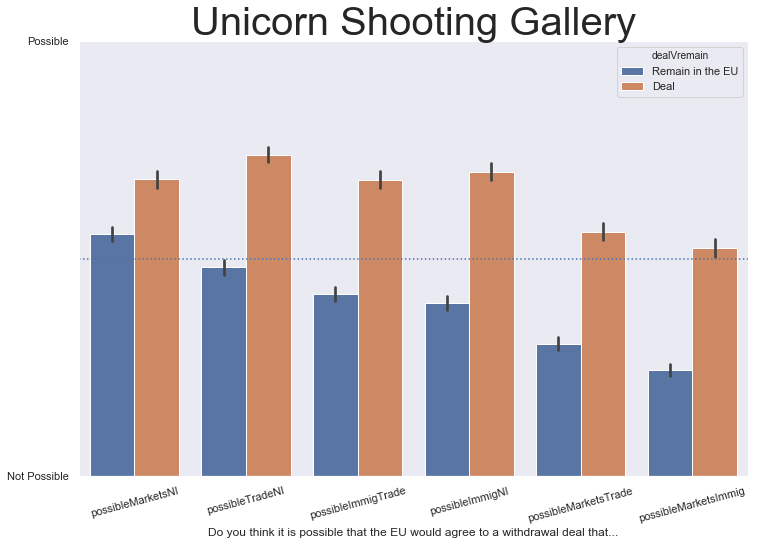

In [280]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"possibleTradeNI|possibleImmigNI|possibleMarketsImmig|possibleMarketsTrade|possibleImmigTrade|possibleMarketsNI").index
df = BES_reduced_with_na.set_index("dealVremain_Remain in the EU")[var_list].stack().reset_index()
ques = "Do you think it is possible that the EU would agree to a withdrawal deal that..."
hue = "dealVremain"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].replace(0.0,"Deal").replace(1.0,"Remain in the EU")
df[ques] = df[ques].apply(lambda x: x.replace("_Possible",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

sns.barplot(y = df["values"],
               x = df[ques],
               hue = df[hue],
               order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1],["Not Possible","Possible"]);
plt.ylabel("");
plt.axhline(.5, linestyle=':');
plt.title("Unicorn Shooting Gallery",fontsize=40);

output_folder = create_subdir(BES_output_folder, "unicornGrid")
fname = output_folder + ques.replace(" ","_").replace("?","") + "(dealVremain)" + ".png"
plt.savefig( fname, bbox_inches='tight' )   

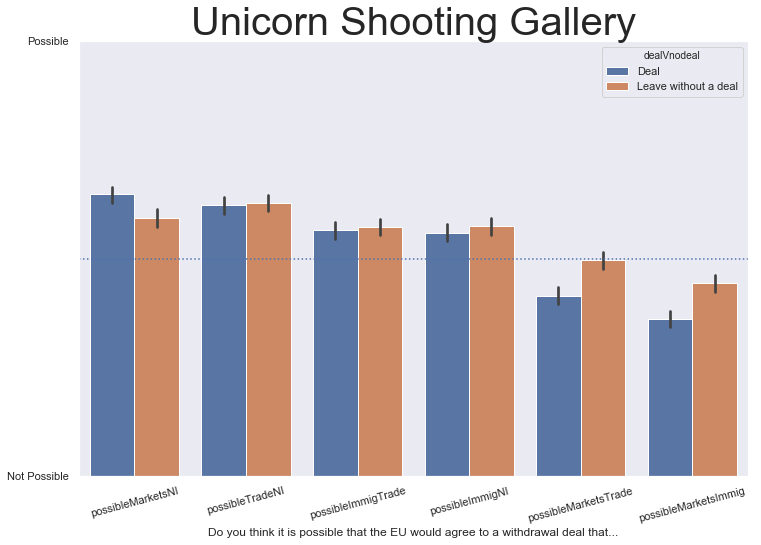

In [283]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"possibleTradeNI|possibleImmigNI|possibleMarketsImmig|possibleMarketsTrade|possibleImmigTrade|possibleMarketsNI").index
df = BES_reduced_with_na.set_index("dealVnodeal_Leave without a deal")[var_list].stack().reset_index()
ques = "Do you think it is possible that the EU would agree to a withdrawal deal that..."
hue = "dealVnodeal"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].replace(0.0,"Deal").replace(1.0,"Leave without a deal")
df[ques] = df[ques].apply(lambda x: x.replace("_Possible",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

sns.barplot(y = df["values"],
               x = df[ques],
               hue = df[hue],
               order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1],["Not Possible","Possible"]);
plt.ylabel("");
plt.axhline(.5, linestyle=':');
plt.title("Unicorn Shooting Gallery",fontsize=40);

output_folder = create_subdir(BES_output_folder, "unicornGrid")
fname = output_folder + ques.replace(" ","_").replace("?","") + "(dealVnodeal)" + ".png"
plt.savefig( fname, bbox_inches='tight' )   

In [284]:
# possibleTradeNI|possibleImmigNI|possibleMarketsImmig|possibleMarketsTrade|possibleImmigTrade|possibleMarketsNI
search(BES_reduced_with_na,"freeSpeechRacistSpeech")

freeSpeechRacistSpeech__Definitely    6259
dtype: int64

In [272]:
pattern = "possibleTradeNI_Possible"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50,top_num = 5)
import warnings
warnings.filterwarnings('ignore')

Top 5 positive (spearman) correlations for possibleTradeNI_Possible 
 
 
 r 
 p 
 N 
 
 
 possibleImmigNI_Possible 
 0.62 
 0.00 
 6157 
 
 possibleImmigTrade_Possible 
 0.56 
 0.00 
 6246 
 
 possibleMarketsNI_Possible 
 0.54 
 0.00 
 6135 
 
 possibleMarketsTrade_Possible 
 0.52 
 0.00 
 6227 
 
 possibleMarketsImmig_Possible 
 0.47 
 0.00 
 6217 
 
 
 Top 5 negative (spearman) correlations for possibleTradeNI_Possible 
 
 
 r 
 p 
 N 
 
 
 dealVremain_Remain in the EU 
 -0.26 
 0.00 
 5564 
 
 euLeaveBigBusiness__Much more likely 
 -0.22 
 0.00 
 6443 
 
 leaveImpactBritain__A very large impact 
 -0.21 
 0.00 
 6617 
 
 euRefDoOver_Yes 
 -0.2 
 0.00 
 6454 
 
 remainVnodeal_Remain in the EU 
 -0.19 
 0.00 
 6281

In [276]:
pattern = "possibleImmigNI_Possible"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50,top_num = 5)
import warnings
warnings.filterwarnings('ignore')

Top 5 positive (spearman) correlations for possibleImmigNI_Possible 
 
 
 r 
 p 
 N 
 
 
 possibleTradeNI_Possible 
 0.62 
 0.00 
 6157 
 
 possibleImmigTrade_Possible 
 0.57 
 0.00 
 6249 
 
 possibleMarketsImmig_Possible 
 0.56 
 0.00 
 6261 
 
 possibleMarketsNI_Possible 
 0.53 
 0.00 
 6142 
 
 possibleMarketsTrade_Possible 
 0.5 
 0.00 
 6207 
 
 
 Top 5 negative (spearman) correlations for possibleImmigNI_Possible 
 
 
 r 
 p 
 N 
 
 
 dealVremain_Remain in the EU 
 -0.3 
 0.00 
 5559 
 
 euLeaveBigBusiness__Much more likely 
 -0.26 
 0.00 
 6447 
 
 leaveImpactBritain__A very large impact 
 -0.25 
 0.00 
 6612 
 
 euRefDoOver_Yes 
 -0.24 
 0.00 
 6444 
 
 remainVnodeal_Remain in the EU 
 -0.23 
 0.00 
 6292

In [274]:
pattern = "possibleMarketsImmig_Possible"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50,top_num = 5)
import warnings
warnings.filterwarnings('ignore')

Top 5 positive (spearman) correlations for possibleMarketsImmig_Possible 
 
 
 r 
 p 
 N 
 
 
 possibleMarketsTrade_Possible 
 0.6 
 0.00 
 6557 
 
 possibleImmigNI_Possible 
 0.56 
 0.00 
 6261 
 
 possibleImmigTrade_Possible 
 0.54 
 0.00 
 6519 
 
 possibleMarketsNI_Possible 
 0.47 
 0.00 
 6308 
 
 possibleTradeNI_Possible 
 0.47 
 0.00 
 6217 
 
 
 Top 5 negative (spearman) correlations for possibleMarketsImmig_Possible 
 
 
 r 
 p 
 N 
 
 
 dealVremain_Remain in the EU 
 -0.29 
 0.00 
 5901 
 
 euLeaveBigBusiness__Much more likely 
 -0.28 
 0.00 
 6823 
 
 negotiationSpecifics_1_Yes 
 -0.26 
 0.00 
 6040 
 
 negotiationSpecifics_3_Yes 
 -0.25 
 0.00 
 6040 
 
 redistUKIP__Government should be less concerned[...] 
 -0.25 
 0.00 
 4525

In [275]:
pattern = "possibleMarketsTrade_Possible"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50,top_num = 5)
import warnings
warnings.filterwarnings('ignore')

Top 5 positive (spearman) correlations for possibleMarketsTrade_Possible 
 
 
 r 
 p 
 N 
 
 
 possibleMarketsImmig_Possible 
 0.6 
 0.00 
 6557 
 
 possibleImmigTrade_Possible 
 0.52 
 0.00 
 6494 
 
 possibleTradeNI_Possible 
 0.52 
 0.00 
 6227 
 
 possibleImmigNI_Possible 
 0.5 
 0.00 
 6207 
 
 possibleMarketsNI_Possible 
 0.48 
 0.00 
 6272 
 
 
 Top 5 negative (spearman) correlations for possibleMarketsTrade_Possible 
 
 
 r 
 p 
 N 
 
 
 negotiationSpecifics_1_Yes 
 -0.27 
 0.00 
 5959 
 
 dealVremain_Remain in the EU 
 -0.26 
 0.00 
 5849 
 
 euLeaveBigBusiness__Much more likely 
 -0.25 
 0.00 
 6761 
 
 leaveImpactBritain__A very large impact 
 -0.24 
 0.00 
 6940 
 
 negotiationSpecifics_3_Yes 
 -0.23 
 0.00 
 5959

In [277]:
pattern = "possibleImmigTrade_Possible"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50,top_num = 5)
import warnings
warnings.filterwarnings('ignore')

Top 5 positive (spearman) correlations for possibleImmigTrade_Possible 
 
 
 r 
 p 
 N 
 
 
 possibleImmigNI_Possible 
 0.57 
 0.00 
 6249 
 
 possibleTradeNI_Possible 
 0.56 
 0.00 
 6246 
 
 possibleMarketsImmig_Possible 
 0.54 
 0.00 
 6519 
 
 possibleMarketsTrade_Possible 
 0.52 
 0.00 
 6494 
 
 possibleMarketsNI_Possible 
 0.47 
 0.00 
 6220 
 
 
 Top 5 negative (spearman) correlations for possibleImmigTrade_Possible 
 
 
 r 
 p 
 N 
 
 
 dealVremain_Remain in the EU 
 -0.26 
 0.00 
 5775 
 
 euLeaveBigBusiness__Much more likely 
 -0.21 
 0.00 
 6713 
 
 leaveImpactBritain__A very large impact 
 -0.21 
 0.00 
 6894 
 
 remainVnodeal_Remain in the EU 
 -0.2 
 0.00 
 6563 
 
 negotiationSpecifics_1_Yes 
 -0.2 
 0.00 
 5923

In [287]:
pattern = "possibleMarketsNI_Possible"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50,top_num = 5)
import warnings
warnings.filterwarnings('ignore')

Top 5 positive (spearman) correlations for possibleMarketsNI_Possible 
 
 
 r 
 p 
 N 
 
 
 possibleTradeNI_Possible 
 0.54 
 0.00 
 6135 
 
 possibleImmigNI_Possible 
 0.53 
 0.00 
 6142 
 
 possibleMarketsTrade_Possible 
 0.48 
 0.00 
 6272 
 
 possibleMarketsImmig_Possible 
 0.47 
 0.00 
 6308 
 
 possibleImmigTrade_Possible 
 0.47 
 0.00 
 6220 
 
 
 Top 5 negative (spearman) correlations for possibleMarketsNI_Possible 
 
 
 r 
 p 
 N 
 
 
 negotiationSpecifics_1_Yes 
 -0.15 
 0.00 
 5750 
 
 dealVremain_Remain in the EU 
 -0.13 
 0.00 
 5599 
 
 noDealResults_111_Yes 
 -0.13 
 0.00 
 5770 
 
 leaveImpactBritain__A very large impact 
 -0.13 
 0.00 
 6628 
 
 euLeaveBigBusiness__Much more likely 
 -0.1 
 0.00 
 6472

In [286]:
# freeSpeechRacistSpeech|freeSpeechRacistElection|freeSpeechRacistTV|freeSpeechRacistTeach|freeSpeechMilitarySpeech|freeSpeechMilitaryElection|freeSpeechMilitaryTV|freeSpeechMilitaryTeach|freeSpeechIslamistSpeech|freeSpeechIslamistElection|freeSpeechIslamistTV|freeSpeechIslamistTeach

pattern = "freeSpeechRacistSpeech__Definitely"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for freeSpeechRacistSpeech__Definitely 
 
 
 r 
 p 
 N 
 
 
 freeSpeechRacistTV__Definitely 
 0.79 
 0.00 
 6145 
 
 freeSpeechRacistElection__Definitely 
 0.74 
 0.00 
 6141 
 
 freeSpeechIslamistSpeech__Definitely 
 0.62 
 0.00 
 6129 
 
 freeSpeechMilitarySpeech__Definitely 
 0.59 
 0.00 
 5949 
 
 freeSpeechRacistTeach__Definitely 
 0.59 
 0.00 
 6165 
 
 freeSpeechIslamistTV__Definitely 
 0.58 
 0.00 
 6109 
 
 freeSpeechMilitaryTV__Definitely 
 0.55 
 0.00 
 5984 
 
 freeSpeechIslamistElection__Definitely 
 0.53 
 0.00 
 6113 
 
 freeSpeechMilitaryElection__Definitely 
 0.5 
 0.00 
 5971 
 
 freeSpeechMilitaryTeach__Definitely 
 0.41 
 0.00 
 5933 
 
 freeSpeechIslamistTeach__Definitely 
 0.38 
 0.00 
 6157 
 
 ptvBrexitParty__Very likely 
 0.14 
 0.00 
 5181 
 
 subjectHE_Engineering, Mathematics or Natural[...] 
 0.14 
 0.00 
 1430 
 
 likeMogg__Strongly like 
 0.14 
 0.00 
 5321 
 
 ptvUKIP__Very likely 
 0.13 
 0.00 
 5947 
 
 femaleEquality__Gone much too far 
 0.13 
 0.00 
 1031 
 
 likeFarage__Strongly like 
 0.13 
 0.00 
 6047 
 
 likeBrexitParty__Strongly like 
 0.13 
 0.00 
 4335 
 
 changeNHS__Getting a lot better 
 0.12 
 0.00 
 6092 
 
 immigUKIP__Allow many more 
 0.12 
 0.00 
 5202 
 
 
 Top 20 negative (spearman) correlations for freeSpeechRacistSpeech__Definitely 
 
 
 r 
 p 
 N 
 
 
 lrCon__Right 
 -0.15 
 0.00 
 5064 
 
 gender_Female 
 -0.14 
 0.00 
 5181 
 
 personality_agreeableness 
 -0.14 
 0.00 
 3520 
 
 al4W14__Strongly agree 
 -0.14 
 0.00 
 5029 
 
 changeCrime__Getting a lot higher 
 -0.12 
 0.00 
 6038 
 
 efficacyNotUnderstand__Strongly agree 
 -0.12 
 0.00 
 6206 
 
 dealPriorityNIEireBorder__Extremely important 
 -0.1 
 0.00 
 5763 
 
 al_scaleW14__Authoritarian 
 -0.1 
 0.00 
 4663 
 
 partyIdSqueeze_No - none 
 -0.1 
 0.00 
 1312 
 
 neverPrivSchool_Yes 
 -0.1 
 0.00 
 1063 
 
 al5W14__Strongly agree 
 -0.1 
 0.00 
 5016 
 
 lrTIG__Right 
 -0.09 
 0.00 
 3406 
 
 lr3W14__Strongly agree 
 -0.09 
 0.00 
 5037 
 
 lrgreens__Right 
 -0.09 
 0.00 
 4309 
 
 genTrust_Can't be too careful 
 -0.08 
 0.00 
 5857 
 
 changeCostLive__Getting a lot higher 
 -0.08 
 0.00 
 6128 
 
 partyIdSqueezeTIG_No - None 
 -0.08 
 0.00 
 1254 
 
 newspaperRead_None 
 -0.08 
 0.00 
 6259 
 
 subjectHE_Humanities, social sciences, psychology[...] 
 -0.08 
 0.00 
 1430 
 
 pastvote_2017_Labour 
 -0.08 
 0.00 
 5399

In [290]:
# freeSpeechRacistSpeech|freeSpeechRacistElection|freeSpeechRacistTV|freeSpeechRacistTeach|freeSpeechMilitarySpeech|freeSpeechMilitaryElection|freeSpeechMilitaryTV|freeSpeechMilitaryTeach|freeSpeechIslamistSpeech|freeSpeechIslamistElection|freeSpeechIslamistTV|freeSpeechIslamistTeach

pattern = "freeSpeechMilitarySpeech__Definitely"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for freeSpeechMilitarySpeech__Definitely 
 
 
 r 
 p 
 N 
 
 
 freeSpeechMilitaryTV__Definitely 
 0.82 
 0.00 
 5990 
 
 freeSpeechMilitaryElection__Definitely 
 0.75 
 0.00 
 5974 
 
 freeSpeechMilitaryTeach__Definitely 
 0.63 
 0.00 
 5917 
 
 freeSpeechRacistSpeech__Definitely 
 0.59 
 0.00 
 5949 
 
 freeSpeechRacistTV__Definitely 
 0.56 
 0.00 
 5943 
 
 freeSpeechIslamistSpeech__Definitely 
 0.52 
 0.00 
 5974 
 
 freeSpeechRacistElection__Definitely 
 0.51 
 0.00 
 5943 
 
 freeSpeechIslamistTV__Definitely 
 0.51 
 0.00 
 5965 
 
 freeSpeechIslamistElection__Definitely 
 0.46 
 0.00 
 5972 
 
 freeSpeechRacistTeach__Definitely 
 0.36 
 0.00 
 5969 
 
 freeSpeechIslamistTeach__Definitely 
 0.32 
 0.00 
 6005 
 
 profile_education_age__Still at school/Full time[...] 
 0.15 
 0.00 
 3713 
 
 ldUnited__Very united 
 0.14 
 0.00 
 4440 
 
 likeBartley__Strongly like 
 0.13 
 0.00 
 939 
 
 femaleEquality__Gone much too far 
 0.13 
 0.00 
 990 
 
 subjectHE_Engineering, Mathematics or Natural[...] 
 0.11 
 0.00 
 1401 
 
 immigGreen__Allow many more 
 0.11 
 0.00 
 3626 
 
 profile_religion_denom_None 
 0.1 
 0.00 
 1526 
 
 redistSelf__Government should be less concerned[...] 
 0.1 
 0.00 
 5607 
 
 likeDUP__Strongly like 
 0.1 
 0.00 
 4688 
 
 
 Top 20 negative (spearman) correlations for freeSpeechMilitarySpeech__Definitely 
 
 
 r 
 p 
 N 
 
 
 al4W14__Strongly agree 
 -0.15 
 0.00 
 4911 
 
 lrCon__Right 
 -0.15 
 0.00 
 4987 
 
 ageGroup__66+ 
 -0.15 
 0.00 
 4420 
 
 age 
 -0.14 
 0.00 
 6091 
 
 gender_Female 
 -0.13 
 0.00 
 5065 
 
 al_scaleW14__Authoritarian 
 -0.13 
 0.00 
 4561 
 
 personality_agreeableness 
 -0.13 
 0.00 
 3480 
 
 lrgreens__Right 
 -0.12 
 0.00 
 4257 
 
 partyIdSqueezeTIG_No - None 
 -0.12 
 0.00 
 1197 
 
 changeCrime__Getting a lot higher 
 -0.12 
 0.00 
 5886 
 
 workingStatus_Retired 
 -0.11 
 0.00 
 4115 
 
 al1W14__Strongly agree 
 -0.11 
 0.00 
 4867 
 
 al5W14__Strongly agree 
 -0.11 
 0.00 
 4896 
 
 dealPriorityNIEireBorder__Extremely important 
 -0.09 
 0.00 
 5647 
 
 al3W14__Strongly agree 
 -0.09 
 0.00 
 4962 
 
 genTrust_Can't be too careful 
 -0.09 
 0.00 
 5715 
 
 efficacyNotUnderstand__Strongly agree 
 -0.09 
 0.00 
 6045 
 
 antiIntellectual__Strongly agree 
 -0.09 
 0.00 
 5904 
 
 populism6__Strongly agree 
 -0.09 
 0.00 
 5585 
 
 subjectHE_Humanities, social sciences, psychology[...] 
 -0.08 
 0.00 
 1401

In [291]:
# freeSpeechRacistSpeech|freeSpeechRacistElection|freeSpeechRacistTV|freeSpeechRacistTeach|freeSpeechMilitarySpeech|freeSpeechMilitaryElection|freeSpeechMilitaryTV|freeSpeechMilitaryTeach|freeSpeechIslamistSpeech|freeSpeechIslamistElection|freeSpeechIslamistTV|freeSpeechIslamistTeach

pattern = "freeSpeechIslamistSpeech__Definitely"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for freeSpeechIslamistSpeech__Definitely 
 
 
 r 
 p 
 N 
 
 
 freeSpeechIslamistTV__Definitely 
 0.79 
 0.00 
 6217 
 
 freeSpeechIslamistElection__Definitely 
 0.72 
 0.00 
 6210 
 
 freeSpeechRacistSpeech__Definitely 
 0.62 
 0.00 
 6129 
 
 freeSpeechRacistTV__Definitely 
 0.56 
 0.00 
 6119 
 
 freeSpeechIslamistTeach__Definitely 
 0.53 
 0.00 
 6254 
 
 freeSpeechRacistElection__Definitely 
 0.53 
 0.00 
 6117 
 
 freeSpeechMilitarySpeech__Definitely 
 0.52 
 0.00 
 5974 
 
 freeSpeechMilitaryTV__Definitely 
 0.5 
 0.00 
 6012 
 
 freeSpeechMilitaryElection__Definitely 
 0.45 
 0.00 
 6001 
 
 freeSpeechRacistTeach__Definitely 
 0.35 
 0.00 
 6146 
 
 freeSpeechMilitaryTeach__Definitely 
 0.34 
 0.00 
 5965 
 
 profile_education_age__Still at school/Full time[...] 
 0.22 
 0.00 
 3846 
 
 immigSelf__Allow many more 
 0.21 
 0.00 
 5891 
 
 EUIntegrationCorbyn__Protect our independence 
 0.18 
 0.00 
 5083 
 
 immigCultural__Enriches cultural life 
 0.17 
 0.00 
 6090 
 
 echr__Strongly agree 
 0.17 
 0.00 
 5938 
 
 likeBartley__Strongly like 
 0.17 
 0.00 
 953 
 
 immigEcon__Good for economy 
 0.16 
 0.00 
 6049 
 
 ptvLD__Very likely 
 0.15 
 0.00 
 5841 
 
 europeanness__Very strongly European 
 0.15 
 0.00 
 6173 
 
 
 Top 20 negative (spearman) correlations for freeSpeechIslamistSpeech__Definitely 
 
 
 r 
 p 
 N 
 
 
 al_scaleW14__Authoritarian 
 -0.26 
 0.00 
 4719 
 
 al5W14__Strongly agree 
 -0.23 
 0.00 
 5072 
 
 al1W14__Strongly agree 
 -0.22 
 0.00 
 5042 
 
 dealPriorityImmig__Extremely important 
 -0.22 
 0.00 
 6029 
 
 al3W14__Strongly agree 
 -0.21 
 0.00 
 5139 
 
 al2W14__Strongly agree 
 -0.19 
 0.00 
 5036 
 
 changeCrime__Getting a lot higher 
 -0.19 
 0.00 
 6097 
 
 dealPriorityTradeDeal__Extremely important 
 -0.18 
 0.00 
 6015 
 
 al4W14__Strongly agree 
 -0.17 
 0.00 
 5084 
 
 dealPriorityRedTape__Extremely important 
 -0.17 
 0.00 
 5944 
 
 populism1__Strongly agree 
 -0.16 
 0.00 
 6084 
 
 populism5__Strongly agree 
 -0.16 
 0.00 
 6073 
 
 genTrust_Can't be too careful 
 -0.15 
 0.00 
 5910 
 
 populism6__Strongly agree 
 -0.15 
 0.00 
 5717 
 
 antiIntellectual__Strongly agree 
 -0.15 
 0.00 
 6099 
 
 englishness__Very strongly English 
 -0.14 
 0.00 
 6228 
 
 immigLab__Allow many more 
 -0.13 
 0.00 
 4875 
 
 britishness__Very strongly British 
 -0.13 
 0.00 
 6244 
 
 euPriorityBalance__Control immigration 
 -0.13 
 0.00 
 5636 
 
 efficacyNotUnderstand__Strongly agree 
 -0.13 
 0.00 
 6259

In [13]:
search(BES_reduced_with_na,"freespeech")

freeSpeechRacistSpeech__Definitely        6259
freeSpeechRacistElection__Definitely      6273
freeSpeechRacistTV__Definitely            6256
freeSpeechRacistTeach__Definitely         6315
freeSpeechMilitarySpeech__Definitely      6093
freeSpeechMilitaryElection__Definitely    6135
freeSpeechMilitaryTV__Definitely          6150
freeSpeechMilitaryTeach__Definitely       6102
freeSpeechIslamistSpeech__Definitely      6326
freeSpeechIslamistElection__Definitely    6328
freeSpeechIslamistTV__Definitely          6312
freeSpeechIslamistTeach__Definitely       6396
dtype: int64

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique
Wall time: 3.79 s


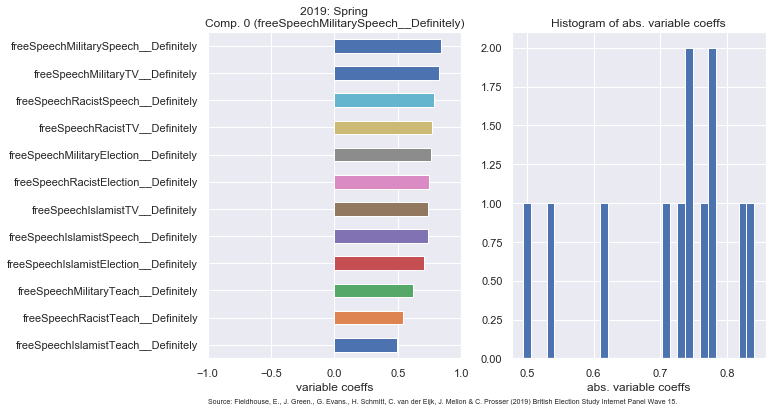

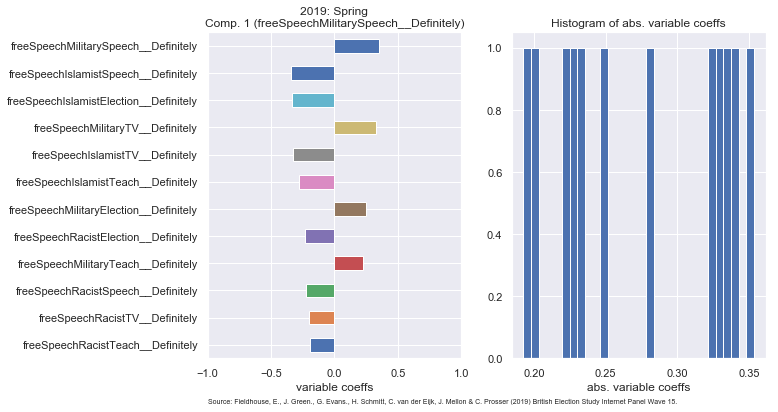

In [14]:
%%time

df = BES_reduced_with_na[search(BES_reduced_with_na,"freespeech").index].copy()

df = df.fillna(df.mean())




output_subfolder = BES_output_folder+os.sep + "racism_fusion" + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    

# standardise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df.columns,
                             index   = df.index      )



n_components = BES_std.shape[1]
n_components = 2
alpha = 18
decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
# decomp = SparsePCA(n_components = n_components, alpha = alpha)
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method


# display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df.columns, BES_decomp, manifest=manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 10, show_histogram = True)

In [16]:
freespeechcorr = BES_reduced_with_na.corrwith(BES_decomp[0])

In [18]:
freespeechcorr.dropna().sort_values()

populism6__Strongly agree                                             -0.091514
populism5__Strongly agree                                             -0.087879
al4W14__Strongly agree                                                -0.073652
al_scaleW14__Authoritarian                                            -0.067683
populism1__Strongly agree                                             -0.063194
lrCon__Right                                                          -0.061597
efficacyNotUnderstand__Strongly agree                                 -0.061576
changeCrime__Getting a lot higher                                     -0.060666
noDealResults_111_Yes                                                 -0.057906
age                                                                   -0.057382
al5W14__Strongly agree                                                -0.056610
partyIdSqueezeTIG_No - None                                           -0.053498
genTrust_Can't be too careful           

In [19]:
dodgyfreespeechcorr = BES_reduced_with_na.corrwith(BES_decomp[1])
dodgyfreespeechcorr.dropna().sort_values()

freeSpeechIslamistSpeech__Definitely            -0.396163
freeSpeechIslamistElection__Definitely          -0.391292
freeSpeechIslamistTV__Definitely                -0.377321
freeSpeechIslamistTeach__Definitely             -0.326901
freeSpeechRacistElection__Definitely            -0.277252
freeSpeechRacistSpeech__Definitely              -0.262964
freeSpeechRacistTV__Definitely                  -0.234125
freeSpeechRacistTeach__Definitely               -0.226984
pcGoneMad__Need to change the way people talk   -0.085234
immigSelf__Allow many more                      -0.041642
immigCultural__Enriches cultural life           -0.039673
EUIntegrationGreen__Protect our independence    -0.036318
pidWeThey__Strongly agree                       -0.036297
lrLD__Right                                     -0.036086
effectsEUImmigration__Much higher               -0.035758
echr__Strongly agree                            -0.034754
partyMember__Yes, I am a member of a party      -0.034520
immigEcon__Goo

In [293]:
pattern = "pcGoneMad__Need to change the way people talk"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for pcGoneMad__Need to change the way people talk 
 
 
 r 
 p 
 N 
 
 
 immigCultural__Enriches cultural life 
 0.44 
 0.00 
 6184 
 
 immigSelf__Allow many more 
 0.41 
 0.00 
 5963 
 
 echr__Strongly agree 
 0.4 
 0.00 
 5994 
 
 remainVnodeal_Remain in the EU 
 0.38 
 0.00 
 5708 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.36 
 0.00 
 5675 
 
 likeBerry__Strongly like 
 0.36 
 0.00 
 1095 
 
 immigEcon__Good for economy 
 0.36 
 0.00 
 6149 
 
 cancelBrexit__Strongly agree 
 0.34 
 0.00 
 6012 
 
 likeGrn__Strongly like 
 0.34 
 0.00 
 5812 
 
 normEU__Strongly agree 
 0.34 
 0.00 
 5899 
 
 dealVremain_Remain in the EU 
 0.33 
 0.00 
 4973 
 
 europeanness__Very strongly European 
 0.33 
 0.00 
 6305 
 
 euRefDoOver_Yes 
 0.33 
 0.00 
 5965 
 
 likeLab__Strongly like 
 0.33 
 0.00 
 6196 
 
 ptvLab__Very likely 
 0.33 
 0.00 
 6025 
 
 ptvGrn__Very likely 
 0.31 
 0.00 
 5890 
 
 euLeaveBigBusiness__Much more likely 
 0.31 
 0.00 
 5809 
 
 handleEUNegotiateLab__Very well 
 0.3 
 0.00 
 5867 
 
 likeCorbyn__Strongly like 
 0.29 
 0.00 
 6203 
 
 ptvLD__Very likely 
 0.29 
 0.00 
 5902 
 
 
 Top 20 negative (spearman) correlations for pcGoneMad__Need to change the way people talk 
 
 
 r 
 p 
 N 
 
 
 blackEquality__Gone much too far 
 -0.45 
 0.00 
 1012 
 
 EUIntegrationSelf__Protect our independence 
 -0.4 
 0.00 
 6120 
 
 noDealLongTerm__Extremely good 
 -0.39 
 0.00 
 5578 
 
 gayEquality__Gone much too far 
 -0.39 
 0.00 
 1015 
 
 willOfPeople__Strongly agree 
 -0.38 
 0.00 
 6243 
 
 euID_The leave side 
 -0.37 
 0.00 
 5821 
 
 euRefVote_Leave the EU 
 -0.37 
 0.00 
 5800 
 
 dealPriorityRedTape__Extremely important 
 -0.36 
 0.00 
 6012 
 
 femaleEquality__Gone much too far 
 -0.36 
 0.00 
 1050 
 
 likeFarage__Strongly like 
 -0.36 
 0.00 
 6185 
 
 euRefpastVote_Leave the EU 
 -0.35 
 0.00 
 5692 
 
 pastvote_EURef_Leave the EU 
 -0.34 
 0.00 
 5786 
 
 profile_eurefvote_Leave the EU 
 -0.34 
 0.00 
 4727 
 
 likeUKIP__Strongly like 
 -0.34 
 0.00 
 6110 
 
 al1W14__Strongly agree 
 -0.34 
 0.00 
 5140 
 
 immigLab__Allow many more 
 -0.34 
 0.00 
 4913 
 
 dealPriorityImmig__Extremely important 
 -0.34 
 0.00 
 6109 
 
 likeBrexitParty__Strongly like 
 -0.34 
 0.00 
 4445 
 
 noDealShortTerm__Extremely good 
 -0.33 
 0.00 
 5732 
 
 leftRight__Right 
 -0.33 
 0.00 
 5269

In [297]:
# spendHealth|spendPensions|spendUnemp

pattern = "spendHealth__Spend much more"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for spendHealth__Spend much more 
 
 
 r 
 p 
 N 
 
 
 taxSpendSelf__Government should increase taxes a[...] 
 0.44 
 0.00 
 5744 
 
 spendPensions__Spend much more 
 0.35 
 0.00 
 6232 
 
 lr3W14__Strongly agree 
 0.31 
 0.00 
 5055 
 
 profile_past_vote_2017_Labour 
 0.3 
 0.00 
 4193 
 
 pastvote_2017_Labour 
 0.29 
 0.00 
 5509 
 
 lr1W14__Strongly agree 
 0.28 
 0.00 
 4992 
 
 lr4W14__Strongly agree 
 0.26 
 0.00 
 5113 
 
 spendUnemp__Spend much more 
 0.26 
 0.00 
 6170 
 
 ptvLab__Very likely 
 0.25 
 0.00 
 5992 
 
 generalElectionVote_Labour 
 0.25 
 0.00 
 4191 
 
 lrCon__Right 
 0.25 
 0.00 
 5065 
 
 profile_past_vote_2015_Labour 
 0.25 
 0.00 
 5325 
 
 partyIdTIG_Labour 
 0.24 
 0.00 
 5801 
 
 partyId_Labour 
 0.24 
 0.00 
 5940 
 
 euLeaveBigBusiness__Much more likely 
 0.24 
 0.00 
 5795 
 
 generalElectionVoteTIG_Labour 
 0.24 
 0.00 
 4311 
 
 likeGrn__Strongly like 
 0.23 
 0.00 
 5737 
 
 lr2W14__Strongly agree 
 0.23 
 0.00 
 5073 
 
 socialDistLab__Very happy 
 0.22 
 0.00 
 5819 
 
 dealPriorityMarketAccess__Extremely important 
 0.22 
 0.00 
 6066 
 
 
 Top 20 negative (spearman) correlations for spendHealth__Spend much more 
 
 
 r 
 p 
 N 
 
 
 changeNHS__Getting a lot better 
 -0.39 
 0.00 
 6247 
 
 leftRight__Right 
 -0.36 
 0.00 
 5176 
 
 howToReduceDeficit__Only by cutting spending 
 -0.33 
 0.00 
 5379 
 
 changeEducation__Getting a lot better 
 -0.33 
 0.00 
 5928 
 
 lr_scaleW14__Right 
 -0.32 
 0.00 
 4814 
 
 likeCon__Strongly like 
 -0.31 
 0.00 
 6164 
 
 ptvCon__Very likely 
 -0.31 
 0.00 
 5973 
 
 changeEconomy__Getting a lot better 
 -0.3 
 0.00 
 6174 
 
 profile_past_vote_2017_Conservative 
 -0.29 
 0.00 
 4193 
 
 pastvote_2017_Conservative 
 -0.29 
 0.00 
 5509 
 
 redistSelf__Government should be less concerned[...] 
 -0.29 
 0.00 
 5797 
 
 econGenRetro__Got a lot better 
 -0.29 
 0.00 
 6097 
 
 generalElectionVoteTIG_Conservative 
 -0.28 
 0.00 
 4311 
 
 likeMogg__Strongly like 
 -0.28 
 0.00 
 5355 
 
 generalElectionVote_Conservative 
 -0.27 
 0.00 
 4191 
 
 socialDistCon__Very happy 
 -0.26 
 0.00 
 5835 
 
 ukCoopWorkers__Bad for Britain 
 -0.25 
 0.00 
 5685 
 
 profile_past_vote_2010_Conservative 
 -0.25 
 0.00 
 4058 
 
 taxHighIncome__Much too low 
 -0.25 
 0.00 
 5959 
 
 profile_past_vote_2015_Conservative 
 -0.25 
 0.00 
 5325

In [298]:
# spendHealth|spendPensions|spendUnemp

pattern = "spendPensions__Spend much more"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for spendPensions__Spend much more 
 
 
 r 
 p 
 N 
 
 
 spendHealth__Spend much more 
 0.35 
 0.00 
 6232 
 
 age 
 0.24 
 0.00 
 6308 
 
 ageGroup__66+ 
 0.24 
 0.00 
 4572 
 
 al_scaleW14__Authoritarian 
 0.21 
 0.00 
 4655 
 
 taxLowIncome__Much too low 
 0.21 
 0.00 
 6014 
 
 al1W14__Strongly agree 
 0.2 
 0.00 
 4986 
 
 antiIntellectual__Strongly agree 
 0.2 
 0.00 
 6064 
 
 changeCrime__Getting a lot higher 
 0.19 
 0.00 
 6163 
 
 lr3W14__Strongly agree 
 0.19 
 0.00 
 5016 
 
 lr4W14__Strongly agree 
 0.19 
 0.00 
 5073 
 
 spendUnemp__Spend much more 
 0.18 
 0.00 
 6162 
 
 dealPriorityImmig__Extremely important 
 0.17 
 0.00 
 6051 
 
 lr5W14__Strongly agree 
 0.17 
 0.00 
 5009 
 
 al2W14__Strongly agree 
 0.16 
 0.00 
 4938 
 
 al5W14__Strongly agree 
 0.16 
 0.00 
 5029 
 
 al3W14__Strongly agree 
 0.16 
 0.00 
 5062 
 
 efficacyPolCare__Strongly agree 
 0.16 
 0.00 
 6234 
 
 workingStatus_Retired 
 0.15 
 0.00 
 4248 
 
 changeImmig__Getting a lot higher 
 0.15 
 0.00 
 5826 
 
 lr2W14__Strongly agree 
 0.15 
 0.00 
 5038 
 
 
 Top 20 negative (spearman) correlations for spendPensions__Spend much more 
 
 
 r 
 p 
 N 
 
 
 profile_education_age__Still at school/Full time[...] 
 -0.25 
 0.00 
 3874 
 
 lr_scaleW14__Right 
 -0.21 
 0.00 
 4785 
 
 profile_gross_household__£150,000 and over 
 -0.19 
 0.00 
 4841 
 
 trustMPs__A great deal of trust 
 -0.17 
 0.00 
 6204 
 
 likeBerger__Strongly like 
 -0.16 
 0.00 
 2340 
 
 redistSelf__Government should be less concerned[...] 
 -0.16 
 0.00 
 5755 
 
 ptvLD__Very likely 
 -0.16 
 0.00 
 5852 
 
 ldUnited__Very united 
 -0.16 
 0.00 
 4505 
 
 profile_gross_personal__£100,000 and over 
 -0.15 
 0.00 
 3047 
 
 likeTIG__Strongly like 
 -0.15 
 0.00 
 4424 
 
 econPersonalRetro__Got a lot better 
 -0.15 
 0.00 
 6228 
 
 likeLD__Strongly like 
 -0.15 
 0.00 
 5898 
 
 workingStatus_Working full time (30 or more hours[...] 
 -0.15 
 0.00 
 4248 
 
 changeNHS__Getting a lot better 
 -0.15 
 0.00 
 6195 
 
 immigSelf__Allow many more 
 -0.14 
 0.00 
 5936 
 
 likeSoubry__Strongly like 
 -0.14 
 0.00 
 3961 
 
 likeCable__Strongly like 
 -0.13 
 0.00 
 5221 
 
 anyUni__Yes, I graduated from higher education 
 -0.13 
 0.00 
 6192 
 
 changeEducation__Getting a lot better 
 -0.13 
 0.00 
 5884 
 
 partyIdSqueeze_Liberal Democrat 
 -0.12 
 0.00 
 1383

In [299]:
# spendHealth|spendPensions|spendUnemp

pattern = "spendUnemp__Spend much more"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for spendUnemp__Spend much more 
 
 
 r 
 p 
 N 
 
 
 lr1W14__Strongly agree 
 0.36 
 0.00 
 4919 
 
 taxSpendSelf__Government should increase taxes a[...] 
 0.32 
 0.00 
 5664 
 
 ptvLab__Very likely 
 0.32 
 0.00 
 5893 
 
 profile_past_vote_2017_Labour 
 0.31 
 0.00 
 4138 
 
 generalElectionVote_Labour 
 0.31 
 0.00 
 4118 
 
 generalElectionVoteTIG_Labour 
 0.3 
 0.00 
 4232 
 
 pastvote_2017_Labour 
 0.3 
 0.00 
 5428 
 
 likeLab__Strongly like 
 0.3 
 0.00 
 6074 
 
 echr__Strongly agree 
 0.29 
 0.00 
 5904 
 
 likeCorbyn__Strongly like 
 0.29 
 0.00 
 6092 
 
 profile_past_vote_2015_Labour 
 0.29 
 0.00 
 5256 
 
 lr3W14__Strongly agree 
 0.29 
 0.00 
 4973 
 
 handleEUNegotiateLab__Very well 
 0.28 
 0.00 
 5732 
 
 integrityCorbyn__Complete integrity 
 0.27 
 0.00 
 5682 
 
 partyId_Labour 
 0.27 
 0.00 
 5860 
 
 partyIdTIG_Labour 
 0.26 
 0.00 
 5710 
 
 spendHealth__Spend much more 
 0.26 
 0.00 
 6170 
 
 socialDistLab__Very happy 
 0.26 
 0.00 
 5741 
 
 immigSelf__Allow many more 
 0.26 
 0.00 
 5899 
 
 immigCultural__Enriches cultural life 
 0.25 
 0.00 
 6036 
 
 
 Top 20 negative (spearman) correlations for spendUnemp__Spend much more 
 
 
 r 
 p 
 N 
 
 
 leftRight__Right 
 -0.39 
 0.00 
 5085 
 
 howToReduceDeficit__Only by cutting spending 
 -0.36 
 0.00 
 5326 
 
 ptvCon__Very likely 
 -0.34 
 0.00 
 5878 
 
 pastvote_2017_Conservative 
 -0.34 
 0.00 
 5428 
 
 redistSelf__Government should be less concerned[...] 
 -0.33 
 0.00 
 5709 
 
 likeCon__Strongly like 
 -0.33 
 0.00 
 6076 
 
 profile_past_vote_2017_Conservative 
 -0.33 
 0.00 
 4138 
 
 lr_scaleW14__Right 
 -0.32 
 0.00 
 4749 
 
 generalElectionVoteTIG_Conservative 
 -0.31 
 0.00 
 4232 
 
 socialDistCon__Very happy 
 -0.31 
 0.00 
 5756 
 
 generalElectionVote_Conservative 
 -0.3 
 0.00 
 4118 
 
 blackEquality__Gone much too far 
 -0.29 
 0.00 
 985 
 
 profile_past_vote_2015_Conservative 
 -0.29 
 0.00 
 5256 
 
 partyIdTIG_Conservative 
 -0.28 
 0.00 
 5710 
 
 al_scaleW14__Authoritarian 
 -0.28 
 0.00 
 4618 
 
 profile_past_vote_2005_Conservative 
 -0.27 
 0.00 
 3274 
 
 likeBoris__Strongly like 
 -0.27 
 0.00 
 6082 
 
 al5W14__Strongly agree 
 -0.27 
 0.00 
 4994 
 
 taxHighIncome__Much too low 
 -0.27 
 0.00 
 5897 
 
 partyId_Conservative 
 -0.27 
 0.00 
 5860

In [296]:
# dealPriorityMarketAccess|dealPriorityNIUKBorder|dealPriorityNIEireBorder|dealPriorityTradeDeal|dealPriorityRedTape|dealPriorityImmig|impReligion

search(BES_reduced_with_na,"spendHealth")

spendHealth__Spend much more    6372
dtype: int64

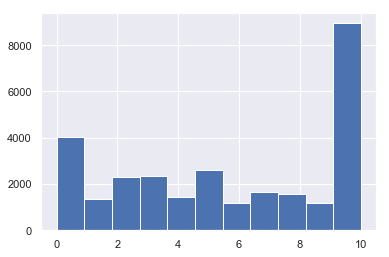

In [66]:
BES_reduced_with_na["EUIntegrationSelf__Protect our independence"].hist(bins=11);

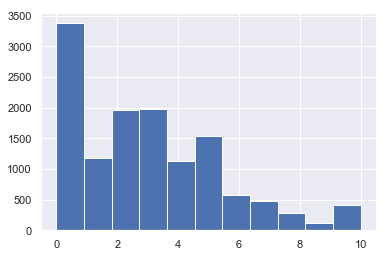

In [67]:
BES_reduced_with_na["EUIntegrationSelf__Protect our independence"][Remainers].hist(bins=11);

In [64]:
Remainers = BES_Panel["pastvote_EURef"]=="Stay/remain in the EU"

Warning, filename truncated because it was over 120. Filenames may no longer be unique


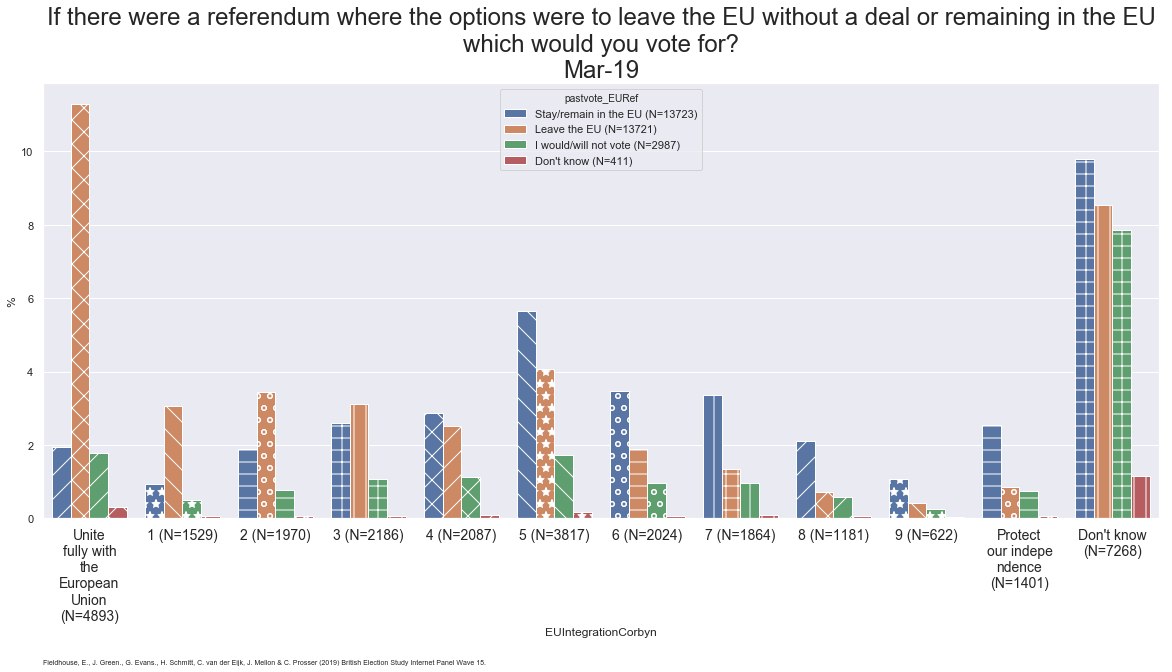

In [57]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 15

var2 ="remainVnodeal"
var1 ="EUIntegrationCorbyn"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Some people feel that Britain should do all it can to unite fully with the European Union.\nOther people feel that Britain should do all it can to protect its independence from the European Union.\nWhere would you place Jeremy Corbyn on this scale?"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

Warning, filename truncated because it was over 120. Filenames may no longer be unique


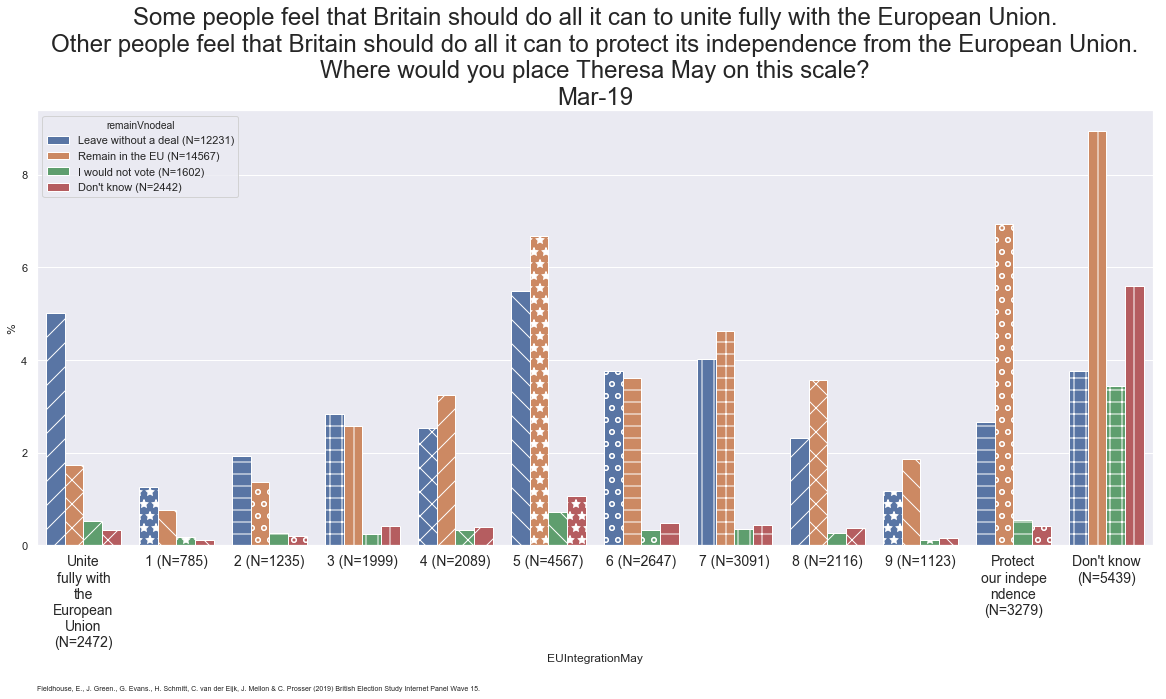

In [70]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 15

var1 ="remainVnodeal"
var2 ="EUIntegrationMay"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Some people feel that Britain should do all it can to unite fully with the European Union.\nOther people feel that Britain should do all it can to protect its independence from the European Union.\nWhere would you place Theresa May on this scale?"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

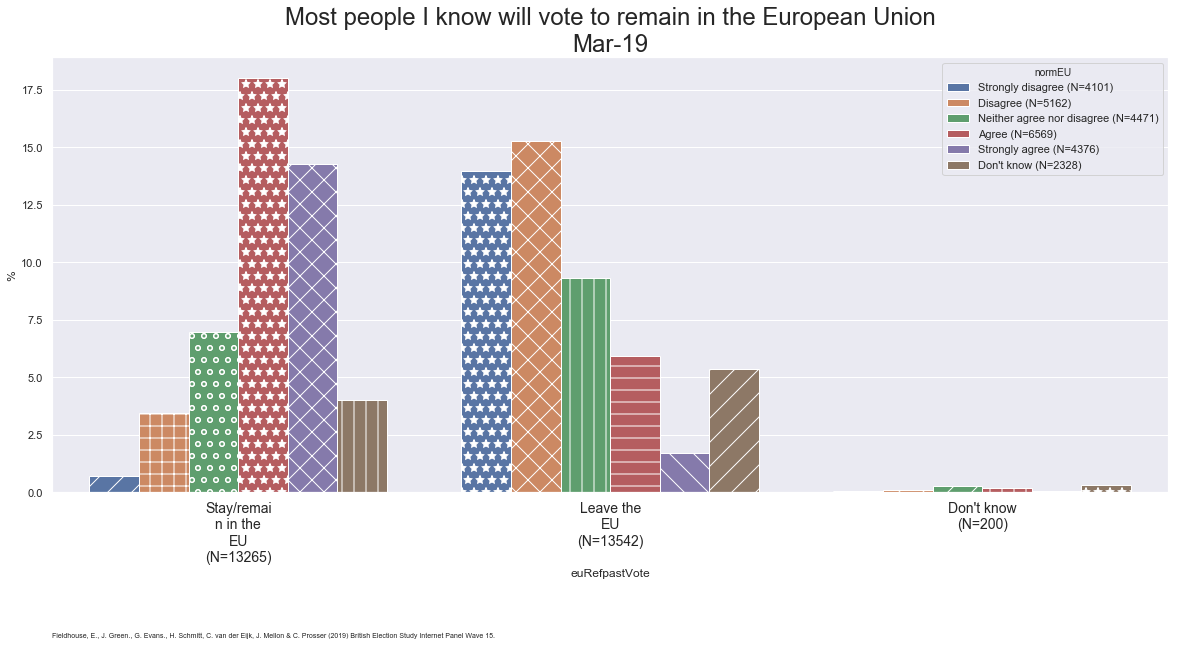

In [112]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 15

var1 ="normEU"
var2 ="euRefpastVote"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Most people I know will vote to remain in the European Union"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

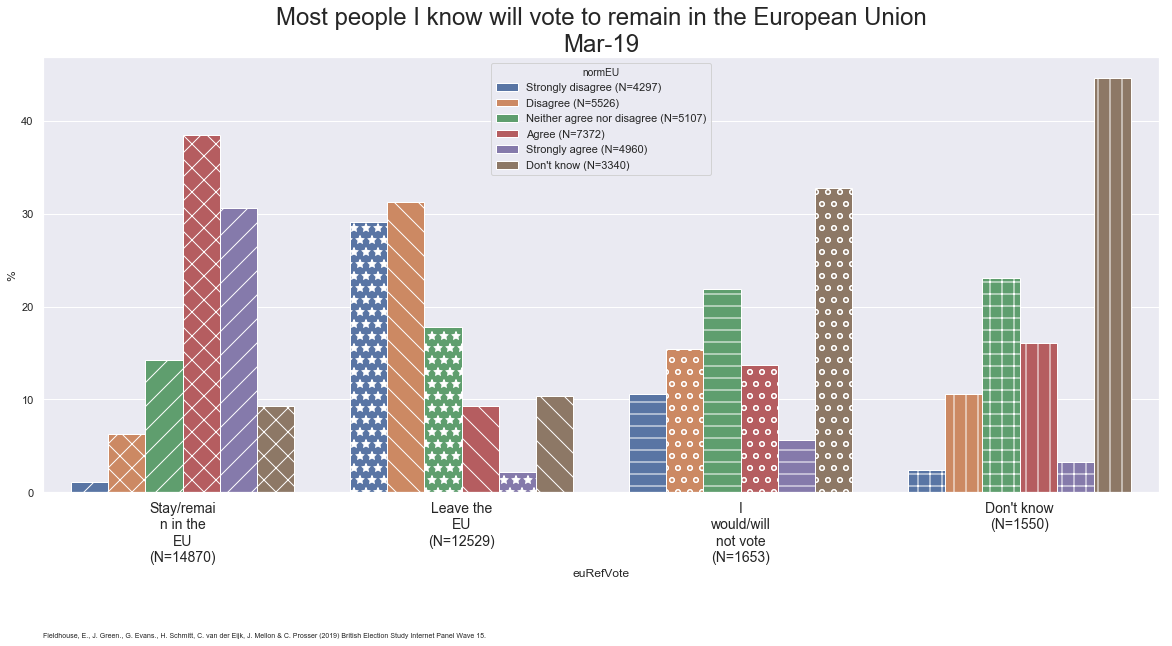

In [116]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 15

var1 ="normEU"
var2 ="euRefVote"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Most people I know will vote to remain in the European Union"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

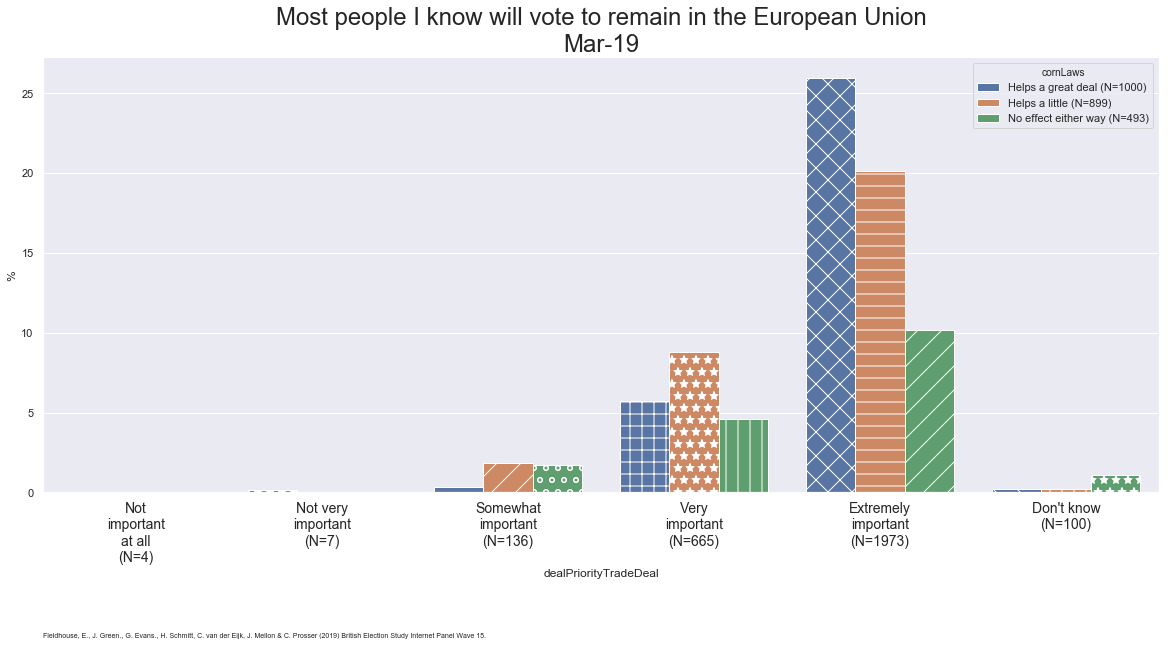

In [230]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var1 ="cornLaws"
var2 ="dealPriorityTradeDeal"


# df2 = govtHandouts
df2 = BES_Panel[var2][mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Most people I know will vote to remain in the European Union"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

Warning, filename truncated because it was over 120. Filenames may no longer be unique


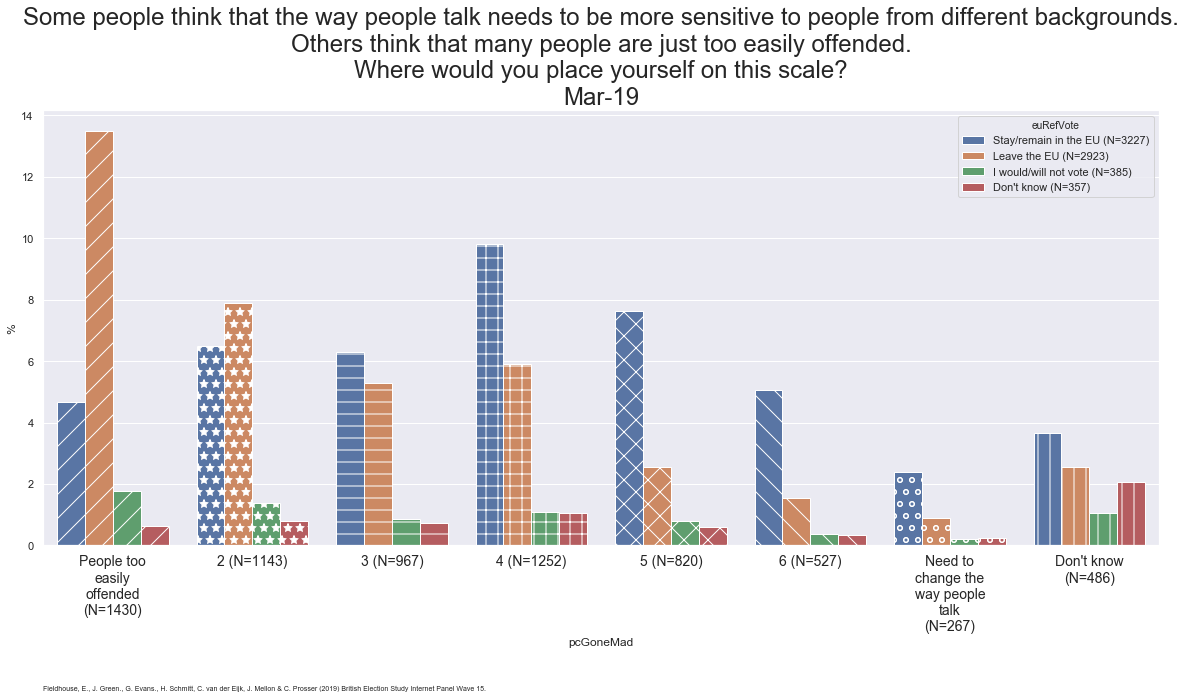

In [295]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var1 ="euRefVote"
var2 ="pcGoneMad"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Some people think that the way people talk needs to be more sensitive to people from different backgrounds.\nOthers think that many people are just too easily offended.\nWhere would you place yourself on this scale?"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

Warning, filename truncated because it was over 120. Filenames may no longer be unique


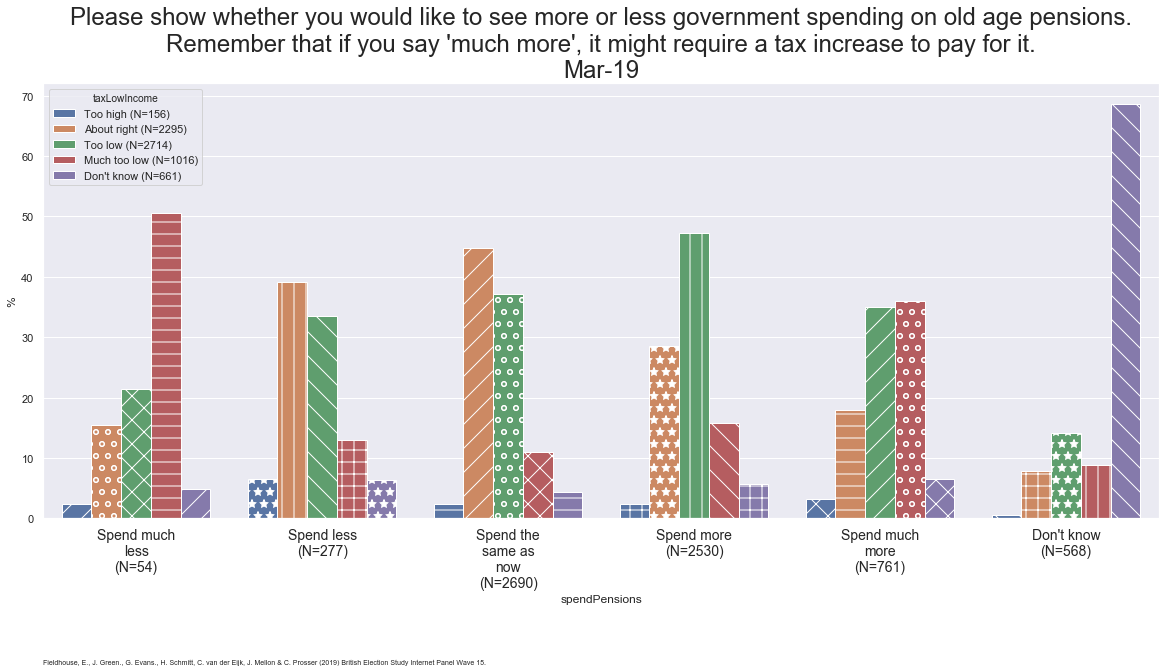

In [310]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var2 ="spendPensions"
var1 ="taxLowIncome"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Please show whether you would like to see more or less government spending on old age pensions.\nRemember that if you say 'much more', it might require a tax increase to pay for it."+"\n"+date)
              
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

Warning, filename truncated because it was over 120. Filenames may no longer be unique


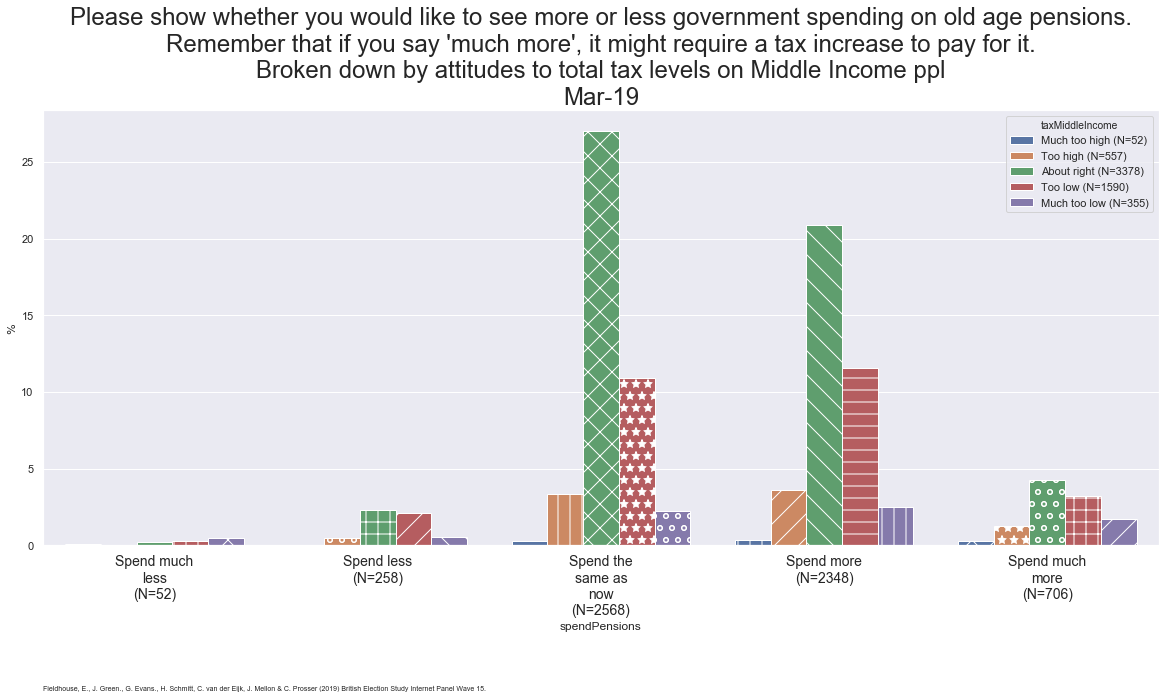

In [321]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var2 ="spendPensions"
var1 ="taxMiddleIncome"


# df2 = govtHandouts
df2 = BES_Panel[var2].replace("Don't know",np.nan).cat.remove_unused_categories()
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1].replace("Don't know",np.nan).cat.remove_unused_categories()
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Please show whether you would like to see more or less government spending on old age pensions.\nRemember that if you say 'much more', it might require a tax increase to pay for it.\nBroken down by attitudes to total tax levels on Middle Income ppl"+"\n"+date)
              
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

Warning, filename truncated because it was over 120. Filenames may no longer be unique


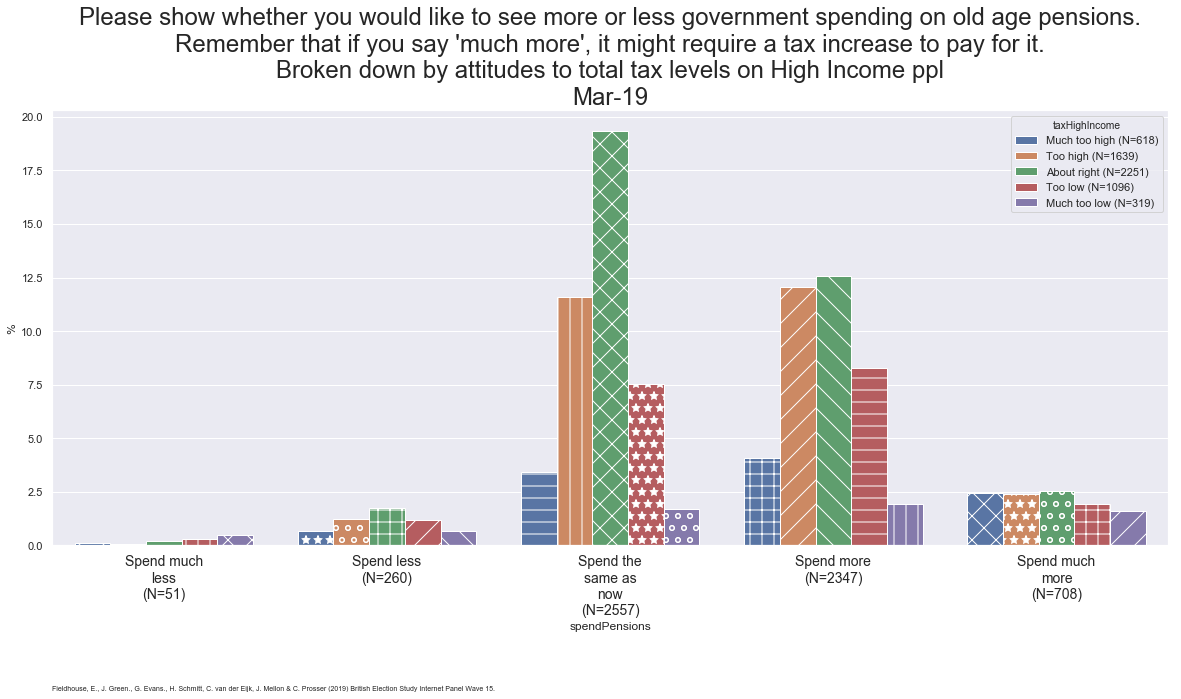

In [319]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var2 ="spendPensions"
var1 ="taxHighIncome"


# df2 = govtHandouts
df2 = BES_Panel[var2].replace("Don't know",np.nan).cat.remove_unused_categories()
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1].replace("Don't know",np.nan).cat.remove_unused_categories()
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Please show whether you would like to see more or less government spending on old age pensions.\nRemember that if you say 'much more', it might require a tax increase to pay for it.\nBroken down by attitudes to total tax levels on High Income ppl"+"\n"+date)
              
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

Warning, filename truncated because it was over 120. Filenames may no longer be unique


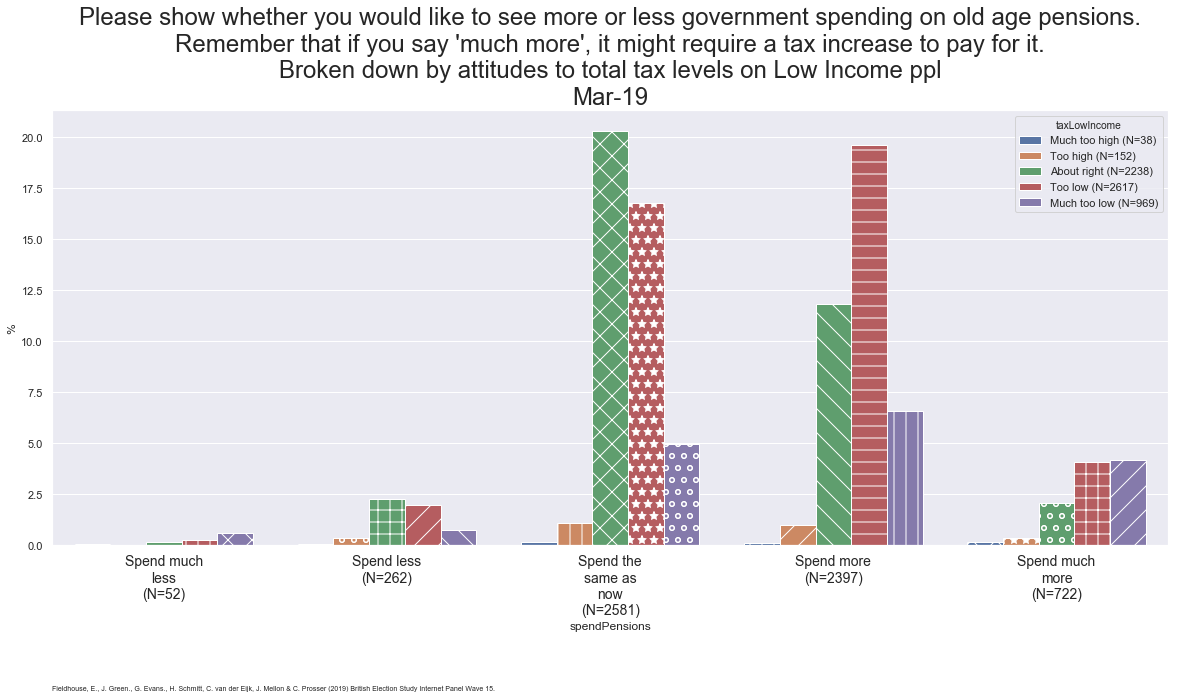

In [317]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var2 ="spendPensions"
var1 ="taxLowIncome"


# df2 = govtHandouts
df2 = BES_Panel[var2].replace("Don't know",np.nan).cat.remove_unused_categories()
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1].replace("Don't know",np.nan).cat.remove_unused_categories()
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Please show whether you would like to see more or less government spending on old age pensions.\nRemember that if you say 'much more', it might require a tax increase to pay for it.\n(Broken down by attitudes to total tax levels on Low Income ppl)"+"\n"+date)
              
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [ ]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var2 ="spendPensions"
var1 ="taxLowIncome"


# df2 = govtHandouts
df2 = BES_Panel[var2].replace("Don't know",np.nan).cat.remove_unused_categories()
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1].replace("Don't know",np.nan).cat.remove_unused_categories()
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Please show whether you would like to see more or less government spending on old age pensions.\nRemember that if you say 'much more', it might require a tax increase to pay for it.\n(Broken down by attitudes to total tax levels on Low Income ppl)"+"\n"+date)
              
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

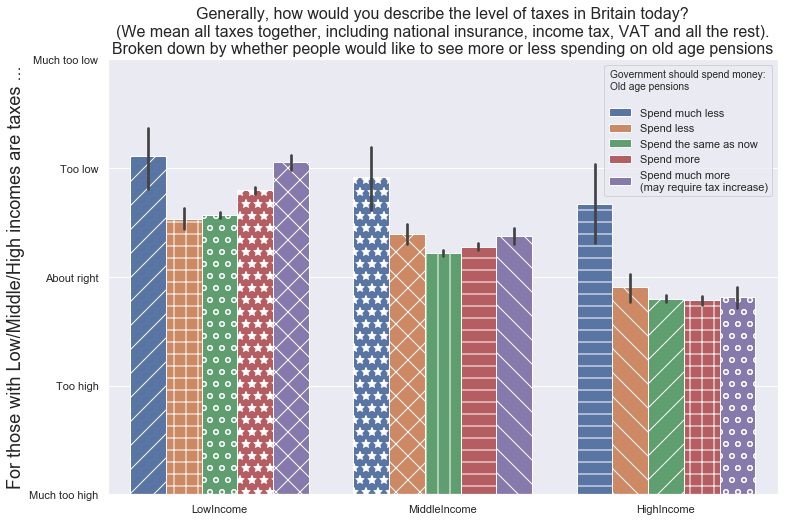

In [344]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"taxLowIncome|taxMiddleIncome|taxHighIncome").index
df = BES_reduced_with_na.set_index("spendPensions__Spend much more")[var_list].stack().reset_index()
ques = "Generally, how would you describe the level of taxes in Britain today?\n(We mean all taxes together, including national insurance, income tax, VAT and all the rest)."
hue = "Government should spend money:\nOld age pensions\n"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].astype('category').cat.rename_categories(['Spend much less', 'Spend less', 'Spend the same as now', 'Spend more',
       'Spend much more\n(may require tax increase)'])

df[ques] = df[ques].apply(lambda x: x.replace("__Much too low","").replace("tax",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

bar = sns.barplot(y = df["values"],
               x = df[ques],
               hue = df[hue],
               order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
# plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1,2,3,4],['Much too high', 'Too high', 'About right', 'Too low', 'Much too low']);
plt.ylabel("For those with Low/Middle/High incomes are taxes ...",fontsize=18);
plt.xlabel("")
plt.title(ques+"\nBroken down by whether people would like to see more or less spending on old age pensions",fontsize=16)
# plt.axhline(.5, linestyle=':');
# plt.title("Unicorn Shooting Gallery",fontsize=40);

hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(next(hatch_cycle))


output_folder = create_subdir(BES_output_folder, "spending_by_tax")
fname = output_folder + "pensions_by_tax" + ".png"
plt.savefig( fname, bbox_inches='tight' )   

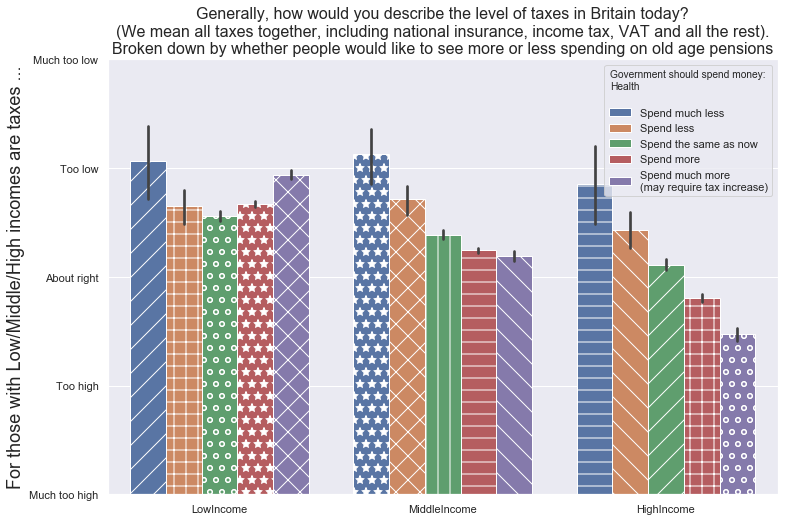

In [347]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"taxLowIncome|taxMiddleIncome|taxHighIncome").index
df = BES_reduced_with_na.set_index("spendHealth__Spend much more")[var_list].stack().reset_index()
ques = "Generally, how would you describe the level of taxes in Britain today?\n(We mean all taxes together, including national insurance, income tax, VAT and all the rest)."
hue = "Government should spend money:\nHealth\n"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].astype('category').cat.rename_categories(['Spend much less', 'Spend less', 'Spend the same as now', 'Spend more',
       'Spend much more\n(may require tax increase)'])

df[ques] = df[ques].apply(lambda x: x.replace("__Much too low","").replace("tax",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

bar = sns.barplot(y = df["values"],
               x = df[ques],
               hue = df[hue],
               order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
# plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1,2,3,4],['Much too high', 'Too high', 'About right', 'Too low', 'Much too low']);
plt.ylabel("For those with Low/Middle/High incomes are taxes ...",fontsize=18);
plt.xlabel("")
plt.title(ques+"\nBroken down by whether people would like to see more or less spending on old age pensions",fontsize=16)
# plt.axhline(.5, linestyle=':');
# plt.title("Unicorn Shooting Gallery",fontsize=40);

hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(next(hatch_cycle))


output_folder = create_subdir(BES_output_folder, "spending_by_tax")
fname = output_folder + "health_by_tax" + ".png"
plt.savefig( fname, bbox_inches='tight' )   

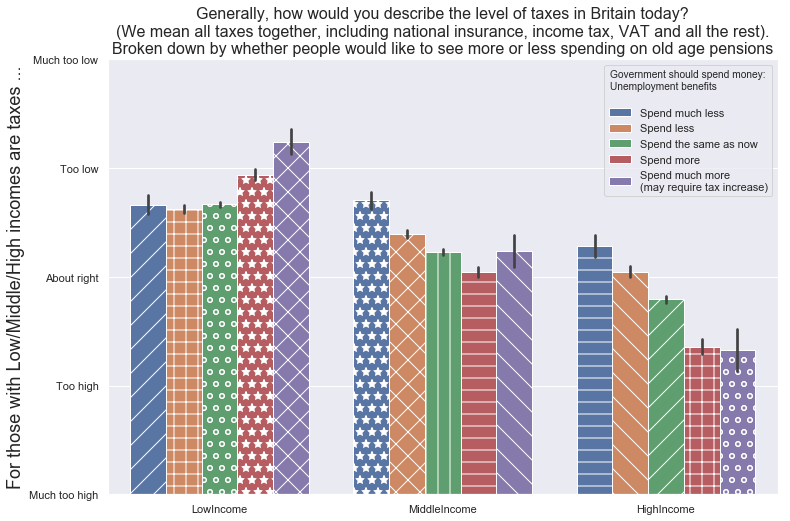

In [357]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"taxLowIncome|taxMiddleIncome|taxHighIncome").index
df = BES_reduced_with_na.set_index("spendUnemp__Spend much more")[var_list].stack().reset_index()
ques = "Generally, how would you describe the level of taxes in Britain today?\n(We mean all taxes together, including national insurance, income tax, VAT and all the rest)."
hue = "Government should spend money:\nUnemployment benefits\n"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].astype('category').cat.rename_categories(['Spend much less', 'Spend less', 'Spend the same as now', 'Spend more',
       'Spend much more\n(may require tax increase)'])

df[ques] = df[ques].apply(lambda x: x.replace("__Much too low","").replace("tax",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

bar = sns.barplot(y = df["values"],
               x = df[ques],
               hue = df[hue],
               order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
# plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1,2,3,4],['Much too high', 'Too high', 'About right', 'Too low', 'Much too low']);
plt.ylabel("For those with Low/Middle/High incomes are taxes ...",fontsize=18);
plt.xlabel("")
plt.title(ques+"\nBroken down by whether people would like to see more or less spending on old age pensions",fontsize=16)
# plt.axhline(.5, linestyle=':');
# plt.title("Unicorn Shooting Gallery",fontsize=40);

hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(next(hatch_cycle))


output_folder = create_subdir(BES_output_folder, "spending_by_tax")
fname = output_folder + "unemployment_benefits_by_tax" + ".png"
plt.savefig( fname, bbox_inches='tight' )   

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


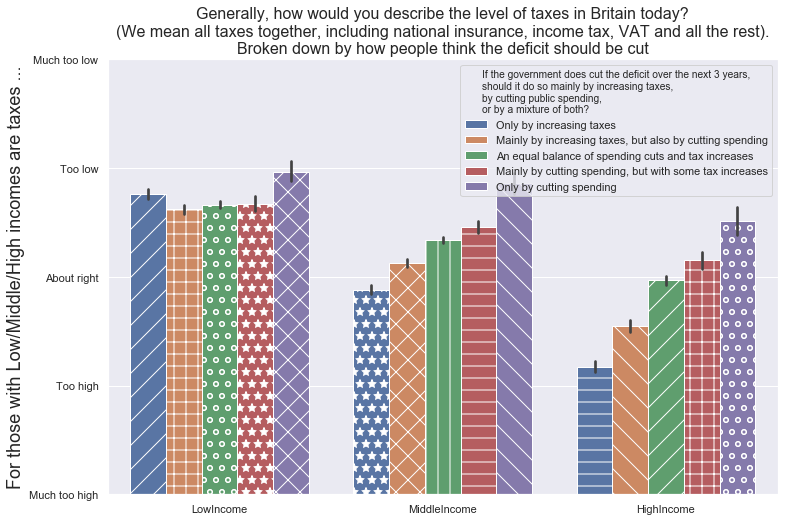

In [57]:
plt.figure(figsize = (12,8))

var_list = search(BES_reduced_with_na,"taxLowIncome|taxMiddleIncome|taxHighIncome").index
df = BES_reduced_with_na.set_index("howToReduceDeficit__Only by cutting spending")[var_list].stack().reset_index()
ques = "Generally, how would you describe the level of taxes in Britain today?\n(We mean all taxes together, including national insurance, income tax, VAT and all the rest)."
hue = "If the government does cut the deficit over the next 3 years,\nshould it do so mainly by increasing taxes,\nby cutting public spending,\nor by a mixture of both?"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].astype('category').cat.rename_categories(['Only by increasing taxes',
       'Mainly by increasing taxes, but also by cutting spending',
       'An equal balance of spending cuts and tax increases',
       'Mainly by cutting spending, but with some tax increases',
       'Only by cutting spending'])

df[ques] = df[ques].apply(lambda x: x.replace("__Much too low","").replace("tax",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

bar = sns.barplot(y = df["values"],
               x = df[ques],
               hue = df[hue],
               order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
# plt.xticks(rotation = 15);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
plt.yticks([0,1,2,3,4],['Much too high', 'Too high', 'About right', 'Too low', 'Much too low']);
plt.ylabel("For those with Low/Middle/High incomes are taxes ...",fontsize=18);
plt.xlabel("")
plt.title(ques+"\nBroken down by how people think the deficit should be cut",fontsize=16)
# plt.axhline(.5, linestyle=':');
# plt.title("Unicorn Shooting Gallery",fontsize=40);

hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(next(hatch_cycle))


output_folder = create_subdir(BES_output_folder, "howtocutdeficit_by_tax")
fname = output_folder + "howtocutdeficit_by_tax" + ".png"
plt.savefig( fname, bbox_inches='tight' )   

In [55]:
BES_Panel["howToReduceDeficit"].cat.categories

Index(['Only by increasing taxes',
       'Mainly by increasing taxes, but also by cutting spending',
       'An equal balance of spending cuts and tax increases',
       'Mainly by cutting spending, but with some tax increases',
       'Only by cutting spending', 'Don't know'],
      dtype='object')

In [355]:
BES_reduced_with_na["spendHealth__Spend much more"].astype('category').cat.rename_categories(['Spend much less', 'Spend less', 'Spend the same as now', 'Spend more',
       'Spend much more\n(may require tax increase)']).value_counts()

Spend more                                     3379
Spend much more\n(may require tax increase)    1596
Spend the same as now                          1185
Spend less                                      151
Spend much less                                  61
Name: spendHealth__Spend much more, dtype: int64

In [353]:
BES_Panel[["taxLowIncome","taxMiddleIncome","taxHighIncome"]].stack().value_counts()

About right      8028
Too low          5543
Too high         2419
Don't know       2198
Much too low     1717
Much too high     735
dtype: int64

In [324]:
BES_Panel["spendPensions"].cat.categories

Index(['Spend much less', 'Spend less', 'Spend the same as now', 'Spend more',
       'Spend much more', 'Don't know'],
      dtype='object')

In [326]:
BES_Panel["taxLowIncome"].cat.categories

Index(['Much too high', 'Too high', 'About right', 'Too low', 'Much too low',
       'Don't know'],
      dtype='object')

In [ ]:
BES_reduced_with_na["spendHealth__Spend much more"]

In [378]:
BES_reduced_with_na[match(BES_reduced_with_na,"like").index[0:12]].mean().sort_values()

likeBatten__Strongly like     2.413460
likeCorbyn__Strongly like     2.679996
likeFarage__Strongly like     3.151816
likeMogg__Strongly like       3.165487
likeSoubry__Strongly like     3.416398
likeBartley__Strongly like    3.422754
likeBerry__Strongly like      3.522687
likeBoris__Strongly like      3.571140
likeMay__Strongly like        3.780475
likeCable__Strongly like      3.823361
likeUmunna__Strongly like     3.924198
likeBerger__Strongly like     4.075332
dtype: float32

In [366]:
df = BES_reduced_with_na[match(BES_reduced_with_na,"spend|tax").index].corr()
df.columns = [x.replace("__","\n") for x in df.columns]
df.index = [x.replace("__","\n") for x in df.index]
df

taxHighIncome\nMuch too low  \
taxHighIncome\nMuch too low                                            1.000000   
taxMiddleIncome\nMuch too low                                          0.553072   
taxLowIncome\nMuch too low                                             0.030593   
spendHealth\nSpend much more                                          -0.246590   
spendPensions\nSpend much more                                        -0.033871   
spendUnemp\nSpend much more                                           -0.258628   
taxSpendSelf\nGovernment should increase taxes ...                    -0.329105   
taxSpendCon\nGovernment should increase taxes a...                     0.227363   
taxSpendLab\nGovernment should increase taxes a...                    -0.023788   

                                                    taxMiddleIncome\nMuch too low  \
taxHighIncome\nMuch too low                                              0.553072   
taxMiddleIncome\nMuch too low                                            1.000000   
taxLowIncome\nMuch too low                                               0.226554   
spendHealth\nSpend much more                                            -0.146241   
spendPensions\nSpend much more                                           0.015745   
spendUnemp\nSpend much more                                             -0.202901   
taxSpendSelf\nGovernment should increase taxes ...                      -0.280121   
taxSpendCon\nGovernment should increase taxes a...                       0.118668   
taxSpendLab\nGovernment should increase taxes a...                      -0.009064   

                                                    taxLowIncome\nMuch too low  \
taxHighIncome\nMuch too low                                           0.030593   
taxMiddleIncome\nMuch too low                                         0.226554   
taxLowIncome\nMuch too low                                            1.000000   
spendHealth\nSpend much more                                          0.131243   
spendPensions\nSpend much more                                        0.181353   
spendUnemp\nSpend much more                                           0.150046   
taxSpendSelf\nGovernment should increase taxes ...                    0.028708   
taxSpendCon\nGovernment should increase taxes a...                    0.021401   
taxSpendLab\nGovernment should increase taxes a...                   -0.044942   

                                                    spendHealth\nSpend much more  \
taxHighIncome\nMuch too low                                            -0.246590   
taxMiddleIncome\nMuch too low                                          -0.146241   
taxLowIncome\nMuch too low                                              0.131243   
spendHealth\nSpend much more                                            1.000000   
spendPensions\nSpend much more                                          0.352667   
spendUnemp\nSpend much more                                             0.270222   
taxSpendSelf\nGovernment should increase taxes ...                      0.427422   
taxSpendCon\nGovernment should increase taxes a...                     -0.116414   
taxSpendLab\nGovernment should increase taxes a...                     -0.026252   

                                                    spendPensions\nSpend much more  \
taxHighIncome\nMuch too low                                              -0.033871   
taxMiddleIncome\nMuch too low                                             0.015745   
taxLowIncome\nMuch too low                                                0.181353   
spendHealth\nSpend much more                                              0.352667   
spendPensions\nSpend much more                                            1.000000   
spendUnemp\nSpend much more                                               0.196172   
taxSpendSelf\nGovernment should increase taxes ...                        0.134360   
taxSpendCon\nGovernm

In [371]:
ct = pd.crosstab( BES_Panel["spendHealth"], BES_Panel["taxHighIncome"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='all')*100 
ct

taxHighIncome          Much too high   Too high  About right   Too low  \
spendHealth                                                              
Spend much less             0.024131   0.143005     0.118576  0.165771   
Spend less                  0.134080   0.256571     0.734028  0.920167   
Spend the same as now       0.518457   2.659169     8.137156  3.907836   
Spend more                  3.389189  13.402244    16.871420  8.296266   
Spend much more             4.922900   6.542010     4.301015  2.851064   
Don't know                  0.367802   0.497109     0.644307  0.710861   

taxHighIncome          Much too low  Don't know  
spendHealth                                      
Spend much less            0.324864    0.307696  
Spend less                 0.265078    0.019841  
Spend the same as now      0.816945    0.990879  
Spend more                 1.927581    3.602800  
Spend much more            1.867473    1.317504  
Don't know                 0.510170    7.534034

In [81]:
ct = pd.crosstab( BES_Panel["howToReduceDeficit"], BES_Panel["taxHighIncome"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='all')*100 
ct

taxHighIncome                                       Much too high  Too high  \
howToReduceDeficit                                                            
Only by increasing taxes                                 3.485557  5.665629   
Mainly by increasing taxes, but also by cutting...       1.568582  5.182248   
An equal balance of spending cuts and tax incre...       2.021667  6.954423   
Mainly by cutting spending, but with some tax i...       0.396333  1.187386   
Only by cutting spending                                 0.305874  0.712405   
Don't know                                               1.578548  3.798018   

taxHighIncome                                       About right   Too low  \
howToReduceDeficit                                                          
Only by increasing taxes                               3.006295  1.061769   
Mainly by increasing taxes, but also by cutting...     4.934169  1.463809   
An equal balance of spending cuts and tax incre...    14.529474  6.648025   
Mainly by cutting spending, but with some tax i...     2.966069  2.399650   
Only by cutting spending                               1.366581  1.603957   
Don't know                                             4.003914  3.674754   

taxHighIncome                                       Much too low  Don't know  
howToReduceDeficit                                                            
Only by increasing taxes                                0.184243    0.785493  
Mainly by increasing taxes, but also by cutting...      0.390608    0.689934  
An equal balance of spending cuts and tax incre...      1.509786    1.900150  
Mainly by cutting spending, but with some tax i...      0.301813    0.421419  
Only by cutting spending                                1.296502    0.355142  
Don't know                                              2.029158    9.620616

In [83]:
BES_PanelW15_strings = pd.read_stata("C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_data\\W15_comb_strings\\BES2019_W15Strings_v0.1.dta")

In [90]:
BES_PanelW15_strings.columns

Index(['id', 'MII_textW1', 'bestOnMIIOthW1', 'generalElectionVoteOthW1',
       'generalElectionVoteOthW2', 'generalElectionVoteOthW3',
       'generalElectionVoteOthW4', 'generalElectionVoteOthW5',
       'generalElectionVotePostOthW5', 'generalElectionVoteOthW6',
       ...
       'welshElectionVoteListOthW15', 'partyMemberPastOthW15',
       'partyMemberNowOthW15', 'othSubjClassW15', 'pcon',
       'othSubjClassW2_W4W7W9', 'othSubjClassW10W11', 'othSubjClassW12W14',
       'genElecOthCodedW15', 'genElecOthCodedTIGW15'],
      dtype='object', length=211)

In [91]:
BES_PanelW15_only = pd.read_stata("C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_data\\W15_only\\BES2019_W15_v0.2.dta")

In [384]:
search(BES_reduced_with_na,"sdoantiegal1")

sdoantiegal1__Strongly favour    6146
dtype: int64

In [ ]:
# sdodominance1|sdodominance2|sdodominance3|sdodominance4|sdoantiegal1|sdoantiegal2|sdoantiegal3|sdoantiegal4

In [380]:
pattern = "sdodominance1__Strongly favour"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for sdodominance1__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdodominance2__Strongly favour 
 0.6 
 0.00 
 6071 
 
 sdoantiegal2__Strongly favour 
 0.49 
 0.00 
 5827 
 
 leftRight__Right 
 0.42 
 0.00 
 5117 
 
 likeCon__Strongly like 
 0.35 
 0.00 
 5982 
 
 ptvCon__Very likely 
 0.35 
 0.00 
 5798 
 
 sdoantiegal1__Strongly favour 
 0.34 
 0.00 
 5869 
 
 redistSelf__Government should be less concerned[...] 
 0.34 
 0.00 
 5667 
 
 generalElectionVote_Conservative 
 0.33 
 0.00 
 4145 
 
 generalElectionVoteTIG_Conservative 
 0.33 
 0.00 
 4230 
 
 pastvote_2017_Conservative 
 0.31 
 0.00 
 5396 
 
 profile_past_vote_2017_Conservative 
 0.31 
 0.00 
 4105 
 
 blackEquality__Gone much too far 
 0.3 
 0.00 
 955 
 
 partyIdTIG_Conservative 
 0.3 
 0.00 
 5665 
 
 partyId_Conservative 
 0.29 
 0.00 
 5808 
 
 poorEcon__Got a lot better 
 0.28 
 0.00 
 5643 
 
 lr_scaleW14__Right 
 0.28 
 0.00 
 4726 
 
 likeMogg__Strongly like 
 0.28 
 0.00 
 5270 
 
 likeBrexitParty__Strongly like 
 0.27 
 0.00 
 4379 
 
 likeUKIP__Strongly like 
 0.27 
 0.00 
 5912 
 
 likeBoris__Strongly like 
 0.27 
 0.00 
 6002 
 
 
 Top 20 negative (spearman) correlations for sdodominance1__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdoantiegal3__Strongly favour 
 -0.44 
 0.00 
 5964 
 
 sdodominance4__Strongly favour 
 -0.4 
 0.00 
 6074 
 
 sdodominance3__Strongly favour 
 -0.39 
 0.00 
 6089 
 
 sdoantiegal4__Strongly favour 
 -0.37 
 0.00 
 6078 
 
 lr1W14__Strongly agree 
 -0.31 
 0.00 
 4883 
 
 ptvLab__Very likely 
 -0.29 
 0.00 
 5793 
 
 generalElectionVoteTIG_Labour 
 -0.28 
 0.00 
 4230 
 
 pastvote_2017_Labour 
 -0.28 
 0.00 
 5396 
 
 lr3W14__Strongly agree 
 -0.28 
 0.00 
 4932 
 
 generalElectionVote_Labour 
 -0.28 
 0.00 
 4145 
 
 likeCorbyn__Strongly like 
 -0.27 
 0.00 
 6016 
 
 profile_past_vote_2017_Labour 
 -0.27 
 0.00 
 4105 
 
 likeGrn__Strongly like 
 -0.26 
 0.00 
 5631 
 
 immigCultural__Enriches cultural life 
 -0.26 
 0.00 
 5962 
 
 likeLab__Strongly like 
 -0.26 
 0.00 
 5984 
 
 echr__Strongly agree 
 -0.25 
 0.00 
 5836 
 
 euRefDoOver_Yes 
 -0.24 
 0.00 
 5783 
 
 euLeaveBigBusiness__Much more likely 
 -0.24 
 0.00 
 5659 
 
 dealVremain_Remain in the EU 
 -0.24 
 0.00 
 4877 
 
 remainVnodeal_Remain in the EU 
 -0.23 
 0.00 
 5552

In [381]:
pattern = "sdodominance2__Strongly favour"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for sdodominance2__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdodominance1__Strongly favour 
 0.6 
 0.00 
 6071 
 
 sdoantiegal2__Strongly favour 
 0.46 
 0.00 
 5920 
 
 blackEquality__Gone much too far 
 0.4 
 0.00 
 968 
 
 leftRight__Right 
 0.39 
 0.00 
 5202 
 
 gayEquality__Gone much too far 
 0.34 
 0.00 
 972 
 
 al_scaleW14__Authoritarian 
 0.33 
 0.00 
 4689 
 
 likeUKIP__Strongly like 
 0.33 
 0.00 
 6037 
 
 al2W14__Strongly agree 
 0.33 
 0.00 
 4955 
 
 euPriorityBalance__Control immigration 
 0.32 
 0.00 
 5649 
 
 strongLeader__Strongly agree 
 0.31 
 0.00 
 6005 
 
 femaleEquality__Gone much too far 
 0.31 
 0.00 
 1003 
 
 likeFarage__Strongly like 
 0.31 
 0.00 
 6093 
 
 emEcon__Got a lot better 
 0.3 
 0.00 
 4876 
 
 likeBrexitParty__Strongly like 
 0.29 
 0.00 
 4454 
 
 likeCon__Strongly like 
 0.29 
 0.00 
 6106 
 
 noDealShortTerm__Extremely good 
 0.29 
 0.00 
 5666 
 
 effectsEUEcon__Much better 
 0.29 
 0.00 
 5943 
 
 dealPriorityImmig__Extremely important 
 0.29 
 0.00 
 6004 
 
 dealPriorityRedTape__Extremely important 
 0.28 
 0.00 
 5939 
 
 noDealLongTerm__Extremely good 
 0.28 
 0.00 
 5502 
 
 
 Top 20 negative (spearman) correlations for sdodominance2__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdodominance4__Strongly favour 
 -0.52 
 0.00 
 6215 
 
 sdoantiegal4__Strongly favour 
 -0.48 
 0.00 
 6215 
 
 sdoantiegal3__Strongly favour 
 -0.48 
 0.00 
 6101 
 
 sdodominance3__Strongly favour 
 -0.4 
 0.00 
 6239 
 
 immigCultural__Enriches cultural life 
 -0.35 
 0.00 
 6091 
 
 warmMuslim__Very warm 
 -0.35 
 0.00 
 5730 
 
 immigSelf__Allow many more 
 -0.32 
 0.00 
 5891 
 
 immigEcon__Good for economy 
 -0.32 
 0.00 
 6052 
 
 echr__Strongly agree 
 -0.28 
 0.00 
 5928 
 
 ptvLab__Very likely 
 -0.27 
 0.00 
 5913 
 
 leaveImpactBritain__A very large impact 
 -0.27 
 0.00 
 5981 
 
 euLeaveBigBusiness__Much more likely 
 -0.27 
 0.00 
 5762 
 
 likeGrn__Strongly like 
 -0.27 
 0.00 
 5737 
 
 remainVnodeal_Remain in the EU 
 -0.27 
 0.00 
 5670 
 
 dealVremain_Remain in the EU 
 -0.26 
 0.00 
 4981 
 
 euRefDoOver_Yes 
 -0.25 
 0.00 
 5899 
 
 likeLab__Strongly like 
 -0.25 
 0.00 
 6106 
 
 lrUKIP__Right 
 -0.25 
 0.00 
 4865 
 
 pastvote_2017_Labour 
 -0.24 
 0.00 
 5510 
 
 generalElectionVoteTIG_Labour 
 -0.24 
 0.00 
 4299

In [382]:
pattern = "sdodominance3__Strongly favour"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for sdodominance3__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdodominance4__Strongly favour 
 0.51 
 0.00 
 6316 
 
 sdoantiegal3__Strongly favour 
 0.44 
 0.00 
 6177 
 
 sdoantiegal4__Strongly favour 
 0.43 
 0.00 
 6318 
 
 lr1W14__Strongly agree 
 0.23 
 0.00 
 5071 
 
 lr3W14__Strongly agree 
 0.22 
 0.00 
 5138 
 
 likeGrn__Strongly like 
 0.21 
 0.00 
 5823 
 
 immigCultural__Enriches cultural life 
 0.2 
 0.00 
 6198 
 
 lr2W14__Strongly agree 
 0.2 
 0.00 
 5148 
 
 lr4W14__Strongly agree 
 0.2 
 0.00 
 5176 
 
 profile_past_vote_2017_Labour 
 0.19 
 0.00 
 4269 
 
 grnUnited__Very united 
 0.19 
 0.00 
 4294 
 
 likeLab__Strongly like 
 0.19 
 0.00 
 6212 
 
 warmMuslim__Very warm 
 0.19 
 0.00 
 5825 
 
 immigEcon__Good for economy 
 0.19 
 0.00 
 6167 
 
 ptvLab__Very likely 
 0.19 
 0.00 
 6004 
 
 pastvote_2017_Labour 
 0.18 
 0.00 
 5599 
 
 prPreference_That every party's percentage of[...] 
 0.18 
 0.00 
 5190 
 
 dealPriorityNIEireBorder__Extremely important 
 0.18 
 0.00 
 5917 
 
 ptvGrn__Very likely 
 0.18 
 0.00 
 5908 
 
 euLeaveBigBusiness__Much more likely 
 0.18 
 0.00 
 5861 
 
 
 Top 20 negative (spearman) correlations for sdodominance3__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdodominance2__Strongly favour 
 -0.4 
 0.00 
 6239 
 
 sdodominance1__Strongly favour 
 -0.39 
 0.00 
 6089 
 
 sdoantiegal2__Strongly favour 
 -0.32 
 0.00 
 5995 
 
 leftRight__Right 
 -0.29 
 0.00 
 5256 
 
 generalElectionVoteTIG_Conservative 
 -0.24 
 0.00 
 4365 
 
 generalElectionVote_Conservative 
 -0.24 
 0.00 
 4268 
 
 lr_scaleW14__Right 
 -0.24 
 0.00 
 4899 
 
 poorEcon__Got a lot better 
 -0.24 
 0.00 
 5835 
 
 ptvCon__Very likely 
 -0.23 
 0.00 
 6006 
 
 redistSelf__Government should be less concerned[...] 
 -0.22 
 0.00 
 5866 
 
 likeCon__Strongly like 
 -0.22 
 0.00 
 6208 
 
 profile_past_vote_2017_Conservative 
 -0.22 
 0.00 
 4269 
 
 partyIdTIG_Conservative 
 -0.21 
 0.00 
 5899 
 
 euPriorityBalance__Control immigration 
 -0.21 
 0.00 
 5741 
 
 pastvote_2017_Conservative 
 -0.21 
 0.00 
 5599 
 
 likeUKIP__Strongly like 
 -0.2 
 0.00 
 6138 
 
 partyId_Conservative 
 -0.2 
 0.00 
 6041 
 
 likeMogg__Strongly like 
 -0.2 
 0.00 
 5433 
 
 effectsEUNHS__Much better 
 -0.19 
 0.00 
 6029 
 
 effectsEUEcon__Much better 
 -0.19 
 0.00 
 6040

In [383]:
pattern = "sdodominance4__Strongly favour"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for sdodominance4__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdoantiegal3__Strongly favour 
 0.58 
 0.00 
 6167 
 
 sdoantiegal4__Strongly favour 
 0.58 
 0.00 
 6305 
 
 sdodominance3__Strongly favour 
 0.51 
 0.00 
 6316 
 
 warmMuslim__Very warm 
 0.31 
 0.00 
 5808 
 
 immigCultural__Enriches cultural life 
 0.26 
 0.00 
 6173 
 
 lr3W14__Strongly agree 
 0.25 
 0.00 
 5120 
 
 lr1W14__Strongly agree 
 0.24 
 0.00 
 5056 
 
 immigEcon__Good for economy 
 0.24 
 0.00 
 6145 
 
 likeGrn__Strongly like 
 0.24 
 0.00 
 5809 
 
 warmJewish__Very warm 
 0.23 
 0.00 
 5811 
 
 dealPriorityNIEireBorder__Extremely important 
 0.23 
 0.00 
 5887 
 
 immigSelf__Allow many more 
 0.23 
 0.00 
 5975 
 
 leaveImpactBritain__A very large impact 
 0.22 
 0.00 
 6054 
 
 lrCon__Right 
 0.22 
 0.00 
 5121 
 
 lr2W14__Strongly agree 
 0.21 
 0.00 
 5131 
 
 dealPriorityMarketAccess__Extremely important 
 0.21 
 0.00 
 6073 
 
 lr4W14__Strongly agree 
 0.21 
 0.00 
 5166 
 
 likeLab__Strongly like 
 0.21 
 0.00 
 6200 
 
 generalElectionVote_Labour 
 0.21 
 0.00 
 4255 
 
 pastvote_2017_Labour 
 0.21 
 0.00 
 5588 
 
 
 Top 20 negative (spearman) correlations for sdodominance4__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdodominance2__Strongly favour 
 -0.52 
 0.00 
 6215 
 
 sdodominance1__Strongly favour 
 -0.4 
 0.00 
 6074 
 
 sdoantiegal2__Strongly favour 
 -0.39 
 0.00 
 5992 
 
 leftRight__Right 
 -0.33 
 0.00 
 5237 
 
 poorEcon__Got a lot better 
 -0.31 
 0.00 
 5815 
 
 femaleEquality__Gone much too far 
 -0.28 
 0.00 
 1007 
 
 redistSelf__Government should be less concerned[...] 
 -0.26 
 0.00 
 5843 
 
 lr_scaleW14__Right 
 -0.26 
 0.00 
 4891 
 
 ptvCon__Very likely 
 -0.25 
 0.00 
 5991 
 
 blackEquality__Gone much too far 
 -0.25 
 0.00 
 973 
 
 wcEcon__Got a lot better 
 -0.25 
 0.00 
 5774 
 
 euPriorityBalance__Control immigration 
 -0.24 
 0.00 
 5712 
 
 ukCoopWorkers__Bad for Britain 
 -0.24 
 0.00 
 5710 
 
 likeUKIP__Strongly like 
 -0.23 
 0.00 
 6124 
 
 gayEquality__Gone much too far 
 -0.23 
 0.00 
 977 
 
 emEcon__Got a lot better 
 -0.23 
 0.00 
 4934 
 
 generalElectionVoteTIG_Conservative 
 -0.23 
 0.00 
 4344 
 
 likeCon__Strongly like 
 -0.23 
 0.00 
 6196 
 
 likeFarage__Strongly like 
 -0.23 
 0.00 
 6174 
 
 profile_past_vote_2017_Conservative 
 -0.22 
 0.00 
 4267

In [385]:
pattern = "sdoantiegal1__Strongly favour"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for sdoantiegal1__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdoantiegal2__Strongly favour 
 0.48 
 0.00 
 5914 
 
 sdodominance1__Strongly favour 
 0.34 
 0.00 
 5869 
 
 leftRight__Right 
 0.31 
 0.00 
 5063 
 
 blackEquality__Gone much too far 
 0.31 
 0.00 
 945 
 
 redistSelf__Government should be less concerned[...] 
 0.28 
 0.00 
 5636 
 
 sdodominance2__Strongly favour 
 0.27 
 0.00 
 5971 
 
 pastvote_2017_Conservative 
 0.27 
 0.00 
 5338 
 
 likeCon__Strongly like 
 0.26 
 0.00 
 5936 
 
 conLookAfterMuslims__Very closely 
 0.26 
 0.00 
 3958 
 
 ptvCon__Very likely 
 0.26 
 0.00 
 5741 
 
 profile_past_vote_2017_Conservative 
 0.26 
 0.00 
 4065 
 
 gayEquality__Gone much too far 
 0.25 
 0.00 
 948 
 
 noDealLongTerm__Extremely good 
 0.24 
 0.00 
 5372 
 
 generalElectionVoteTIG_Conservative 
 0.24 
 0.00 
 4213 
 
 emEcon__Got a lot better 
 0.24 
 0.00 
 4804 
 
 generalElectionVote_Conservative 
 0.24 
 0.00 
 4117 
 
 EUIntegrationSelf__Protect our independence 
 0.24 
 0.00 
 5903 
 
 willOfPeople__Strongly agree 
 0.23 
 0.00 
 5987 
 
 partyIdTIG_Conservative 
 0.23 
 0.00 
 5641 
 
 euPriorityBalance__Control immigration 
 0.23 
 0.00 
 5507 
 
 
 Top 20 negative (spearman) correlations for sdoantiegal1__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdoantiegal3__Strongly favour 
 -0.31 
 0.00 
 5988 
 
 lr1W14__Strongly agree 
 -0.27 
 0.00 
 4858 
 
 ptvLab__Very likely 
 -0.26 
 0.00 
 5743 
 
 pastvote_2017_Labour 
 -0.25 
 0.00 
 5338 
 
 likeCorbyn__Strongly like 
 -0.25 
 0.00 
 5980 
 
 likeLab__Strongly like 
 -0.25 
 0.00 
 5941 
 
 profile_past_vote_2017_Labour 
 -0.25 
 0.00 
 4065 
 
 echr__Strongly agree 
 -0.25 
 0.00 
 5793 
 
 immigCultural__Enriches cultural life 
 -0.24 
 0.00 
 5920 
 
 dealVremain_Remain in the EU 
 -0.23 
 0.00 
 4835 
 
 likeGrn__Strongly like 
 -0.23 
 0.00 
 5584 
 
 immigSelf__Allow many more 
 -0.23 
 0.00 
 5735 
 
 remainVnodeal_Remain in the EU 
 -0.22 
 0.00 
 5513 
 
 handleEUNegotiateLab__Very well 
 -0.22 
 0.00 
 5655 
 
 generalElectionVote_Labour 
 -0.22 
 0.00 
 4117 
 
 ptvGrn__Very likely 
 -0.22 
 0.00 
 5660 
 
 generalElectionVoteTIG_Labour 
 -0.21 
 0.00 
 4213 
 
 euRefDoOver_Yes 
 -0.21 
 0.00 
 5741 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 -0.21 
 0.00 
 5482 
 
 euLeaveBigBusiness__Much more likely 
 -0.21 
 0.00 
 5612

In [386]:
pattern = "sdoantiegal2__Strongly favour"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for sdoantiegal2__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdodominance1__Strongly favour 
 0.49 
 0.00 
 5827 
 
 sdoantiegal1__Strongly favour 
 0.48 
 0.00 
 5914 
 
 leftRight__Right 
 0.47 
 0.00 
 5026 
 
 sdodominance2__Strongly favour 
 0.46 
 0.00 
 5920 
 
 redistSelf__Government should be less concerned[...] 
 0.43 
 0.00 
 5582 
 
 blackEquality__Gone much too far 
 0.42 
 0.00 
 934 
 
 ptvCon__Very likely 
 0.37 
 0.00 
 5699 
 
 pastvote_2017_Conservative 
 0.37 
 0.00 
 5298 
 
 gayEquality__Gone much too far 
 0.37 
 0.00 
 937 
 
 likeCon__Strongly like 
 0.36 
 0.00 
 5882 
 
 profile_past_vote_2017_Conservative 
 0.36 
 0.00 
 4030 
 
 femaleEquality__Gone much too far 
 0.35 
 0.00 
 965 
 
 generalElectionVote_Conservative 
 0.34 
 0.00 
 4086 
 
 likeMogg__Strongly like 
 0.34 
 0.00 
 5176 
 
 lr_scaleW14__Right 
 0.34 
 0.00 
 4652 
 
 generalElectionVoteTIG_Conservative 
 0.34 
 0.00 
 4182 
 
 likeBoris__Strongly like 
 0.33 
 0.00 
 5908 
 
 likeBrexitParty__Strongly like 
 0.33 
 0.00 
 4355 
 
 poorEcon__Got a lot better 
 0.33 
 0.00 
 5563 
 
 effectsEUEcon__Much better 
 0.33 
 0.00 
 5739 
 
 
 Top 20 negative (spearman) correlations for sdoantiegal2__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdoantiegal3__Strongly favour 
 -0.53 
 0.00 
 5963 
 
 lr1W14__Strongly agree 
 -0.39 
 0.00 
 4802 
 
 sdoantiegal4__Strongly favour 
 -0.39 
 0.00 
 6022 
 
 sdodominance4__Strongly favour 
 -0.39 
 0.00 
 5992 
 
 ptvLab__Very likely 
 -0.36 
 0.00 
 5696 
 
 echr__Strongly agree 
 -0.35 
 0.00 
 5732 
 
 likeLab__Strongly like 
 -0.35 
 0.00 
 5888 
 
 pastvote_2017_Labour 
 -0.34 
 0.00 
 5298 
 
 generalElectionVote_Labour 
 -0.34 
 0.00 
 4086 
 
 likeCorbyn__Strongly like 
 -0.34 
 0.00 
 5928 
 
 profile_past_vote_2017_Labour 
 -0.33 
 0.00 
 4030 
 
 generalElectionVoteTIG_Labour 
 -0.33 
 0.00 
 4182 
 
 sdodominance3__Strongly favour 
 -0.32 
 0.00 
 5995 
 
 likeGrn__Strongly like 
 -0.32 
 0.00 
 5547 
 
 lr3W14__Strongly agree 
 -0.32 
 0.00 
 4849 
 
 immigCultural__Enriches cultural life 
 -0.32 
 0.00 
 5875 
 
 remainVnodeal_Remain in the EU 
 -0.32 
 0.00 
 5467 
 
 dealVremain_Remain in the EU 
 -0.31 
 0.00 
 4792 
 
 euRefDoOver_Yes 
 -0.3 
 0.00 
 5682 
 
 immigSelf__Allow many more 
 -0.3 
 0.00 
 5696

In [387]:
pattern = "sdoantiegal3__Strongly favour"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for sdoantiegal3__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdoantiegal4__Strongly favour 
 0.71 
 0.00 
 6250 
 
 sdodominance4__Strongly favour 
 0.58 
 0.00 
 6167 
 
 sdodominance3__Strongly favour 
 0.44 
 0.00 
 6177 
 
 immigCultural__Enriches cultural life 
 0.4 
 0.00 
 6051 
 
 lr1W14__Strongly agree 
 0.37 
 0.00 
 4957 
 
 likeGrn__Strongly like 
 0.36 
 0.00 
 5707 
 
 warmMuslim__Very warm 
 0.36 
 0.00 
 5709 
 
 immigEcon__Good for economy 
 0.35 
 0.00 
 6026 
 
 echr__Strongly agree 
 0.35 
 0.00 
 5894 
 
 immigSelf__Allow many more 
 0.35 
 0.00 
 5865 
 
 ptvLab__Very likely 
 0.35 
 0.00 
 5871 
 
 likeLab__Strongly like 
 0.34 
 0.00 
 6074 
 
 leaveImpactBritain__A very large impact 
 0.33 
 0.00 
 5938 
 
 euLeaveBigBusiness__Much more likely 
 0.33 
 0.00 
 5731 
 
 remainVnodeal_Remain in the EU 
 0.33 
 0.00 
 5633 
 
 dealVremain_Remain in the EU 
 0.32 
 0.00 
 4951 
 
 likeCorbyn__Strongly like 
 0.32 
 0.00 
 6106 
 
 lr3W14__Strongly agree 
 0.32 
 0.00 
 5004 
 
 pastvote_2017_Labour 
 0.32 
 0.00 
 5466 
 
 delayOrNoDeal_Delay Brexit until parliament can[...] 
 0.31 
 0.00 
 5599 
 
 
 Top 20 negative (spearman) correlations for sdoantiegal3__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdoantiegal2__Strongly favour 
 -0.53 
 0.00 
 5963 
 
 sdodominance2__Strongly favour 
 -0.48 
 0.00 
 6101 
 
 leftRight__Right 
 -0.45 
 0.00 
 5154 
 
 sdodominance1__Strongly favour 
 -0.44 
 0.00 
 5964 
 
 blackEquality__Gone much too far 
 -0.42 
 0.00 
 961 
 
 redistSelf__Government should be less concerned[...] 
 -0.4 
 0.00 
 5750 
 
 ukCoopWorkers__Bad for Britain 
 -0.36 
 0.00 
 5625 
 
 gayEquality__Gone much too far 
 -0.36 
 0.00 
 965 
 
 likeUKIP__Strongly like 
 -0.36 
 0.00 
 6009 
 
 emEcon__Got a lot better 
 -0.35 
 0.00 
 4869 
 
 poorEcon__Got a lot better 
 -0.35 
 0.00 
 5720 
 
 lr_scaleW14__Right 
 -0.35 
 0.00 
 4791 
 
 likeFarage__Strongly like 
 -0.35 
 0.00 
 6050 
 
 euPriorityBalance__Control immigration 
 -0.35 
 0.00 
 5618 
 
 EUIntegrationSelf__Protect our independence 
 -0.34 
 0.00 
 6025 
 
 noDealLongTerm__Extremely good 
 -0.34 
 0.00 
 5476 
 
 pastvote_2017_Conservative 
 -0.34 
 0.00 
 5466 
 
 ptvCon__Very likely 
 -0.34 
 0.00 
 5871 
 
 euID_The leave side 
 -0.33 
 0.00 
 5704 
 
 likeMogg__Strongly like 
 -0.33 
 0.00 
 5324

In [388]:
pattern = "sdoantiegal4__Strongly favour"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for sdoantiegal4__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdoantiegal3__Strongly favour 
 0.71 
 0.00 
 6250 
 
 sdodominance4__Strongly favour 
 0.58 
 0.00 
 6305 
 
 sdodominance3__Strongly favour 
 0.43 
 0.00 
 6318 
 
 immigCultural__Enriches cultural life 
 0.39 
 0.00 
 6191 
 
 warmMuslim__Very warm 
 0.37 
 0.00 
 5838 
 
 immigEcon__Good for economy 
 0.36 
 0.00 
 6166 
 
 immigSelf__Allow many more 
 0.35 
 0.00 
 5999 
 
 likeGrn__Strongly like 
 0.32 
 0.00 
 5825 
 
 euLeaveBigBusiness__Much more likely 
 0.31 
 0.00 
 5857 
 
 leaveImpactBritain__A very large impact 
 0.31 
 0.00 
 6076 
 
 remainVnodeal_Remain in the EU 
 0.29 
 0.00 
 5761 
 
 ptvLab__Very likely 
 0.29 
 0.00 
 6010 
 
 normEU__Strongly agree 
 0.28 
 0.00 
 5928 
 
 echr__Strongly agree 
 0.28 
 0.00 
 6022 
 
 dealPriorityMarketAccess__Extremely important 
 0.27 
 0.00 
 6108 
 
 europeanness__Very strongly European 
 0.27 
 0.00 
 6274 
 
 grnUnited__Very united 
 0.27 
 0.00 
 4297 
 
 likeLab__Strongly like 
 0.27 
 0.00 
 6216 
 
 dealVremain_Remain in the EU 
 0.27 
 0.00 
 5063 
 
 euRefDoOver_Yes 
 0.26 
 0.00 
 6007 
 
 
 Top 20 negative (spearman) correlations for sdoantiegal4__Strongly favour 
 
 
 r 
 p 
 N 
 
 
 sdodominance2__Strongly favour 
 -0.48 
 0.00 
 6215 
 
 sdoantiegal2__Strongly favour 
 -0.39 
 0.00 
 6022 
 
 blackEquality__Gone much too far 
 -0.38 
 0.00 
 978 
 
 leftRight__Right 
 -0.37 
 0.00 
 5264 
 
 sdodominance1__Strongly favour 
 -0.37 
 0.00 
 6078 
 
 euPriorityBalance__Control immigration 
 -0.36 
 0.00 
 5742 
 
 gayEquality__Gone much too far 
 -0.34 
 0.00 
 986 
 
 likeUKIP__Strongly like 
 -0.33 
 0.00 
 6150 
 
 ukCoopWorkers__Bad for Britain 
 -0.33 
 0.00 
 5733 
 
 likeFarage__Strongly like 
 -0.32 
 0.00 
 6194 
 
 effectsEUEcon__Much better 
 -0.31 
 0.00 
 6045 
 
 ptvUKIP__Very likely 
 -0.31 
 0.00 
 6096 
 
 al2W14__Strongly agree 
 -0.31 
 0.00 
 5041 
 
 emEcon__Got a lot better 
 -0.31 
 0.00 
 4955 
 
 strongLeader__Strongly agree 
 -0.31 
 0.00 
 6115 
 
 femaleEquality__Gone much too far 
 -0.31 
 0.00 
 1014 
 
 likeBrexitParty__Strongly like 
 -0.3 
 0.00 
 4534 
 
 noDealShortTerm__Extremely good 
 -0.3 
 0.00 
 5760 
 
 euID_The leave side 
 -0.3 
 0.00 
 5844 
 
 EUIntegrationSelf__Protect our independence 
 -0.3 
 0.00 
 6164

In [ ]:
#################################################################################################
# XGBoost

In [22]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [30]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    
   
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)[mask]

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1



def create_train(drop_other_waves):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list]


def create_target(target_var):
    
    return df[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)





In [41]:
search( BES_reduced_with_na, "EUIntegrationCorbyn")

EUIntegrationCorbyn__Protect our independence    23574
dtype: int64

In [229]:
search(BES_Panel, "profile_euref")
# BES_Panel["profile_eurefvote"] == "Stay/remain in the EU"

profile_eurefvote       49415
profile_eurefturnout    55660
dtype: int64

In [97]:
Treatment = "xgboost_EUIntegrationMay"
var_stub = "EUIntegrationMay"

var_list = ["EUIntegrationMay__Protect our independence"]
var_stub_list = [var_stub,"EUIntegrationCon__Protect our independence"]

# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#     return 1
#     return (BES_Panel["profile_past_vote_2017"]=="Labour")
    return (BES_Panel["profile_eurefvote"] == "Leave the EU")



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 1800,
 max_depth=10,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0.01,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



[0]	validation_0-rmse:5.01102
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:4.82568
[2]	validation_0-rmse:4.64474
[3]	validation_0-rmse:4.4795
[4]	validation_0-rmse:4.32087
[5]	validation_0-rmse:4.17526
[6]	validation_0-rmse:4.03836
[7]	validation_0-rmse:3.90796
[8]	validation_0-rmse:3.78827
[9]	validation_0-rmse:3.67423
[10]	validation_0-rmse:3.56386
[11]	validation_0-rmse:3.46301
[12]	validation_0-rmse:3.36695
[13]	validation_0-rmse:3.27817
[14]	validation_0-rmse:3.19588
[15]	validation_0-rmse:3.11823
[16]	validation_0-rmse:3.0502
[17]	validation_0-rmse:2.98535
[18]	validation_0-rmse:2.92591
[19]	validation_0-rmse:2.86872
[20]	validation_0-rmse:2.81698
[21]	validation_0-rmse:2.76789
[22]	validation_0-rmse:2.72178
[23]	validation_0-rmse:2.67895
[24]	validation_0-rmse:2.63864
[25]	validation_0-rmse:2.60257
[26]	validation_0-rmse:2.56871
[27]	validation_0-rmse:2.53975
[28]	validation_0-rmse:2.5106
[29]	validation_0-rmse:2.4843
[30]	validation_

[259]	validation_0-rmse:2.16141
[260]	validation_0-rmse:2.16125
[261]	validation_0-rmse:2.16128
[262]	validation_0-rmse:2.16129
[263]	validation_0-rmse:2.16152
[264]	validation_0-rmse:2.16164
[265]	validation_0-rmse:2.16172
[266]	validation_0-rmse:2.16178
[267]	validation_0-rmse:2.16179
[268]	validation_0-rmse:2.16175
[269]	validation_0-rmse:2.16175
[270]	validation_0-rmse:2.16188
[271]	validation_0-rmse:2.16199
[272]	validation_0-rmse:2.16188
[273]	validation_0-rmse:2.1617
[274]	validation_0-rmse:2.16163
[275]	validation_0-rmse:2.16165
[276]	validation_0-rmse:2.16182
[277]	validation_0-rmse:2.16187
[278]	validation_0-rmse:2.16184
[279]	validation_0-rmse:2.16185
[280]	validation_0-rmse:2.16184
[281]	validation_0-rmse:2.16186
[282]	validation_0-rmse:2.16208
[283]	validation_0-rmse:2.16217
[284]	validation_0-rmse:2.16222
[285]	validation_0-rmse:2.16219
[286]	validation_0-rmse:2.16223
[287]	validation_0-rmse:2.1624
[288]	validation_0-rmse:2.1624
[289]	validation_0-rmse:2.1624
[290]	valida

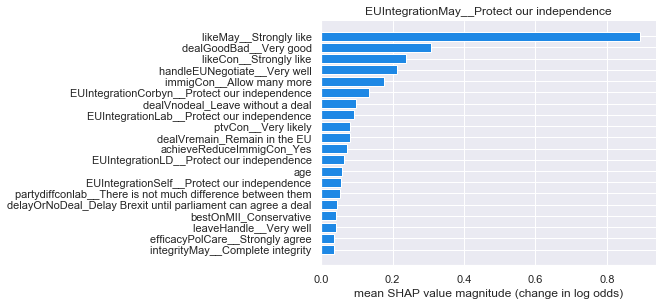

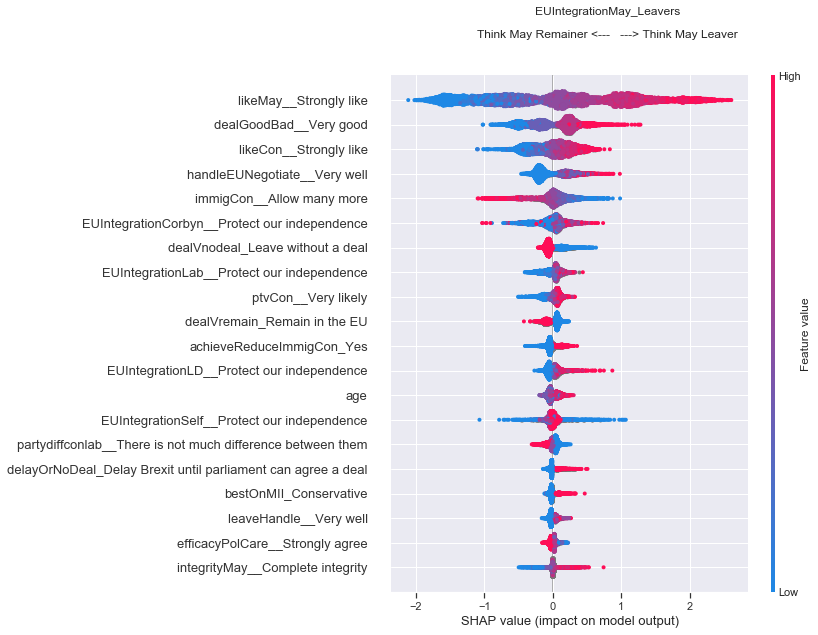

Wall time: 9min 53s


In [98]:
%%time
colname = "EUIntegrationMay_Leavers"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nThink May Remainer <---   ---> Think May Leaver")

In [52]:
Treatment = "xgboost_taxLowIncome"
var_stub = "taxLowIncome"

var_list = ["taxLowIncome__Much too low"]
var_stub_list = [var_stub,"taxMiddleIncome__Much too low","taxHighIncome__Much too low"]

# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1
#     return (BES_Panel["profile_past_vote_2017"]=="Labour")



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 1800,
 max_depth=10,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0.01,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



[0]	validation_0-rmse:2.25471
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:2.15622
[2]	validation_0-rmse:2.06356
[3]	validation_0-rmse:1.97487
[4]	validation_0-rmse:1.89273
[5]	validation_0-rmse:1.81455
[6]	validation_0-rmse:1.74219
[7]	validation_0-rmse:1.67231
[8]	validation_0-rmse:1.60593
[9]	validation_0-rmse:1.54467
[10]	validation_0-rmse:1.48577
[11]	validation_0-rmse:1.432
[12]	validation_0-rmse:1.38175
[13]	validation_0-rmse:1.33369
[14]	validation_0-rmse:1.28842
[15]	validation_0-rmse:1.24688
[16]	validation_0-rmse:1.20934
[17]	validation_0-rmse:1.17294
[18]	validation_0-rmse:1.13848
[19]	validation_0-rmse:1.10585
[20]	validation_0-rmse:1.0772
[21]	validation_0-rmse:1.05009
[22]	validation_0-rmse:1.02333
[23]	validation_0-rmse:0.999626
[24]	validation_0-rmse:0.977662
[25]	validation_0-rmse:0.956766
[26]	validation_0-rmse:0.936902
[27]	validation_0-rmse:0.919027
[28]	validation_0-rmse:0.903266
[29]	validation_0-rmse:0.888132
[30]	val

[252]	validation_0-rmse:0.717369
[253]	validation_0-rmse:0.717306
[254]	validation_0-rmse:0.717349
[255]	validation_0-rmse:0.717282
[256]	validation_0-rmse:0.717292
[257]	validation_0-rmse:0.717315
[258]	validation_0-rmse:0.717386
[259]	validation_0-rmse:0.717419
[260]	validation_0-rmse:0.717416
[261]	validation_0-rmse:0.717445
[262]	validation_0-rmse:0.717426
[263]	validation_0-rmse:0.717385
[264]	validation_0-rmse:0.717417
[265]	validation_0-rmse:0.71744
[266]	validation_0-rmse:0.717405
[267]	validation_0-rmse:0.717469
[268]	validation_0-rmse:0.717486
[269]	validation_0-rmse:0.71744
[270]	validation_0-rmse:0.717435
[271]	validation_0-rmse:0.717461
[272]	validation_0-rmse:0.717479
[273]	validation_0-rmse:0.717491
[274]	validation_0-rmse:0.717504
[275]	validation_0-rmse:0.717509
[276]	validation_0-rmse:0.717502
[277]	validation_0-rmse:0.717521
[278]	validation_0-rmse:0.717482
[279]	validation_0-rmse:0.717522
[280]	validation_0-rmse:0.717549
[281]	validation_0-rmse:0.717559
[282]	valida

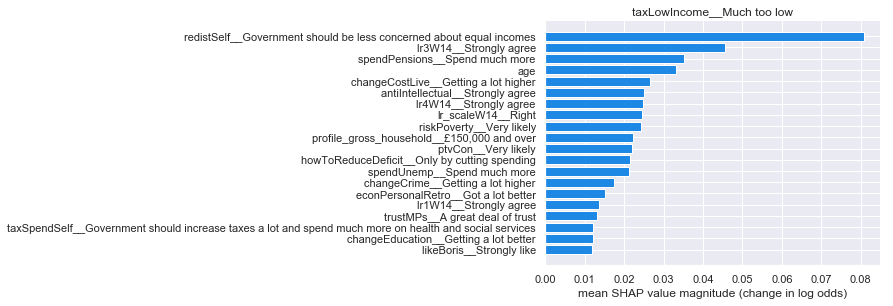

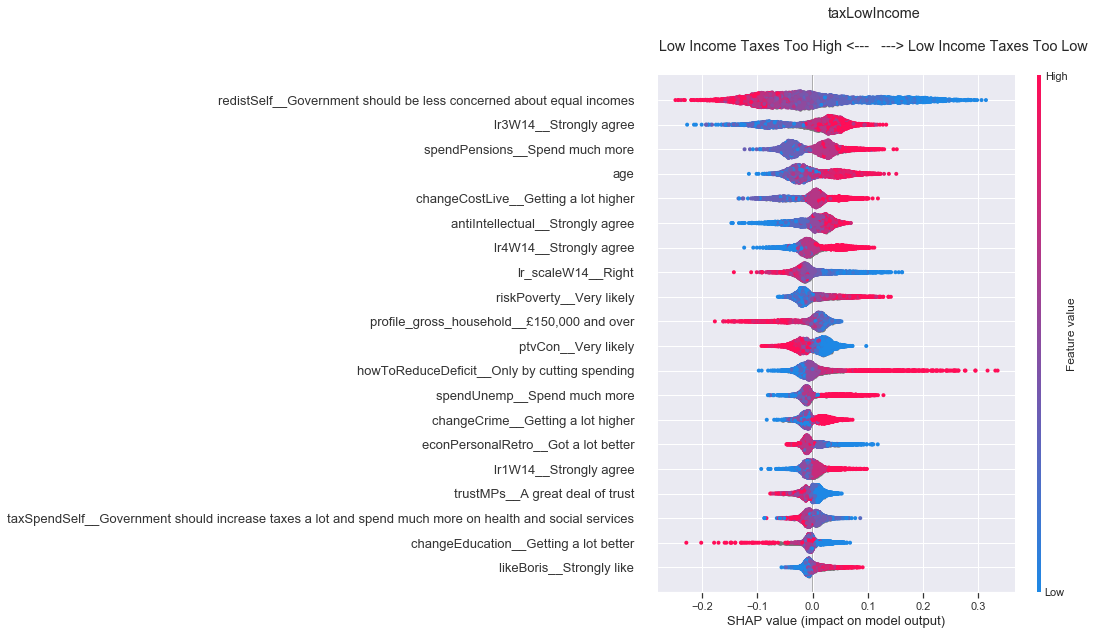

Wall time: 3min 58s


In [53]:
%%time
colname = "taxLowIncome"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nLow Income Taxes Too High <---   ---> Low Income Taxes Too Low")

In [ ]:
### Who are the Leavers who *won't* back No Deal vs Remain?



In [92]:
search(BES_Panel,"euref")

euRefDoOver             30842
euRefVote               30602
goodConductEURef         6919
euRefTurnoutRetro       30842
euRefpastVote           27007
pastvote_EURef          30842
euRefLA                 92587
profile_eurefvote       49415
profile_eurefturnout    55660
dtype: int64

In [93]:
mask = (BES_Panel["profile_eurefvote"]=="Leave the EU")
rvnd_corrs = BES_reduced_with_na[mask].corrwith(BES_reduced_with_na["remainVnodeal_Remain in the EU"][mask])

In [94]:
rvnd_corrs.dropna().sort_values()

euRefVote_Leave the EU                                         -0.905064
euID_The leave side                                            -0.791899
willOfPeople__Strongly agree                                   -0.679774
EUIntegrationSelf__Protect our independence                    -0.668887
noDealLongTerm__Extremely good                                 -0.532725
noDealShortTerm__Extremely good                                -0.440874
effectsEUEcon__Much better                                     -0.435962
euLeaveVoice__Much higher                                      -0.379333
effectsEUTrade__Much higher                                    -0.372931
effectsEUNHS__Much better                                      -0.351910
expectAccess_Yes                                               -0.337361
dealPriorityRedTape__Extremely important                       -0.334029
likeBrexitParty__Strongly like                                 -0.327957
likeFarage__Strongly like                          

In [123]:
BES_Panel["profile_eurefvote"].cat.categories

Index(['Stay/remain in the EU', 'Leave the EU', 'Don't know'], dtype='object')

In [139]:
search(BES_reduced_with_na,"berger")

likeBerger__Strongly like    11071
dtype: int64

In [34]:
# Treatment = "xgboost_dealVnodeal"
# var_stub = "dealVnodeal"

# var_list = ["dealVnodeal_Leave without a deal"]
# var_stub_list = [var_stub,"euRefVote_Leave the EU","euID_The leave side","dealVremain_Remain in the EU",
#                  "delayOrNoDeal_Delay Brexit until parliament can agree a deal","euRefDoOver_Yes","cancelBrexit__Strongly agree",
#                  "euRefpastVote_Leave the EU","pastvote_EURef_Leave the EU",
#                  "willOfPeople__Strongly agree","dealVnodeal_Leave without a deal","profile_eurefvote_Leave the EU",
#                  "regretsIHaveAFewEU__I did not vote", 'noDealShortTerm__Extremely good', 'noDealLongTerm__Extremely good',
#                  "remainVnodeal_Remain in the EU"]

Treatment = "xgboost_berger"
var_stub = "likeBerger"
var_list = ["likeBerger__Strongly like"]
var_stub_list = [var_stub]


# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1
#     return (BES_Panel["profile_eurefvote"]=='Leave the EU')
#     return (BES_Panel["profile_eurefvote"]=='Stay/remain in the EU')
#     return (BES_Panel["profile_past_vote_2017"]=="Labour")



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.01,
 n_estimators= 1800,
 max_depth=10,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0.01,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



[0]	validation_0-rmse:0.480149
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:0.461008
[2]	validation_0-rmse:0.442863
[3]	validation_0-rmse:0.426272
[4]	validation_0-rmse:0.411141
[5]	validation_0-rmse:0.39667
[6]	validation_0-rmse:0.38234
[7]	validation_0-rmse:0.369086
[8]	validation_0-rmse:0.3563
[9]	validation_0-rmse:0.344535
[10]	validation_0-rmse:0.333522
[11]	validation_0-rmse:0.323674
[12]	validation_0-rmse:0.314049
[13]	validation_0-rmse:0.305001
[14]	validation_0-rmse:0.29683
[15]	validation_0-rmse:0.289228
[16]	validation_0-rmse:0.281909
[17]	validation_0-rmse:0.275035
[18]	validation_0-rmse:0.268486
[19]	validation_0-rmse:0.262339
[20]	validation_0-rmse:0.257124
[21]	validation_0-rmse:0.252305
[22]	validation_0-rmse:0.247592
[23]	validation_0-rmse:0.243385
[24]	validation_0-rmse:0.239554
[25]	validation_0-rmse:0.236064
[26]	validation_0-rmse:0.232746
[27]	validation_0-rmse:0.229623
[28]	validation_0-rmse:0.226655
[29]	validation_0-r

[251]	validation_0-rmse:0.193948
[252]	validation_0-rmse:0.193942
[253]	validation_0-rmse:0.193936
[254]	validation_0-rmse:0.193941
[255]	validation_0-rmse:0.193943
[256]	validation_0-rmse:0.19393
[257]	validation_0-rmse:0.193918
[258]	validation_0-rmse:0.193912
[259]	validation_0-rmse:0.193916
[260]	validation_0-rmse:0.193903
[261]	validation_0-rmse:0.193908
[262]	validation_0-rmse:0.193912
[263]	validation_0-rmse:0.193944
[264]	validation_0-rmse:0.193937
[265]	validation_0-rmse:0.193923
[266]	validation_0-rmse:0.193914
[267]	validation_0-rmse:0.193916
[268]	validation_0-rmse:0.193932
[269]	validation_0-rmse:0.193925
[270]	validation_0-rmse:0.193932
[271]	validation_0-rmse:0.193932
[272]	validation_0-rmse:0.193923
[273]	validation_0-rmse:0.193918
[274]	validation_0-rmse:0.193916
[275]	validation_0-rmse:0.193908
[276]	validation_0-rmse:0.193915
[277]	validation_0-rmse:0.193914
[278]	validation_0-rmse:0.193903
[279]	validation_0-rmse:0.193897
[280]	validation_0-rmse:0.193898
[281]	valid

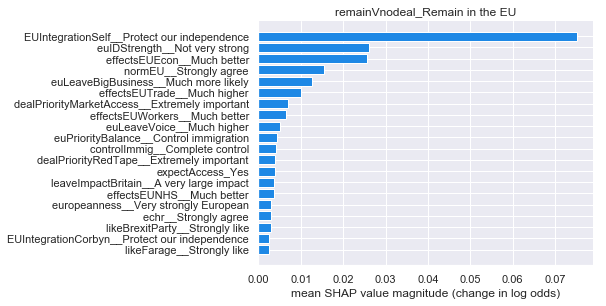

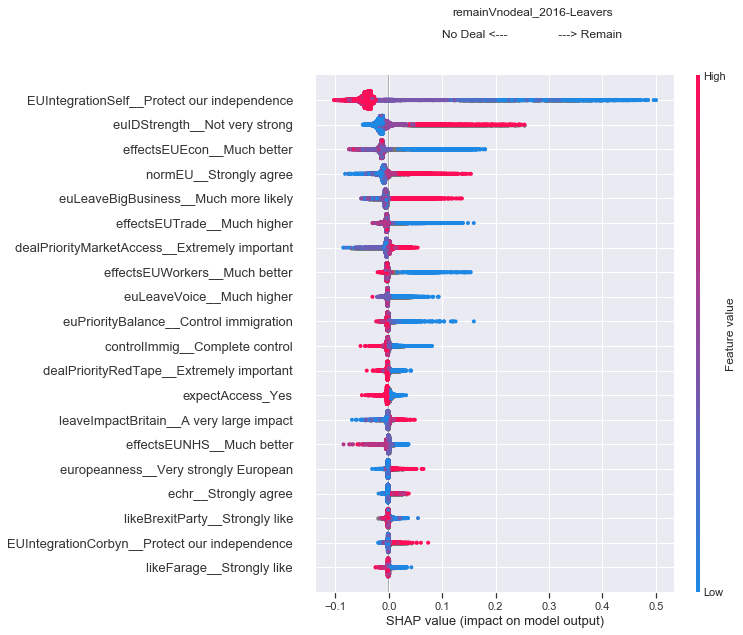

Wall time: 6min 37s


In [134]:
%%time
colname = "remainVnodeal_2016-Leavers"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nNo Deal <---               ---> Remain")

[0]	validation_0-rmse:0.48932
Will train until validation_0-rmse hasn't improved in 8.6 rounds.
[1]	validation_0-rmse:0.479631
[2]	validation_0-rmse:0.471182
[3]	validation_0-rmse:0.462721
[4]	validation_0-rmse:0.454356
[5]	validation_0-rmse:0.447059
[6]	validation_0-rmse:0.440631
[7]	validation_0-rmse:0.433995
[8]	validation_0-rmse:0.428257
[9]	validation_0-rmse:0.422998
[10]	validation_0-rmse:0.41843
[11]	validation_0-rmse:0.41367
[12]	validation_0-rmse:0.409867
[13]	validation_0-rmse:0.405742
[14]	validation_0-rmse:0.402555
[15]	validation_0-rmse:0.399969
[16]	validation_0-rmse:0.396789
[17]	validation_0-rmse:0.393727
[18]	validation_0-rmse:0.390967
[19]	validation_0-rmse:0.38859
[20]	validation_0-rmse:0.38709
[21]	validation_0-rmse:0.384725
[22]	validation_0-rmse:0.383292
[23]	validation_0-rmse:0.38111
[24]	validation_0-rmse:0.379466
[25]	validation_0-rmse:0.377977
[26]	validation_0-rmse:0.376486
[27]	validation_0-rmse:0.375189
[28]	validation_0-rmse:0.374312
[29]	validation_0-rmse

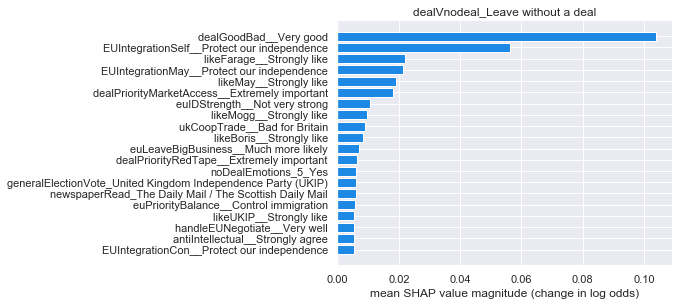

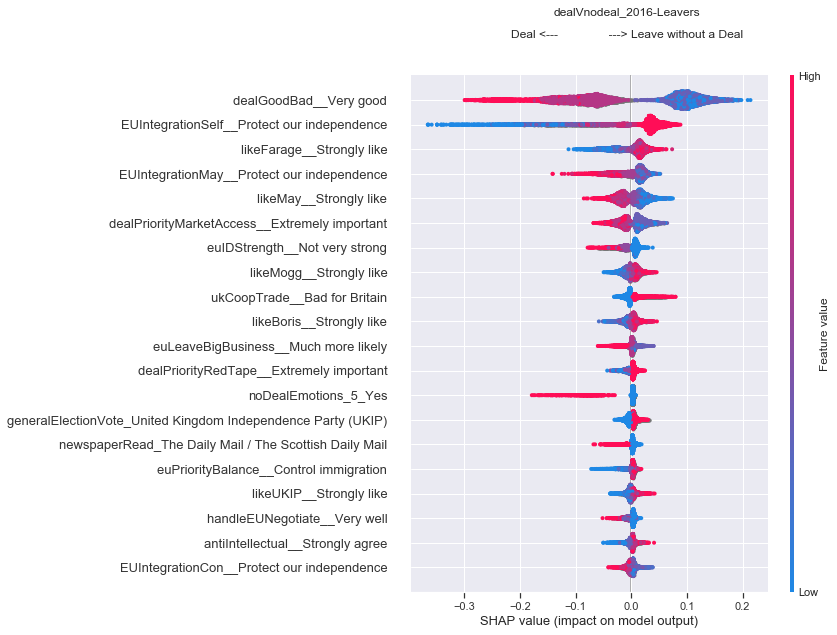

Wall time: 4min 22s


In [138]:
%%time
colname = "dealVnodeal_2016-Leavers"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nDeal <---               ---> Leave without a Deal")

[0]	validation_0-rmse:4.45686
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:4.42054
[2]	validation_0-rmse:4.38438
[3]	validation_0-rmse:4.34905
[4]	validation_0-rmse:4.31418
[5]	validation_0-rmse:4.28003
[6]	validation_0-rmse:4.2467
[7]	validation_0-rmse:4.21295
[8]	validation_0-rmse:4.1798
[9]	validation_0-rmse:4.14668
[10]	validation_0-rmse:4.115
[11]	validation_0-rmse:4.08235
[12]	validation_0-rmse:4.05058
[13]	validation_0-rmse:4.01874
[14]	validation_0-rmse:3.98736
[15]	validation_0-rmse:3.95759
[16]	validation_0-rmse:3.92737
[17]	validation_0-rmse:3.89671
[18]	validation_0-rmse:3.86707
[19]	validation_0-rmse:3.83822
[20]	validation_0-rmse:3.80933
[21]	validation_0-rmse:3.78153
[22]	validation_0-rmse:3.75285
[23]	validation_0-rmse:3.72529
[24]	validation_0-rmse:3.69834
[25]	validation_0-rmse:3.67078
[26]	validation_0-rmse:3.64327
[27]	validation_0-rmse:3.61672
[28]	validation_0-rmse:3.59034
[29]	validation_0-rmse:3.56439
[30]	validation_

[259]	validation_0-rmse:1.78882
[260]	validation_0-rmse:1.78802
[261]	validation_0-rmse:1.78733
[262]	validation_0-rmse:1.78652
[263]	validation_0-rmse:1.78589
[264]	validation_0-rmse:1.78547
[265]	validation_0-rmse:1.78484
[266]	validation_0-rmse:1.78418
[267]	validation_0-rmse:1.78363
[268]	validation_0-rmse:1.78307
[269]	validation_0-rmse:1.78246
[270]	validation_0-rmse:1.7818
[271]	validation_0-rmse:1.78121
[272]	validation_0-rmse:1.78063
[273]	validation_0-rmse:1.77995
[274]	validation_0-rmse:1.77966
[275]	validation_0-rmse:1.77921
[276]	validation_0-rmse:1.77883
[277]	validation_0-rmse:1.7785
[278]	validation_0-rmse:1.7779
[279]	validation_0-rmse:1.77753
[280]	validation_0-rmse:1.77711
[281]	validation_0-rmse:1.77663
[282]	validation_0-rmse:1.77609
[283]	validation_0-rmse:1.77579
[284]	validation_0-rmse:1.77536
[285]	validation_0-rmse:1.77488
[286]	validation_0-rmse:1.77434
[287]	validation_0-rmse:1.77371
[288]	validation_0-rmse:1.77334
[289]	validation_0-rmse:1.77278
[290]	valid

[516]	validation_0-rmse:1.74789
[517]	validation_0-rmse:1.74789
[518]	validation_0-rmse:1.74781
[519]	validation_0-rmse:1.74783
[520]	validation_0-rmse:1.74777
[521]	validation_0-rmse:1.74775
[522]	validation_0-rmse:1.74777
[523]	validation_0-rmse:1.74772
[524]	validation_0-rmse:1.74771
[525]	validation_0-rmse:1.74775
[526]	validation_0-rmse:1.74775
[527]	validation_0-rmse:1.74776
[528]	validation_0-rmse:1.74782
[529]	validation_0-rmse:1.74787
[530]	validation_0-rmse:1.7478
[531]	validation_0-rmse:1.74772
[532]	validation_0-rmse:1.74767
[533]	validation_0-rmse:1.74766
[534]	validation_0-rmse:1.74766
[535]	validation_0-rmse:1.7476
[536]	validation_0-rmse:1.74773
[537]	validation_0-rmse:1.74761
[538]	validation_0-rmse:1.74764
[539]	validation_0-rmse:1.74765
[540]	validation_0-rmse:1.74765
[541]	validation_0-rmse:1.74754
[542]	validation_0-rmse:1.74752
[543]	validation_0-rmse:1.74752
[544]	validation_0-rmse:1.7476
[545]	validation_0-rmse:1.74754
[546]	validation_0-rmse:1.74754
[547]	valid

[773]	validation_0-rmse:1.74627
[774]	validation_0-rmse:1.74631
[775]	validation_0-rmse:1.74639
[776]	validation_0-rmse:1.7464
[777]	validation_0-rmse:1.74634
[778]	validation_0-rmse:1.74629
[779]	validation_0-rmse:1.74624
[780]	validation_0-rmse:1.74621
[781]	validation_0-rmse:1.74618
[782]	validation_0-rmse:1.74619
[783]	validation_0-rmse:1.74621
[784]	validation_0-rmse:1.74617
[785]	validation_0-rmse:1.74614
[786]	validation_0-rmse:1.74617
[787]	validation_0-rmse:1.74623
[788]	validation_0-rmse:1.74626
[789]	validation_0-rmse:1.74624
[790]	validation_0-rmse:1.74618
[791]	validation_0-rmse:1.74626
[792]	validation_0-rmse:1.74615
[793]	validation_0-rmse:1.74623
[794]	validation_0-rmse:1.74623
[795]	validation_0-rmse:1.7462
[796]	validation_0-rmse:1.74616
[797]	validation_0-rmse:1.74613
[798]	validation_0-rmse:1.74612
[799]	validation_0-rmse:1.74613
[800]	validation_0-rmse:1.74614
[801]	validation_0-rmse:1.74612
[802]	validation_0-rmse:1.74609
[803]	validation_0-rmse:1.74614
[804]	vali

[1030]	validation_0-rmse:1.74657
[1031]	validation_0-rmse:1.74653
[1032]	validation_0-rmse:1.74656
[1033]	validation_0-rmse:1.74657
[1034]	validation_0-rmse:1.7466
[1035]	validation_0-rmse:1.74658
[1036]	validation_0-rmse:1.74655
[1037]	validation_0-rmse:1.74656
[1038]	validation_0-rmse:1.74655
[1039]	validation_0-rmse:1.74661
[1040]	validation_0-rmse:1.7466
[1041]	validation_0-rmse:1.7466
[1042]	validation_0-rmse:1.74653
[1043]	validation_0-rmse:1.7466
[1044]	validation_0-rmse:1.74663
[1045]	validation_0-rmse:1.74661
[1046]	validation_0-rmse:1.7466
[1047]	validation_0-rmse:1.74657
[1048]	validation_0-rmse:1.74658
[1049]	validation_0-rmse:1.74658
[1050]	validation_0-rmse:1.74654
[1051]	validation_0-rmse:1.74654
[1052]	validation_0-rmse:1.74652
[1053]	validation_0-rmse:1.74652
[1054]	validation_0-rmse:1.74653
[1055]	validation_0-rmse:1.7465
[1056]	validation_0-rmse:1.74649
[1057]	validation_0-rmse:1.74645
[1058]	validation_0-rmse:1.74647
[1059]	validation_0-rmse:1.74647
[1060]	validatio

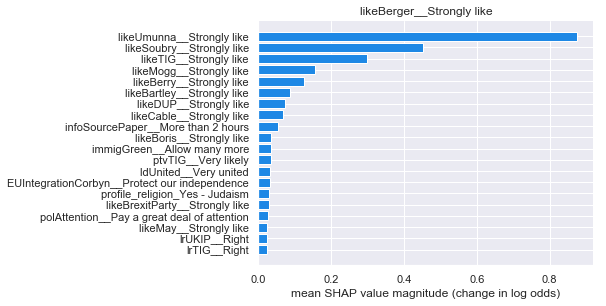

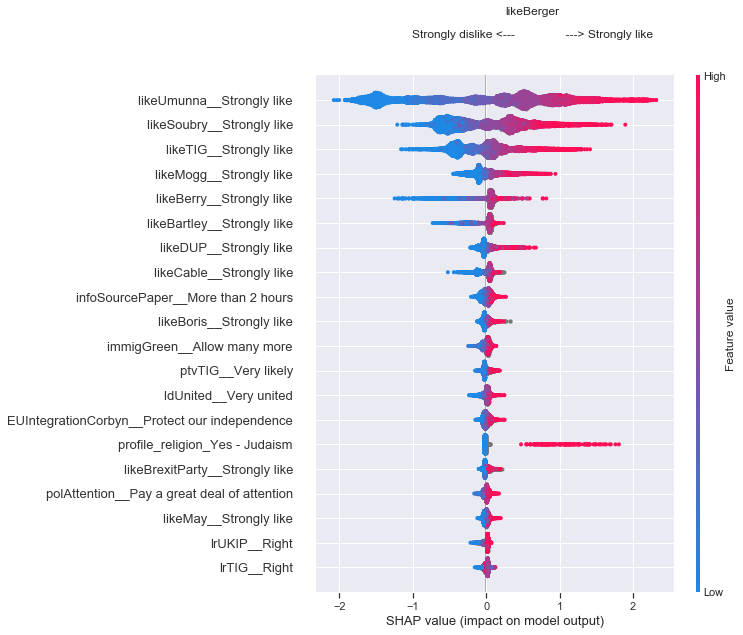

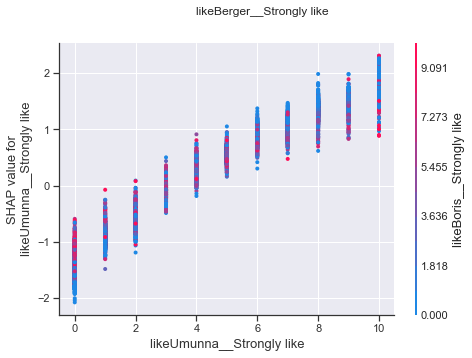

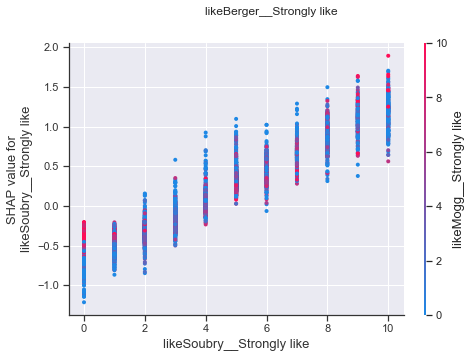

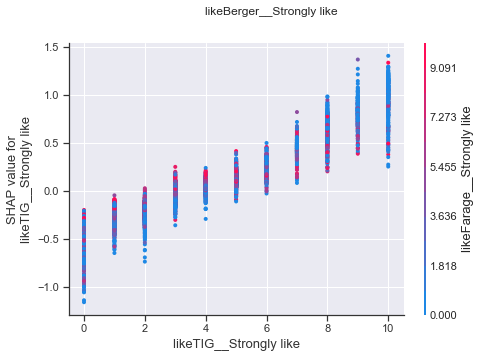

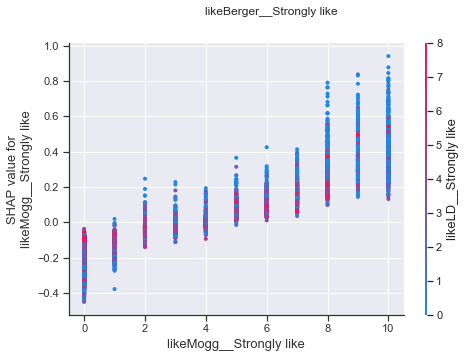

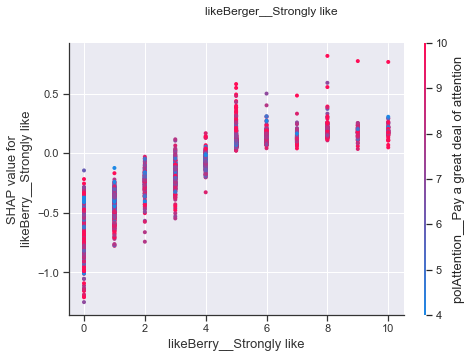

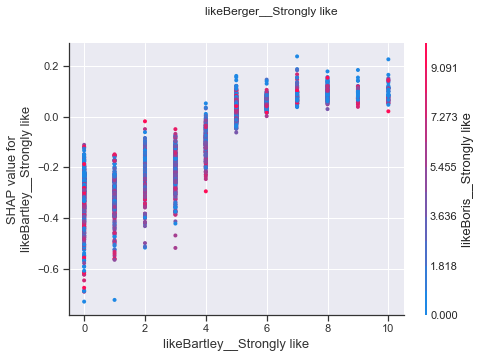

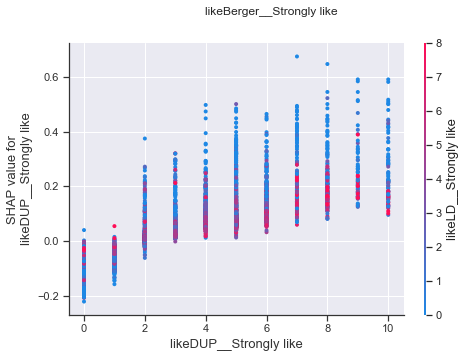

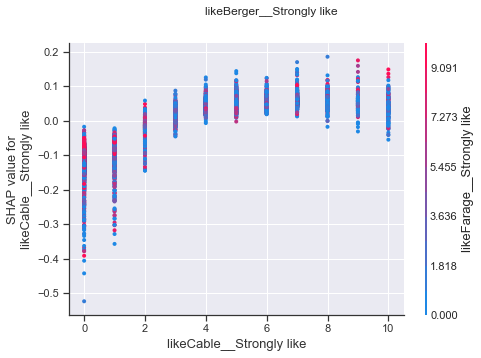

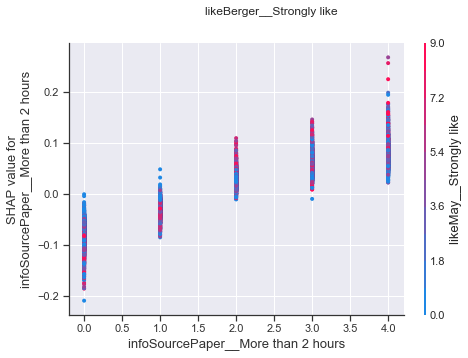

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


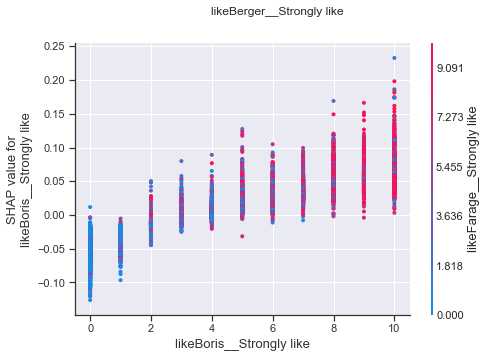

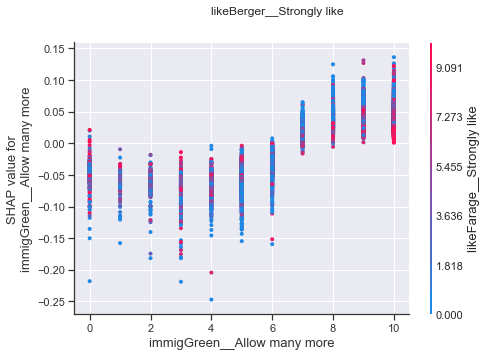

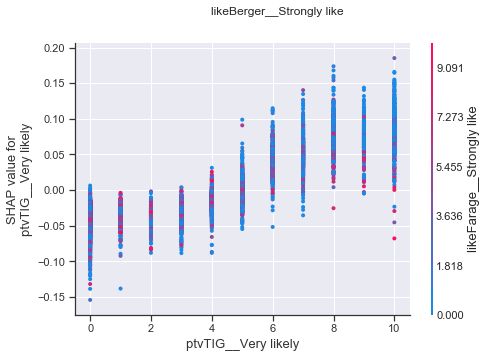

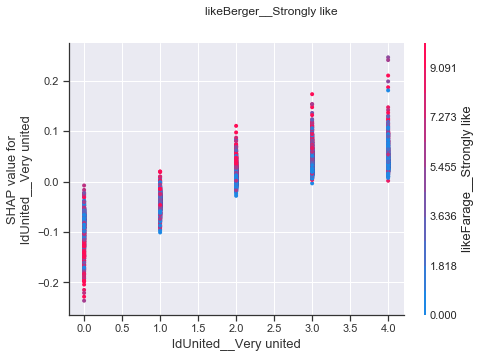

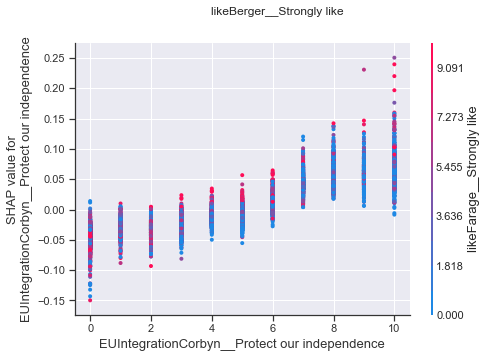

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


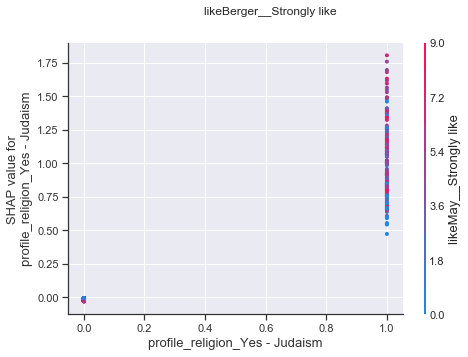

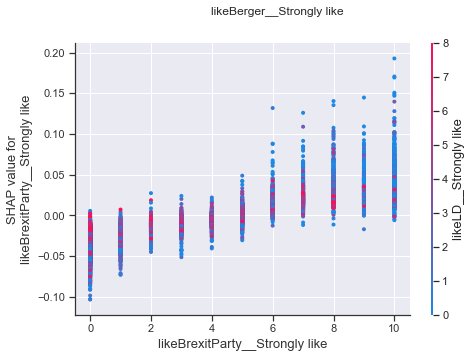

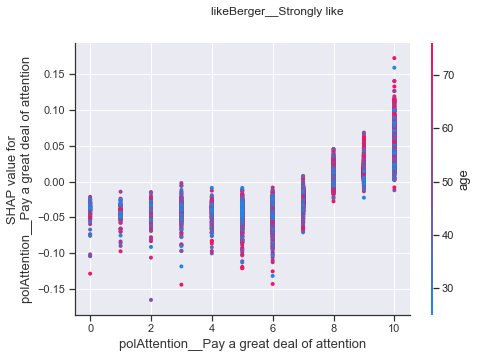

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


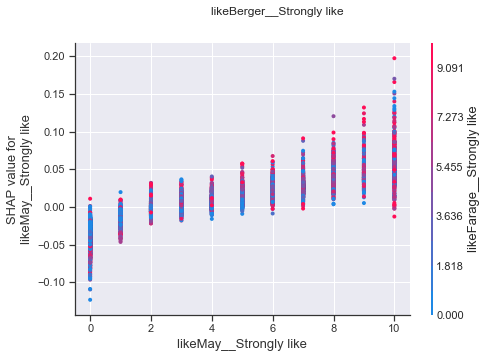

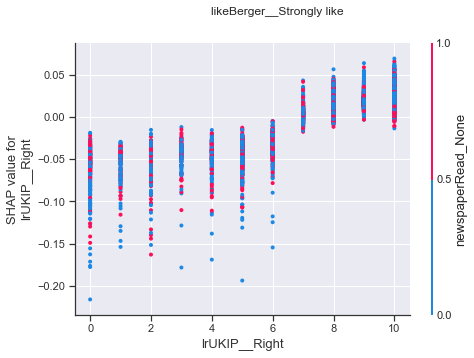

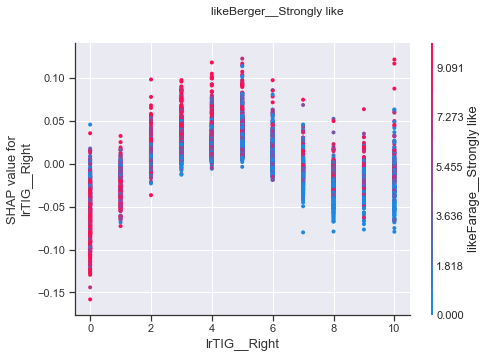

Wall time: 1h 51s


In [35]:
%%time
colname = "likeBerger"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),dependence_plots=True,
           title = colname+"\n\nStrongly dislike <---               ---> Strongly like")

[0]	validation_0-rmse:4.23668
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:4.08811
[2]	validation_0-rmse:3.9462
[3]	validation_0-rmse:3.81667
[4]	validation_0-rmse:3.69387
[5]	validation_0-rmse:3.57805
[6]	validation_0-rmse:3.46914
[7]	validation_0-rmse:3.36717
[8]	validation_0-rmse:3.27226
[9]	validation_0-rmse:3.18367
[10]	validation_0-rmse:3.10047
[11]	validation_0-rmse:3.0224
[12]	validation_0-rmse:2.95197
[13]	validation_0-rmse:2.88616
[14]	validation_0-rmse:2.82507
[15]	validation_0-rmse:2.7678
[16]	validation_0-rmse:2.71571
[17]	validation_0-rmse:2.6666
[18]	validation_0-rmse:2.62179
[19]	validation_0-rmse:2.57908
[20]	validation_0-rmse:2.541
[21]	validation_0-rmse:2.50472
[22]	validation_0-rmse:2.47119
[23]	validation_0-rmse:2.44114
[24]	validation_0-rmse:2.41222
[25]	validation_0-rmse:2.3872
[26]	validation_0-rmse:2.36376
[27]	validation_0-rmse:2.34152
[28]	validation_0-rmse:2.32242
[29]	validation_0-rmse:2.3037
[30]	validation_0-rm

[259]	validation_0-rmse:2.08238
[260]	validation_0-rmse:2.0825
[261]	validation_0-rmse:2.08253
[262]	validation_0-rmse:2.08262
[263]	validation_0-rmse:2.08242
[264]	validation_0-rmse:2.0824
[265]	validation_0-rmse:2.08248
[266]	validation_0-rmse:2.08226
[267]	validation_0-rmse:2.08206
[268]	validation_0-rmse:2.08208
[269]	validation_0-rmse:2.08205
[270]	validation_0-rmse:2.08252
[271]	validation_0-rmse:2.08254
[272]	validation_0-rmse:2.08251
[273]	validation_0-rmse:2.08253
[274]	validation_0-rmse:2.08254
[275]	validation_0-rmse:2.08259
[276]	validation_0-rmse:2.08253
[277]	validation_0-rmse:2.08227
[278]	validation_0-rmse:2.08214
[279]	validation_0-rmse:2.08191
[280]	validation_0-rmse:2.0819
[281]	validation_0-rmse:2.08202
[282]	validation_0-rmse:2.08213
[283]	validation_0-rmse:2.08235
[284]	validation_0-rmse:2.08226
[285]	validation_0-rmse:2.08237
[286]	validation_0-rmse:2.08249
[287]	validation_0-rmse:2.08256
[288]	validation_0-rmse:2.08264
[289]	validation_0-rmse:2.08265
[290]	valid

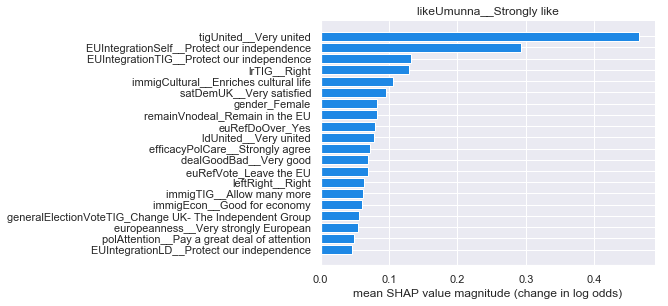

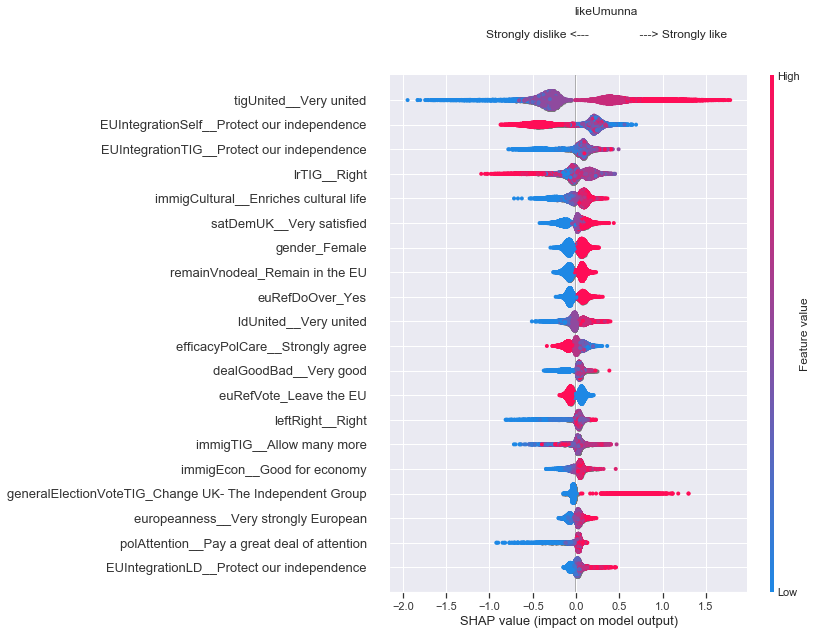

Wall time: 21min


In [188]:
%%time
colname = "likeUmunna"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nStrongly dislike <---               ---> Strongly like")

In [100]:
BES_Panel["remainVnodeal"].value_counts()

Remain in the EU        14567
Leave without a deal    12231
Don't know               2442
I would not vote         1602
Name: remainVnodeal, dtype: int64

In [101]:
BES_Panel["remainVnodeal"][ BES_Panel["profile_eurefvote"]=="Leave the EU" ].value_counts()

Leave without a deal    8975
Remain in the EU        1131
Don't know               868
I would not vote         521
Name: remainVnodeal, dtype: int64

In [106]:
ct = pd.crosstab( BES_Panel["remainVnodeal"], BES_Panel["euRefVote"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='columns')*100 
ct

euRefVote             Stay/remain in the EU  Leave the EU  \
remainVnodeal                                               
Leave without a deal               1.844630     87.531374   
Remain in the EU                  91.737470      2.478510   
I would not vote                   1.515262      3.181571   
Don't know                         4.902638      6.808545   

euRefVote             I would/will not vote  Don't know  
remainVnodeal                                            
Leave without a deal              20.101962   11.698791  
Remain in the EU                   8.125204   16.539019  
I would not vote                  63.987786    7.743277  
Don't know                         7.785049   64.018914

In [217]:
ct = pd.crosstab( BES_Panel["dealVnodeal"], BES_Panel["euRefVote"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='columns')*100 
ct.round().astype('int')

euRefVote                         Stay/remain in the EU  Leave the EU  \
dealVnodeal                                                             
The government's withdrawal deal                     45            22   
Leave without a deal                                  7            65   
I would not vote                                     22             3   
Don't know                                           26            10   

euRefVote                         I would/will not vote  Don't know  
dealVnodeal                                                          
The government's withdrawal deal                      9          18  
Leave without a deal                                 18           9  
I would not vote                                     64           9  
Don't know                                           10          64

In [218]:
ct = pd.crosstab( BES_Panel["dealVnodeal"], BES_Panel["profile_eurefvote"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='columns')*100 
ct.round().astype('int')

profile_eurefvote                 Stay/remain in the EU  Leave the EU  \
dealVnodeal                                                             
The government's withdrawal deal                     46            21   
Leave without a deal                                  9            59   
I would not vote                                     19             7   
Don't know                                           25            13   

profile_eurefvote                 Don't know  
dealVnodeal                                   
The government's withdrawal deal          17  
Leave without a deal                      29  
I would not vote                          14  
Don't know                                40

In [107]:
ct = pd.crosstab( BES_Panel["remainVnodeal"], BES_Panel["profile_eurefvote"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='columns')*100 
ct

profile_eurefvote     Stay/remain in the EU  Leave the EU  Don't know
remainVnodeal                                                        
Leave without a deal               8.288370     75.823919   30.831676
Remain in the EU                  83.148014     10.361002   28.712949
I would not vote                   2.132529      4.913207    8.961807
Don't know                         6.431086      8.901871   31.493568

In [166]:
ct = pd.crosstab( BES_Panel["likeBerger"], BES_Panel["profile_pcon"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='columns')*100 
ct

profile_pcon      Aldershot  Aldridge-Brownhills  Altrincham and Sale West  \
likeBerger                                                                   
Strongly dislike   0.000000            18.613175                  0.000000   
1                  0.000000             0.000000                  0.000000   
2                  0.000000            15.407686                  0.000000   
3                 10.086798             0.000000                  0.000000   
4                 10.126304             0.000000                  0.000000   
5                 15.175457            12.990907                  0.000000   
6                  0.000000             0.000000                 18.806231   
7                 18.996477             0.000000                  0.000000   
8                  0.000000             0.000000                  0.000000   
9                  0.000000             0.000000                  0.000000   
Strongly like      0.000000             0.000000                  0.000000   
Don't know        45.614964            52.988232                 81.193769   

profile_pcon      Amber Valley  Arundel and South Downs   Ashfield    Ashford  \
likeBerger                                                                      
Strongly dislike     31.064248                 0.000000   5.780167   0.000000   
1                     6.853046                 0.000000   0.000000   0.000000   
2                     0.000000                 0.000000   0.000000   0.000000   
3                    11.655509                25.470636   0.000000   0.000000   
4                     0.000000                 0.000000   0.000000   4.850194   
5                     8.585028                 0.000000   8.706898   0.000000   
6                     0.000000                 7.035486   0.000000   0.000000   
7                     0.000000                 0.000000   0.000000   3.479295   
8                     0.000000                 0.000000   0.000000   0.000000   
9                     0.000000                 0.000000   0.000000   0.000000   
Strongly like         0.000000                 0.000000   0.000000   0.000000   
Don't know           41.842169                67.493878  85.512934  91.670512   

profile_pcon      Ashton-under-Lyne  Aylesbury    Banbury  \
likeBerger                                                  
Strongly dislike           6.437604   0.000000  18.653809   
1                          0.000000   0.000000   0.000000   
2                          0.000000   0.000000   0.000000   
3                          0.000000   0.000000  14.267586   
4                          0.000000   0.000000   0.000000   
5                          8.146877   0.000000  10.156597   
6                          0.000000   6.801242   3.609610   
7                          7.624989   0.000000   0.000000   
8                          0.000000   0.000000   0.000000   
9                          0.000000  18.424678   0.000000   
Strongly like              0.000000   0.000000   0.000000   
Don't know                77.790529  74.774080  53.312398   

profile_pcon             ...           Ochil and South Perthshire  \
likeBerger               ...                                        
Strongly dislike         ...                            14.491853   
1                        ...                             0.000000   
2                        ...                             0.000000   
3                        ...                             0.000000   
4                        ...                             8.002004   
5                        ...                             0.000000   
6                        ...                             0.000000   
7                        ...                             0.000000   
8                        ...                             0.000000   
9                        ...                             0.000000   
Strongly like            ...                             0.000000   
Don't know          

In [131]:
search(BES_reduced_with_na,"noDeal(Short|Long)Term").index

Index(['noDealShortTerm__Extremely good', 'noDealLongTerm__Extremely good'], dtype='object')

In [175]:
search(BES_Panel,"ethnicity")

profile_ethnicity    72299
dtype: int64

In [ ]:
BES_Panel["profile_pcon"]

In [150]:
cxt

NameError: name 'cxt' is not defined

In [167]:
ct.loc["Strongly like"].sort_values()

profile_pcon
Aldershot                             0.000000
South Staffordshire                   0.000000
South Suffolk                         0.000000
South Swindon                         0.000000
South Thanet                          0.000000
South West Bedfordshire               0.000000
South West Devon                      0.000000
South West Hertfordshire              0.000000
South West Norfolk                    0.000000
South West Surrey                     0.000000
South West Wiltshire                  0.000000
Southampton, Itchen                   0.000000
Southampton, Test                     0.000000
Southend West                         0.000000
Southport                             0.000000
Spelthorne                            0.000000
South Shields                         0.000000
St Albans                             0.000000
South Ribble                          0.000000
South Norfolk                         0.000000
Shipley                               0.000000


In [154]:
pcon_list = "Aldershot|Aldridge-Brownhills|Altrincham and Sale West|Amber Valley|Arundel and South Downs|Ashfield|Ashford|Ashton-under-Lyne|Aylesbury|Banbury|Barking|Barnsley Central|Barnsley East|Barrow and Furness|Basildon and Billericay|Basingstoke|Bassetlaw|Bath|Batley and Spen|Battersea|Beaconsfield|Beckenham|Bedford|Bermondsey and Old Southwark|Berwick-upon-Tweed|Bethnal Green and Bow|Beverley and Holderness|Bexhill and Battle|Bexleyheath and Crayford|Birkenhead|Birmingham, Edgbaston|Birmingham, Erdington|Birmingham, Hall Green|Birmingham, Hodge Hill|Birmingham, Ladywood|Birmingham, Northfield|Birmingham, Perry Barr|Birmingham, Selly Oak|Birmingham, Yardley|Bishop Auckland|Blackburn|Blackley and Broughton|Blackpool North and Cleveleys|Blackpool South|Blaydon|Blyth Valley|Bognor Regis and Littlehampton|Bolsover|Bolton North East|Bolton South East|Bolton West|Bootle|Boston and Skegness|Bosworth|Bournemouth East|Bournemouth West|Bracknell|Bradford East|Bradford South|Bradford West|Braintree|Brent Central|Brent North|Brentford and Isleworth|Brentwood and Ongar|Bridgwater and West Somerset|Brigg and Goole|Brighton, Kemptown|Brighton, Pavilion|Bristol East|Bristol North West|Bristol South|Bristol West|Broadland|Bromley and Chislehurst|Bromsgrove|Broxbourne|Broxtowe|Buckingham|Burnley|Burton|Bury North|Bury South|Bury St Edmunds|Calder Valley|Camberwell and Peckham|Camborne and Redruth|Cambridge|Cannock Chase|Canterbury|Carlisle|Carshalton and Wallington|Castle Point|Central Devon|Central Suffolk and North Ipswich|Charnwood|Chatham and Aylesford|Cheadle|Chelmsford|Chelsea and Fulham|Cheltenham|Chesham and Amersham|Chesterfield|Chichester|Chingford and Woodford Green|Chippenham|Chipping Barnet|Chorley|Christchurch|Cities of London and Westminster|City of Chester|City of Durham|Clacton|Cleethorpes|Colchester|Colne Valley|Congleton|Copeland|Corby|Coventry North East|Coventry North West|Coventry South|Crawley|Crewe and Nantwich|Croydon Central|Croydon North|Croydon South|Dagenham and Rainham|Darlington|Dartford|Daventry|Denton and Reddish|Derby North|Derby South|Derbyshire Dales|Devizes|Dewsbury|Don Valley|Doncaster Central|Doncaster North|Dover|Dudley North|Dudley South|Dulwich and West Norwood|Ealing Central and Acton|Ealing North|Ealing, Southall|Easington|East Devon|East Ham|East Hampshire|East Surrey|East Worthing and Shoreham|East Yorkshire|Eastbourne|Eastleigh|Eddisbury|Edmonton|Ellesmere Port and Neston|Elmet and Rothwell|Eltham|Enfield North|Enfield, Southgate|Epping Forest|Epsom and Ewell|Erewash|Erith and Thamesmead|Esher and Walton|Exeter|Fareham|Faversham and Mid Kent|Feltham and Heston|Filton and Bradley Stoke|Finchley and Golders Green|Folkestone and Hythe|Forest of Dean|Fylde|Gainsborough|Garston and Halewood|Gateshead|Gedling|Gillingham and Rainham|Gloucester|Gosport|Grantham and Stamford|Gravesham|Great Grimsby|Great Yarmouth|Greenwich and Woolwich|Guildford|Hackney North and Stoke Newington|Hackney South and Shoreditch|Halesowen and Rowley Regis|Halifax|Haltemprice and Howden|Halton|Hammersmith|Hampstead and Kilburn|Harborough|Harlow|Harrogate and Knaresborough|Harrow East|Harrow West|Hartlepool|Harwich and North Essex|Hastings and Rye|Havant|Hayes and Harlington|Hazel Grove|Hemel Hempstead|Hemsworth|Hendon|Henley|Hereford and South Herefordshire|Hertford and Stortford|Hertsmere|Hexham|Heywood and Middleton|High Peak|Hitchin and Harpenden|Holborn and St Pancras|Hornchurch and Upminster|Hornsey and Wood Green|Horsham|Houghton and Sunderland South|Hove|Huddersfield|Huntingdon|Hyndburn|Ilford North|Ilford South|Ipswich|Isle of Wight|Islington North|Islington South and Finsbury|Jarrow|Keighley|Kenilworth and Southam|Kensington|Kettering|Kingston and Surbiton|Kingston upon Hull East|Kingston upon Hull North|Kingston upon Hull West and Hessle|Kingswood|Knowsley|Lancaster and Fleetwood|Leeds Central|Leeds East|Leeds North East|Leeds North West|Leeds West|Leicester East|Leicester South|Leicester West|Leigh|Lewes|Lewisham East|Lewisham West and Penge|Lewisham, Deptford|Leyton and Wanstead|Lichfield|Lincoln|Liverpool, Riverside|Liverpool, Walton|Liverpool, Wavertree|Liverpool, West Derby|Loughborough|Louth and Horncastle|Ludlow|Luton North|Luton South|Macclesfield|Maidenhead|Maidstone and The Weald|Makerfield|Maldon|Manchester Central|Manchester, Gorton|Manchester, Withington|Mansfield|Meon Valley|Meriden|Mid Bedfordshire|Mid Derbyshire|Mid Dorset and North Poole|Mid Norfolk|Mid Sussex|Mid Worcestershire|Middlesbrough|Middlesbrough South and East Cleveland|Milton Keynes North|Milton Keynes South|Mitcham and Morden|Mole Valley|Morecambe and Lunesdale|Morley and Outwood|New Forest East|New Forest West|Newark|Newbury|Newcastle upon Tyne Central|Newcastle upon Tyne East|Newcastle upon Tyne North|Newcastle-under-Lyme|Newton Abbot|Normanton, Pontefract and Castleford|North Cornwall|North Devon|North Dorset|North Durham|North East Bedfordshire|North East Cambridgeshire|North East Derbyshire|North East Hampshire|North East Hertfordshire|North East Somerset|North Herefordshire|North Norfolk|North Shropshire|North Somerset|North Swindon|North Thanet|North Tyneside|North Warwickshire|North West Cambridgeshire|North West Durham|North West Hampshire|North West Leicestershire|North West Norfolk|North Wiltshire|Northampton North|Northampton South|Norwich North|Norwich South|Nottingham East|Nottingham North|Nottingham South|Nuneaton|Old Bexley and Sidcup|Oldham East and Saddleworth|Oldham West and Royton|Orpington|Oxford East|Oxford West and Abingdon|Pendle|Penistone and Stocksbridge|Penrith and The Border|Peterborough|Plymouth, Moor View|Plymouth, Sutton and Devonport|Poole|Poplar and Limehouse|Portsmouth North|Portsmouth South|Preston|Pudsey|Putney|Rayleigh and Wickford|Reading East|Reading West|Redcar|Redditch|Reigate|Ribble Valley|Richmond (Yorks)|Richmond Park|Rochdale|Rochester and Strood|Rochford and Southend East|Romford|Romsey and Southampton North|Rossendale and Darwen|Rother Valley|Rotherham|Rugby|Ruislip, Northwood and Pinner|Runnymede and Weybridge|Rushcliffe|Rutland and Melton|Saffron Walden|Salford and Eccles|Salisbury|Scarborough and Whitby|Scunthorpe|Sedgefield|Sefton Central|Selby and Ainsty|Sevenoaks|Sheffield Central|Sheffield South East|Sheffield, Brightside and Hillsborough|Sheffield, Hallam|Sheffield, Heeley|Sherwood|Shipley|Shrewsbury and Atcham|Sittingbourne and Sheppey|Skipton and Ripon|Sleaford and North Hykeham|Slough|Solihull|Somerton and Frome|South Basildon and East Thurrock|South Cambridgeshire|South Derbyshire|South Dorset|South East Cambridgeshire|South East Cornwall|South Holland and The Deepings|South Leicestershire|South Norfolk|South Northamptonshire|South Ribble|South Shields|South Staffordshire|South Suffolk|South Swindon|South Thanet|South West Bedfordshire|South West Devon|South West Hertfordshire|South West Norfolk|South West Surrey|South West Wiltshire|Southampton, Itchen|Southampton, Test|Southend West|Southport|Spelthorne|St Albans|St Austell and Newquay|St Helens North|St Helens South and Whiston|St Ives|Stafford|Staffordshire Moorlands|Stalybridge and Hyde|Stevenage|Stockport|Stockton North|Stockton South|Stoke-on-Trent Central|Stoke-on-Trent North|Stoke-on-Trent South|Stone|Stourbridge|Stratford-on-Avon|Streatham|Stretford and Urmston|Stroud|Suffolk Coastal|Sunderland Central|Surrey Heath|Sutton and Cheam|Sutton Coldfield|Tamworth|Tatton|Taunton Deane|Telford|Tewkesbury|The Cotswolds|The Wrekin|Thirsk and Malton|Thornbury and Yate|Thurrock|Tiverton and Honiton|Tonbridge and Malling|Tooting|Torbay|Torridge and West Devon|Totnes|Tottenham|Truro and Falmouth|Tunbridge Wells|Twickenham|Tynemouth|Uxbridge and South Ruislip|Vauxhall|Wakefield|Wallasey|Walsall North|Walsall South|Walthamstow|Wansbeck|Wantage|Warley|Warrington North|Warrington South|Warwick and Leamington|Washington and Sunderland West|Watford|Waveney|Wealden|Weaver Vale|Wellingborough|Wells|Welwyn Hatfield|Wentworth and Dearne|West Bromwich East|West Bromwich West|West Dorset|West Ham|West Lancashire|West Suffolk|West Worcestershire|Westminster North|Westmorland and Lonsdale|Weston-Super-Mare|Wigan|Wimbledon|Winchester|Windsor|Wirral South|Wirral West|Witham|Witney|Woking|Wokingham|Wolverhampton North East|Wolverhampton South East|Wolverhampton South West|Worcester|Workington|Worsley and Eccles South|Worthing West|Wycombe|Wyre and Preston North|Wyre Forest|Wythenshawe and Sale East|Yeovil|York Central|York Outer|Ynys Mon|Delyn|Alyn and Deeside|Wrexham|Llanelli|Gower|Swansea West|Swansea East|Aberavon|Cardiff Central|Cardiff North|Rhondda|Torfaen|Monmouth|Newport East|Newport West|Arfon|Aberconwy|Clwyd West|Vale of Clwyd|Dwyfor Meirionnydd|Clwyd South|Montgomeryshire|Ceredigion|Preseli Pembrokeshire|Carmarthen West and South Pembrokeshire|Carmarthen East and Dinefwr|Brecon and Radnorshire|Neath|Cynon Valley|Merthyr Tydfil and Rhymney|Blaenau Gwent|Bridgend|Ogmore|Pontypridd|Caerphilly|Islwyn|Vale of Glamorgan|Cardiff West|Cardiff South and Penarth|Aberdeen North|Aberdeen South|Airdrie and Shotts|Angus|Argyll and Bute|Ayr, Carrick and Cumnock|Banff and Buchan|Berwickshire, Roxburgh and Selkirk|Caithness, Sutherland and Easter Ross|Central Ayrshire|Coatbridge, Chryston and Bellshill|Cumbernauld, Kilsyth and Kirkintilloch East|Dumfries and Galloway|Dumfriesshire, Clydesdale and Tweeddale|Dundee East|Dundee West|Dunfermline and West Fife|East Dunbartonshire|East Kilbride, Strathaven and Lesmahagow|East Lothian|East Renfrewshire|Edinburgh East|Edinburgh North and Leith|Edinburgh South|Edinburgh South West|Edinburgh West|Falkirk|Glasgow Central|Glasgow East|Glasgow North|Glasgow North East|Glasgow North West|Glasgow South|Glasgow South West|Glenrothes|Gordon|Inverclyde|Inverness, Nairn, Badenoch and Strathspey|Kilmarnock and Loudoun|Kirkcaldy and Cowdenbeath|Lanark and Hamilton East|Linlithgow and East Falkirk|Livingston|Midlothian|Moray|Motherwell and Wishaw|Na h-Eileanan an Iar|North Ayrshire and Arran|North East Fife|Ochil and South Perthshire|Orkney and Shetland|Paisley and Renfrewshire North|Paisley and Renfrewshire South|Perth and North Perthshire|Ross, Skye and Lochaber|Rutherglen and Hamilton West|Stirling|West Aberdeenshire and Kincardine|West Dunbartonshire|South Down"
len( pcon_list.split("|") )

633

In [158]:
BES_Panel["profile_pcon"].isnull().sum()

77564

In [163]:
BES_Panel["profile_pcon"].cat.rename_categories(pcon_list.split("|"),inplace=True)
#.isnull().sum()

In [165]:
BES_Panel["profile_pcon"].value_counts().loc["Finchley and Golders Green"]

19

In [171]:
BES_reduced_with_na["likeBerger__Strongly like"].groupby(BES_Panel["profile_pcon"]).sum().dropna().sort_values()

profile_pcon
South Down                           0.0
Newport West                         0.0
Torfaen                              0.0
Rhondda                              0.0
Swansea East                         0.0
Esher and Walton                     0.0
Gower                                0.0
East Devon                           0.0
Filton and Bradley Stoke             0.0
Ynys Mon                             0.0
Yeovil                               0.0
Runnymede and Weybridge              0.0
Wycombe                              0.0
Halton                               0.0
Hereford and South Herefordshire     0.0
Gillingham and Rainham               0.0
Wimbledon                            0.0
Ealing, Southall                     0.0
Dudley North                         0.0
Cardiff South and Penarth            0.0
Islwyn                               0.0
Clacton                              0.0
Ogmore                               0.0
Corby                                0.0
Bla

In [172]:
ct = pd.crosstab( BES_Panel["likeBerger"], BES_Panel["profile_religion"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='columns')*100 
ct

profile_religion  No, I do not regard myself as belonging to any particular religion.  \
likeBerger                                                                              
Strongly dislike                                           6.113713                     
1                                                          1.632218                     
2                                                          2.367976                     
3                                                          2.717222                     
4                                                          2.798135                     
5                                                          7.002640                     
6                                                          3.075001                     
7                                                          2.673380                     
8                                                          1.527636                     
9                                                          0.475758                     
Strongly like                                              0.736718                     
Don't know                                                68.879603                     

profile_religion  Yes - Church of England/Anglican/Episcopal  \
likeBerger                                                     
Strongly dislike                                    5.716664   
1                                                   2.165185   
2                                                   2.693739   
3                                                   3.448160   
4                                                   3.444342   
5                                                   8.104594   
6                                                   3.024692   
7                                                   2.389301   
8                                                   1.204871   
9                                                   0.456989   
Strongly like                                       0.501594   
Don't know                                         66.849868   

profile_religion  Yes - Roman Catholic  Yes - Presbyterian/Church of Scotland  \
likeBerger                                                                      
Strongly dislike              6.323566                               5.323378   
1                             2.110360                               3.528123   
2                             2.544321                               2.429582   
3                             2.690811                               2.959727   
4                             2.976724                               4.037274   
5                             8.918948                               6.895081   
6                             4.105535                               4.213896   
7                             3.615327                               3.147674   
8                             1.869913                               1.132720   
9                             0.675432                               0.545855   
Strongly like                 0.977938                               0.721385   
Don't know                   63.191125                              65.065304   

profile_religion  Yes - Methodist  Yes - Baptist  \
likeBerger                                         
Strongly dislike         3.353209       2.395561   
1                        2.144450       1.175372   
2                        2.446616       2.525294   
3                        3.083562       2.265710   
4                        3.628259       2.641525   
5                        9.437754      10.827413   
6                        3.673078       3.285861   
7                        2.952336       1.469251   
8                        2.024133       0.420046   
9                        0.648980       1.759158   
Strongly like            0.679911       2.374478   
Don't know              65.927711      68.860

In [173]:
ct = pd.crosstab( BES_Panel["likeBerger"], BES_Panel["profile_religion"])
ct

profile_religion  No, I do not regard myself as belonging to any particular religion.  \
likeBerger                                                                              
Strongly dislike                                                957                     
1                                                               265                     
2                                                               398                     
3                                                               460                     
4                                                               471                     
5                                                              1204                     
6                                                               543                     
7                                                               492                     
8                                                               295                     
9                                                                97                     
Strongly like                                                   144                     
Don't know                                                     9830                     

profile_religion  Yes - Church of England/Anglican/Episcopal  \
likeBerger                                                     
Strongly dislike                                         458   
1                                                        185   
2                                                        230   
3                                                        279   
4                                                        281   
5                                                        686   
6                                                        282   
7                                                        213   
8                                                        115   
9                                                         44   
Strongly like                                             54   
Don't know                                              5178   

profile_religion  Yes - Roman Catholic  Yes - Presbyterian/Church of Scotland  \
likeBerger                                                                      
Strongly dislike                   146                                     47   
1                                   45                                     28   
2                                   66                                     24   
3                                   66                                     30   
4                                   74                                     41   
5                                  208                                     71   
6                                   98                                     30   
7                                   93                                     29   
8                                   53                                     11   
9                                   18                                      4   
Strongly like                       26                                      7   
Don't know                        1311                                    504   

profile_religion  Yes - Methodist  Yes - Baptist  \
likeBerger                                         
Strongly dislike               24             12   
1                              17              7   
2                              18              8   
3                              22              6   
4                              25             10   
5                              61             37   
6                              23             13   
7                              25              6   
8                              11              3   
9                               5              4   
Strongly like                   3              6   
Don't know                    391            

In [174]:
ct.sum()

profile_religion
No, I do not regard myself as belonging to any particular religion.                                                         15156
Yes - Church of England/Anglican/Episcopal                                                                                   8005
Yes - Roman Catholic                                                                                                         2204
Yes - Presbyterian/Church of Scotland                                                                                         826
Yes - Methodist                                                                                                               625
Yes - Baptist                                                                                                                 346
Yes - United Reformed Church                                                                                                  106
Yes - Free Presbyterian                                                  

In [181]:
### same for Chuka Umunna

BES_reduced_with_na["likeUmunna__Strongly like"].groupby(BES_Panel["profile_pcon"]).sum().dropna().sort_values().tail(100)

profile_pcon
Hendon                                    30.0
Haltemprice and Howden                    30.0
North East Somerset                       30.0
Wellingborough                            30.0
West Suffolk                              30.0
Weston-Super-Mare                         30.0
Rochester and Strood                      30.0
Portsmouth North                          30.0
North Wiltshire                           30.0
Croydon Central                           31.0
East Worthing and Shoreham                31.0
North East Derbyshire                     31.0
Enfield North                             31.0
Finchley and Golders Green                31.0
South Basildon and East Thurrock          31.0
Sheffield, Hallam                         31.0
Blyth Valley                              31.0
Washington and Sunderland West            31.0
Perth and North Perthshire                31.0
Hampstead and Kilburn                     31.0
North West Leicestershire                 32.0


In [182]:
BES_reduced_with_na["likeUmunna__Strongly like"].groupby(BES_Panel["profile_pcon"]).sum().loc["Cities of London and Westminster"]

10.0

In [197]:
BES_reduced_with_na["likeUmunna__Strongly like"].groupby(BES_Panel["gender"]).mean()

gender
Male      3.578714
Female    4.189776
Name: likeUmunna__Strongly like, dtype: float32

In [198]:
BES_reduced_with_na["likeBerger__Strongly like"].groupby(BES_Panel["gender"]).mean()

gender
Male      3.909300
Female    4.207611
Name: likeBerger__Strongly like, dtype: float32

In [196]:
ct = pd.crosstab( BES_Panel["likeBerger"], BES_Panel["gender"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='columns')*100 
ct

gender                 Male     Female
likeBerger                            
Strongly dislike   8.957773   4.325404
1                  2.515243   1.414328
2                  3.209632   1.769693
3                  3.651187   2.237754
4                  3.633753   2.390064
5                  8.774550   6.073766
6                  3.899503   2.178481
7                  3.625604   2.254955
8                  1.928745   1.275497
9                  0.726214   0.409480
Strongly like      0.889985   0.737647
Don't know        58.187812  74.932931

In [189]:
ct = pd.crosstab( BES_Panel["likeUmunna"], BES_Panel["gender"],
                      values= get_all_weights(BES_Panel.index), aggfunc=sum, normalize='columns')*100 
ct

gender                 Male     Female
likeUmunna                            
Strongly dislike  16.872134   7.331596
1                  5.216937   2.713525
2                  6.430213   3.837503
3                  6.842040   4.746359
4                  6.502367   5.267189
5                 11.756262  10.374546
6                  5.970591   4.752274
7                  5.663193   4.532560
8                  2.998933   2.670997
9                  1.496278   0.950869
Strongly like      1.300165   1.264502
Don't know        28.950889  51.558081

In [191]:
BES_reduced_with_na[["likeUmunna__Strongly like","likeBerger__Strongly like","likeBerger__Strongly like"]].corrwith(BES_reduced_with_na["gender_Female"])

likeUmunna__Strongly like    0.110787
likeBerger__Strongly like    0.054185
likeBerger__Strongly like    0.054185
dtype: float64

Warning, filename truncated because it was over 20. Filenames may no longer be unique


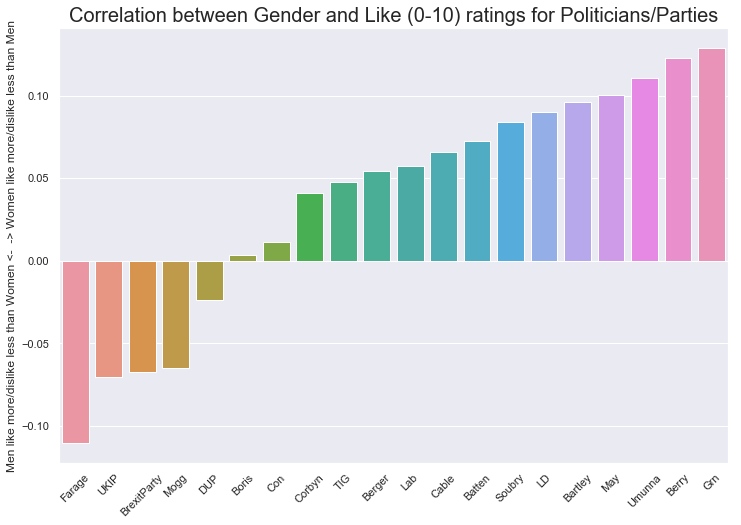

In [212]:

bar = BES_reduced_with_na[match( BES_reduced_with_na, "like").index].corrwith(BES_reduced_with_na["gender_Female"]).sort_values()
bar.index = [x.replace("__Strongly like","").replace("like","") for x in bar.index]
plt.figure(figsize=(12,8))
sns.barplot(x = bar.index,y=bar.values)
plt.xticks(rotation=45);
title ="Correlation between Gender and Like (0-10) ratings for Politicians/Parties"
plt.title(title, fontsize=20);
plt.ylabel("Men like more/dislike less than Women <-  -> Women like more/dislike less than Men");

fname = output_subfolder + clean_filename(title, char_limit = 20) + ".png"
plt.savefig( fname, bbox_inches='tight' )   

In [194]:
BES_reduced_with_na[search(BES_reduced_with_na,"passport" )].corrwith(BES_reduced_with_na["euRefVote_Leave the EU"])

Series([], dtype: float64)

In [220]:
match( BES_reduced_with_na, "like", mask = BES_reduced_with_na["gender_Female"].notnull()).sort_values()

likeBartley__Strongly like         3833
likeBerry__Strongly like           4267
likeBerger__Strongly like          9378
likeBatten__Strongly like          9571
likeSoubry__Strongly like         15949
likeUmunna__Strongly like         16766
likeBrexitParty__Strongly like    17457
likeTIG__Strongly like            17541
likeDUP__Strongly like            19454
likeCable__Strongly like          20893
likeMogg__Strongly like           21381
likeGrn__Strongly like            22878
likeLD__Strongly like             23625
likeUKIP__Strongly like           24114
likeFarage__Strongly like         24344
likeCon__Strongly like            24459
likeLab__Strongly like            24468
likeBoris__Strongly like          24482
likeCorbyn__Strongly like         24563
likeMay__Strongly like            24697
dtype: int64

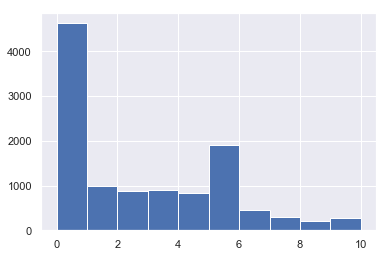

In [222]:
BES_reduced_with_na["likeBatten__Strongly like"].hist()

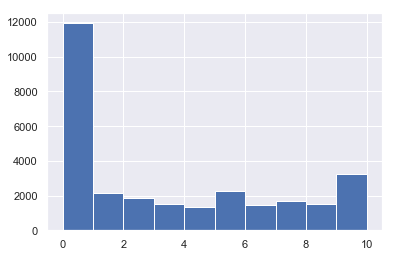

In [223]:
BES_reduced_with_na["likeFarage__Strongly like"].hist()

In [221]:
pattern = "likeBatten__Strongly like"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for likeBatten__Strongly like 
 
 
 r 
 p 
 N 
 
 
 likeDUP__Strongly like 
 0.53 
 0.00 
 10326 
 
 likeUKIP__Strongly like 
 0.51 
 0.00 
 11180 
 
 likeBrexitParty__Strongly like 
 0.49 
 0.00 
 9726 
 
 likeMogg__Strongly like 
 0.49 
 0.00 
 10723 
 
 likeBoris__Strongly like 
 0.47 
 0.00 
 11270 
 
 likeFarage__Strongly like 
 0.45 
 0.00 
 11255 
 
 ptvUKIP__Very likely 
 0.43 
 0.00 
 10904 
 
 ptvBrexitParty__Very likely 
 0.41 
 0.00 
 10143 
 
 socialDistUKIP__Very happy 
 0.39 
 0.00 
 2355 
 
 approveUKGovt__Strongly approve 
 0.38 
 0.00 
 1827 
 
 likeBartley__Strongly like 
 0.37 
 0.00 
 4247 
 
 immigbrexit__Allow many more 
 0.37 
 0.00 
 8755 
 
 immigCon__Allow many more 
 0.36 
 0.00 
 9837 
 
 euPriorityBalance__Control immigration 
 0.36 
 0.00 
 10619 
 
 euLeaveVoice__Much higher 
 0.35 
 0.00 
 10947 
 
 effectsEUWorkers__Much better 
 0.35 
 0.00 
 10928 
 
 likeMay__Strongly like 
 0.35 
 0.00 
 11353 
 
 conLookAfterMuslims__Very closely 
 0.35 
 0.00 
 1950 
 
 noDealShortTerm__Extremely good 
 0.34 
 0.00 
 10646 
 
 leftRight__Right 
 0.34 
 0.00 
 9989 
 
 
 Top 20 negative (spearman) correlations for likeBatten__Strongly like 
 
 
 r 
 p 
 N 
 
 
 lrUKIP__Right 
 -0.38 
 0.00 
 9555 
 
 redistUKIP__Government should be less concerned[...] 
 -0.34 
 0.00 
 7981 
 
 noDealEmotions_1_Yes 
 -0.33 
 0.00 
 2435 
 
 euLeaveBigBusiness__Much more likely 
 -0.3 
 0.00 
 10602 
 
 achieveReduceImmigNone_Yes 
 -0.3 
 0.00 
 9010 
 
 leaveImpactBritain__A very large impact 
 -0.29 
 0.00 
 10828 
 
 immigEcon__Good for economy 
 -0.28 
 0.00 
 10986 
 
 noDealEmotions_7_Yes 
 -0.28 
 0.00 
 2435 
 
 noDealEmotions_3_Yes 
 -0.27 
 0.00 
 2435 
 
 lrCon__Right 
 -0.27 
 0.00 
 9789 
 
 remainVnodeal_Remain in the EU 
 -0.27 
 0.00 
 10318 
 
 euLeaveScotIndep__Much more likely 
 -0.27 
 0.00 
 9909 
 
 redistCon__Government should be less concerned[...] 
 -0.27 
 0.00 
 9321 
 
 immigCultural__Enriches cultural life 
 -0.26 
 0.00 
 10985 
 
 effectsEUUnemployment__Much higher 
 -0.26 
 0.00 
 10809 
 
 dealPriorityMarketAccess__Extremely important 
 -0.25 
 0.00 
 10856 
 
 socialDistRemain__Very happy 
 -0.25 
 0.00 
 2348 
 
 dealVremain_Remain in the EU 
 -0.25 
 0.00 
 8767 
 
 echr__Strongly agree 
 -0.25 
 0.00 
 10869 
 
 immigSelf__Allow many more 
 -0.25 
 0.00 
 10723

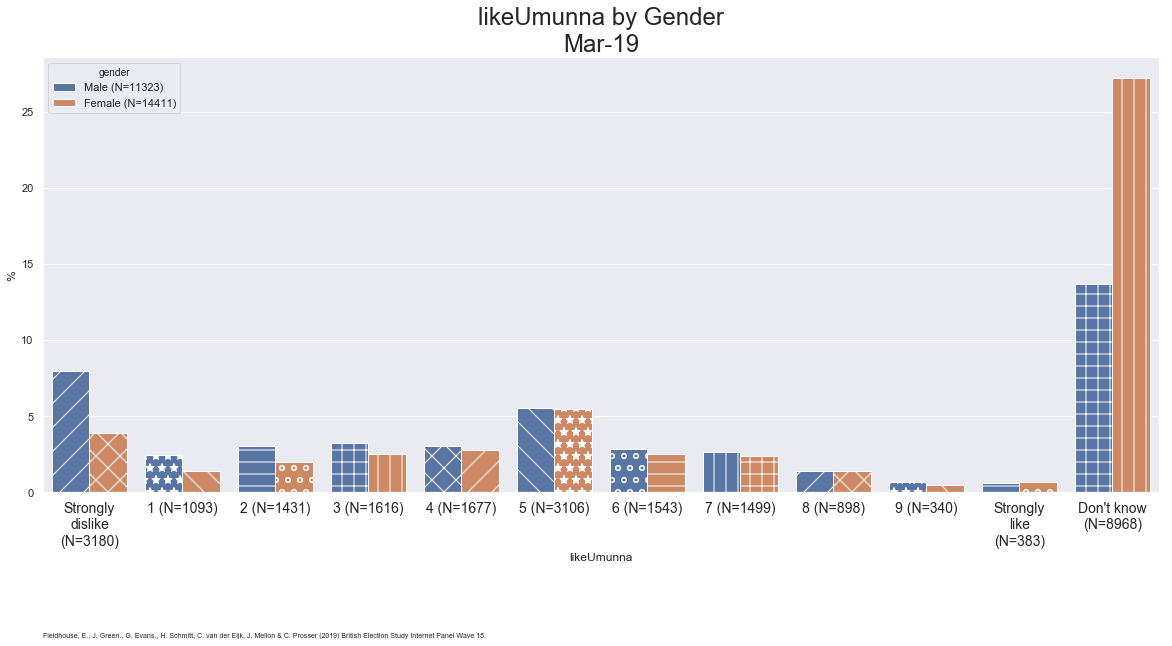

In [228]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var2 ="likeUmunna"
var1 ="gender"


# df2 = govtHandouts
df2 = BES_Panel[var2]#.replace("Don't know",np.nan).cat.remove_unused_categories()
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]#.replace("Don't know",np.nan).cat.remove_unused_categories()
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              title="likeUmunna by Gender"+"\n"+date)
              
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [195]:
search(BES_reduced_with_na,"passport" )

Series([], dtype: float64)

In [213]:
pattern = "gender_Female"
name = pattern
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

Top 20 positive (spearman) correlations for gender_Female 
 
 
 r 
 p 
 N 
 
 
 subjectHE_Humanities, social sciences, psychology[...] 
 0.28 
 0.00 
 5226 
 
 al4W14__Strongly agree 
 0.21 
 0.00 
 29533 
 
 efficacyNotUnderstand__Strongly agree 
 0.2 
 0.00 
 24928 
 
 personality_agreeableness 
 0.18 
 0.00 
 51245 
 
 warmMuslim__Very warm 
 0.18 
 0.00 
 5086 
 
 warmJewish__Very warm 
 0.16 
 0.00 
 5081 
 
 workingStatus_Working part time (8-29 hours a[...] 
 0.16 
 0.00 
 15342 
 
 personality_neuroticism 
 0.15 
 0.00 
 51243 
 
 lrgreens__Right 
 0.14 
 0.00 
 16862 
 
 pcGoneMad__Need to change the way people talk 
 0.14 
 0.00 
 5324 
 
 EUIntegrationLD__Protect our independence 
 0.14 
 0.00 
 16955 
 
 knowf2f6_True 
 0.14 
 0.00 
 18820 
 
 likeBerry__Strongly like 
 0.13 
 0.00 
 4267 
 
 EUIntegrationGreen__Protect our independence 
 0.13 
 0.00 
 14272 
 
 achieveReduceImmigBrexit_Yes 
 0.13 
 0.00 
 25734 
 
 likeGrn__Strongly like 
 0.13 
 0.00 
 22878 
 
 competentMay__A great deal of competence 
 0.12 
 0.00 
 5184 
 
 EUIntegrationTIG__Protect our independence 
 0.12 
 0.00 
 12562 
 
 integrityMay__Complete integrity 
 0.12 
 0.00 
 4985 
 
 impReligion__Extremely important 
 0.11 
 0.00 
 24485 
 
 
 Top 20 negative (spearman) correlations for gender_Female 
 
 
 r 
 p 
 N 
 
 
 subjectHE_Engineering, Mathematics or Natural[...] 
 -0.27 
 0.00 
 5226 
 
 profile_gross_personal__£100,000 and over 
 -0.24 
 0.00 
 44395 
 
 efficacyUnderstand__Strongly agree 
 -0.23 
 0.00 
 24729 
 
 euKnow6_False 
 -0.21 
 0.00 
 18699 
 
 polAttention__Pay a great deal of attention 
 -0.21 
 0.00 
 25549 
 
 freeSpeechRacistElection__Definitely 
 -0.19 
 0.00 
 5204 
 
 noDealEmotions_2_Yes 
 -0.15 
 0.00 
 5346 
 
 freeSpeechMilitaryElection__Definitely 
 -0.15 
 0.00 
 5106 
 
 knowf2f2_True 
 -0.15 
 0.00 
 19754 
 
 workingStatus_Working full time (30 or more hours[...] 
 -0.15 
 0.00 
 15342 
 
 euKnow1_False 
 -0.15 
 0.00 
 14473 
 
 immigGreen__Allow many more 
 -0.15 
 0.00 
 14397 
 
 changeNHS__Getting a lot better 
 -0.15 
 0.00 
 24403 
 
 freeSpeechRacistTV__Definitely 
 -0.15 
 0.00 
 5190 
 
 freeSpeechRacistSpeech__Definitely 
 -0.14 
 0.00 
 5181 
 
 freeSpeechIslamistElection__Definitely 
 -0.14 
 0.00 
 5269 
 
 immigLD__Allow many more 
 -0.14 
 0.00 
 16624 
 
 noDealResults_6_Yes 
 -0.14 
 0.00 
 6127 
 
 noDealResults_4_Yes 
 -0.13 
 0.00 
 6127 
 
 freeSpeechMilitaryTV__Definitely 
 -0.13 
 0.00 
 5110

In [ ]:
# shortTermNoDeal, longTermNoDeal
# noDealResults_1...._6
# noDealEmotions_1..._10

In [243]:
BES_Panel["noDealEmotions_10"].value_counts()

No            5571
Yes            836
Don't know     512
Name: noDealEmotions_10, dtype: int64

In [248]:
# BES_reduced_with_na["noDealEmotions_8_Yes"]

In [283]:
search(BES_Panel,"noDeal").index

Index(['dealVnodeal', 'remainVnodeal', 'noDealShortTerm', 'noDealLongTerm',
       'delayOrNoDeal', 'noDealEmotions_1', 'noDealEmotions_2',
       'noDealEmotions_3', 'noDealEmotions_4', 'noDealEmotions_5',
       'noDealEmotions_6', 'noDealEmotions_7', 'noDealEmotions_8',
       'noDealEmotions_9', 'noDealEmotions_10', 'noDealResults_1',
       'noDealResults_2', 'noDealResults_3', 'noDealResults_4',
       'noDealResults_5', 'noDealResults_6', 'noDealResults_111'],
      dtype='object')

In [234]:
search(BES_reduced_with_na,"noDealEmotions_").index

Index(['noDealEmotions_1_Yes', 'noDealEmotions_2_Yes', 'noDealEmotions_3_Yes',
       'noDealEmotions_4_Yes', 'noDealEmotions_5_Yes', 'noDealEmotions_6_Yes',
       'noDealEmotions_7_Yes', 'noDealEmotions_9_Yes',
       'noDealEmotions_10_Yes'],
      dtype='object')

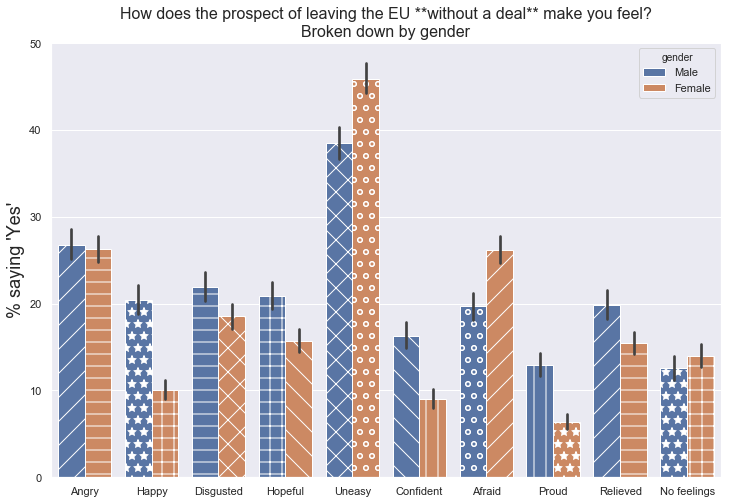

In [273]:
plt.figure(figsize = (12,8))

var_list = search(BES_Panel,"noDealEmotions_").index
df = BES_Panel[var_list]
df.index = BES_reduced_with_na["gender_Female"]
df = df.stack().reset_index()
ques = "How does the prospect of leaving the EU **without a deal** make you feel?"
hue = "gender"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].astype('category').cat.rename_categories(['Male','Female'])
df["values"] = df["values"].replace("No",0).replace("Yes",1).replace("Don't know",np.nan).astype('float32')

# df[ques] = df[ques].apply(lambda x: x.replace("__Much too low","").replace("tax",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

bar = sns.barplot(y = df["values"]*100,
               x = df[ques],
               hue = df[hue])#,
#                order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
# plt.xticks(rotation = 45);
# 
plt.xticks([0,1,2,3,4,5,6,7,8,9],["Angry","Happy","Disgusted","Hopeful","Uneasy","Confident","Afraid","Proud","Relieved","No feelings"]);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
# plt.yticks([0,1,2,3,4],['Much too high', 'Too high', 'About right', 'Too low', 'Much too low']);
plt.ylabel("% saying 'Yes'",fontsize=18);
plt.xlabel("")
plt.title(ques+"\nBroken down by gender",fontsize=16)
# plt.axhline(.5, linestyle=':');
# plt.title("Unicorn Shooting Gallery",fontsize=40);

hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(next(hatch_cycle))


output_folder = create_subdir(BES_output_folder, "nodeal_by_gender")
fname = output_folder + "nodealemotions_by_gender" + ".png"
plt.savefig( fname, bbox_inches='tight' )   

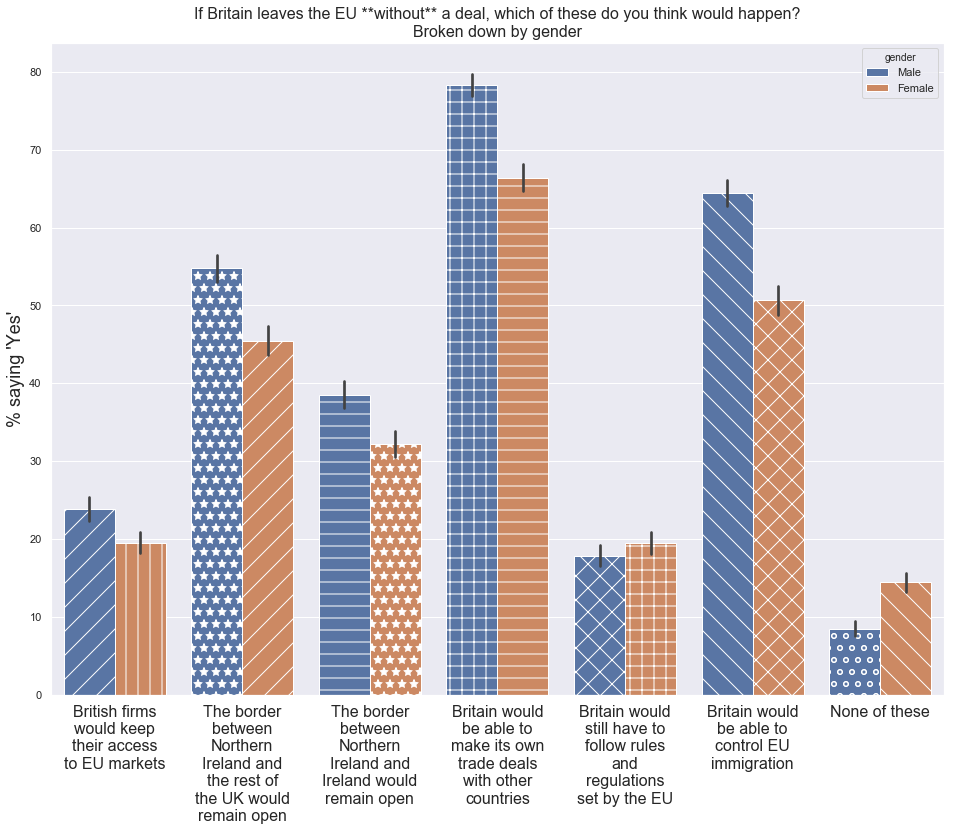

In [282]:
plt.figure(figsize = (16,12))

var_list = search(BES_Panel,"noDealResults_").index
df = BES_Panel[var_list]
df.index = BES_reduced_with_na["gender_Female"]
df = df.stack().reset_index()
ques = "If Britain leaves the EU **without** a deal, which of these do you think would happen?"
hue = "gender"
df.columns = [hue,
              ques,
              "values"]
df[hue] = df[hue].astype('category').cat.rename_categories(['Male','Female'])
df["values"] = df["values"].replace("No",0).replace("Yes",1).replace("Don't know",np.nan).astype('float32')

# df[ques] = df[ques].apply(lambda x: x.replace("__Much too low","").replace("tax",""))
# df = BES_reduced_with_na[var_list].stack().reset_index()

bar = sns.barplot(y = df["values"]*100,
               x = df[ques],
               hue = df[hue])#,
#                order = df.groupby(ques).mean().sort_values(by="values",ascending=False).index)#, split=True, cut=0, bw=.5 )
# plt.xticks(rotation = 45);
# 

import textwrap 
wrapper = textwrap.TextWrapper(width=14)

# ax.set_xticklabels([ wrapper.fill(text=x) for x in labels_restricted], rotation=0, fontsize=text_fontsize);

plt.xticks([0,1,2,3,4,5,6],[wrapper.fill(text=x) for x in ["British firms would keep their access to EU markets",
                            "The border between Northern Ireland and the rest of the UK would remain open",
                            "The border between Northern Ireland and Ireland would remain open",
                            "Britain would be able to make its own trade deals with other countries",
                            "Britain would still have to follow rules and regulations set by the EU",
                            "Britain would be able to control EU immigration",
                            "None of these"]], rotation=0, fontsize=16);
# plt.gca().set_yticklabels(["Not important at all","Not very important","Somewhat important","Very important","Extremely important"]);
# plt.yticks([0,1,2,3,4],['Much too high', 'Too high', 'About right', 'Too low', 'Much too low']);
plt.ylabel("% saying 'Yes'",fontsize=18);
plt.xlabel("")
plt.title(ques+"\nBroken down by gender",fontsize=16)
# plt.axhline(.5, linestyle=':');
# plt.title("Unicorn Shooting Gallery",fontsize=40);

hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(next(hatch_cycle))


output_folder = create_subdir(BES_output_folder, "nodeal_by_gender")
fname = output_folder + "nodealresults_by_gender" + ".png"
plt.savefig( fname, bbox_inches='tight' )   

Warning, filename truncated because it was over 40. Filenames may no longer be unique


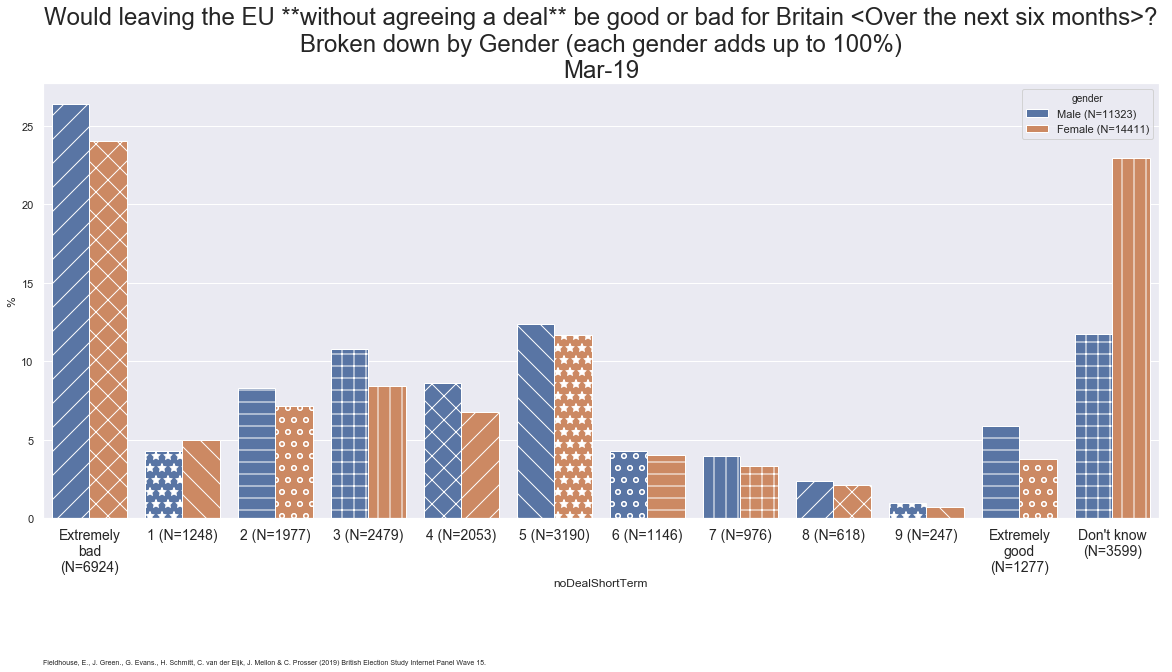

In [288]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var2 ="noDealShortTerm"
var1 ="gender"


# df2 = govtHandouts
df2 = BES_Panel[var2]#.replace("Don't know",np.nan).cat.remove_unused_categories()
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]#.replace("Don't know",np.nan).cat.remove_unused_categories()
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              title="Would leaving the EU **without agreeing a deal** be good or bad for Britain <Over the next six months>?\nBroken down by Gender (each gender adds up to 100%)"+"\n"+date)
              
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

Warning, filename truncated because it was over 40. Filenames may no longer be unique


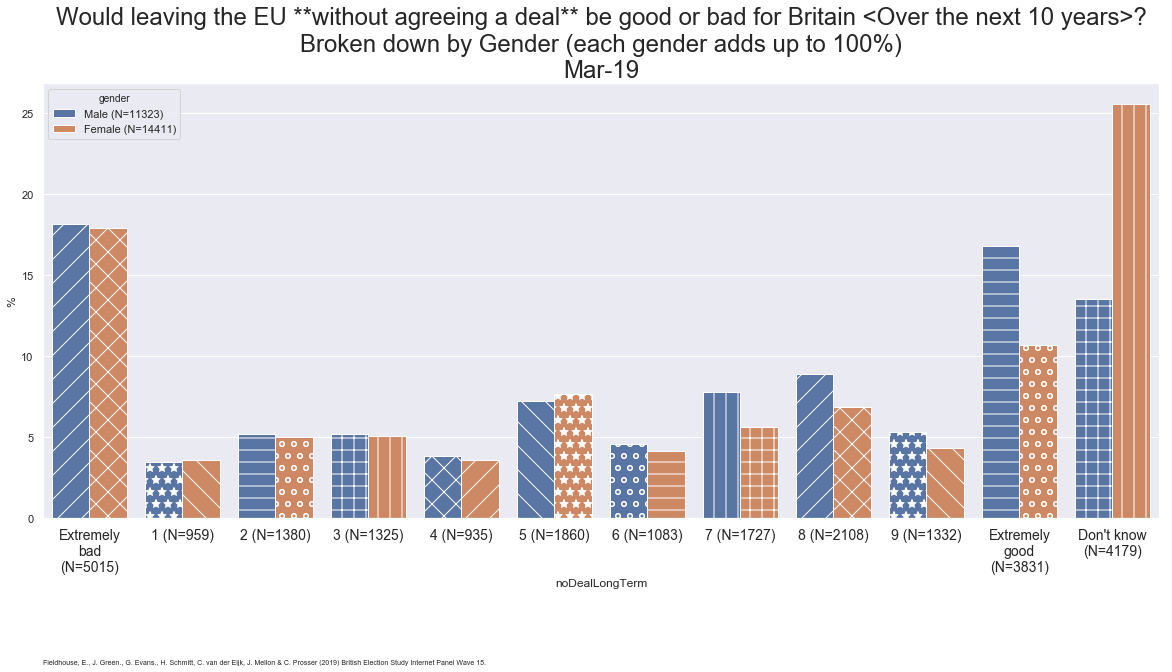

In [289]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
# mask = BES_Panel["euRefVote"]=="Leave the EU"

wave = 15

var2 ="noDealLongTerm"
var1 ="gender"


# df2 = govtHandouts
df2 = BES_Panel[var2]#.replace("Don't know",np.nan).cat.remove_unused_categories()
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]#.replace("Don't know",np.nan).cat.remove_unused_categories()
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='index',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              title="Would leaving the EU **without agreeing a deal** be good or bad for Britain <Over the next 10 years>?\nBroken down by Gender (each gender adds up to 100%)"+"\n"+date)
              
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [ ]:
############################################

In [19]:
search(BES_Panel,"euID")

euIDW7              7682
euID1W7             6526
euID2W7             6526
euID3W7             6526
euID4W7             6526
euID5W7             6526
euID6W7             6526
euID7W7             6526
euIDW8              6106
euID1W8             5329
euID2W8             5329
euID3W8             5329
euID4W8             5329
euID5W8             5329
euID6W8             5329
euID7W8             5329
euIDW9             30036
euID1W9            27922
euID2W9            27922
euID3W9            27922
euID4W9            27922
euID5W9            27922
euID6W9            27922
euID7W9            27922
euIDW10            30237
euID1W10           27042
euID2W10           27042
euID3W10           27042
euID4W10           27042
euID6W10           27042
                   ...  
euID7W11           28023
euIDW12             8550
euID1W12            7841
euID2W12            7841
euID3W12            7841
euID4W12            7841
euID6W12            7841
euID7W12            7841
euIDW13            31136


In [20]:
search(BES_Panel,"partyID")

partyIdStrengthW1        26120
partyIdW1                30309
partyIdSqueezeW1          7267
partyIdStrengthW2        26389
partyIdW2                30227
partyIdSqueezeW2          5914
partyIdStrengthW3        24206
partyIdW3                27819
partyIdSqueezeW3          6347
partyIdStrengthW4        27428
partyIdW4                31441
partyIdSqueezeW4          7099
partyIdW6                30151
partyIdStrengthW6        27002
partyIdSqueezeW6          5784
partyIdStrengthW7        26870
partyIdW7                30895
partyIdSqueezeW7          6936
partyIdEUW7              26870
partyIdStrengthW8        29226
partyIdW8                33502
partyIdSqueezeW8          7255
partyIdEUW8              29226
partyIdStrengthW9        25962
partyIdW9                30036
partyIdSqueezeW9          6729
partyIdEUretroW9         25962
partyIdStrengthW10       25169
partyIdW10               30237
partyIdSqueezeW10         7879
partyIdStrengthW11       26261
partyIdW11               30956
partyIdS

In [25]:
search(BES_Panel,"partyIDStrength(?=W)|euIDStrength")

partyIdStrengthW1     26120
partyIdStrengthW2     26389
partyIdStrengthW3     24206
partyIdStrengthW4     27428
partyIdStrengthW6     27002
partyIdStrengthW7     26870
partyIdStrengthW8     29226
partyIdStrengthW9     25962
partyIdStrengthW10    25169
partyIdStrengthW11    26261
partyIdStrengthW12    29164
partyIdStrengthW13    26710
partyIdStrengthW14    26130
partyIdStrengthW15    25311
euIDStrengthW15       27192
dtype: int64

In [30]:
partyIdStrength  = amalgamate_waves(BES_Panel.replace("Don't know",np.nan),"partyIdStrength(?=W)")

Amalgamating variables: 
{1: 'partyIdStrengthW1', 2: 'partyIdStrengthW2', 3: 'partyIdStrengthW3', 4: 'partyIdStrengthW4', 6: 'partyIdStrengthW6', 7: 'partyIdStrengthW7', 8: 'partyIdStrengthW8', 9: 'partyIdStrengthW9', 10: 'partyIdStrengthW10', 11: 'partyIdStrengthW11', 12: 'partyIdStrengthW12', 13: 'partyIdStrengthW13', 14: 'partyIdStrengthW14', 15: 'partyIdStrengthW15'} ['partyIdStrengthW1', 'partyIdStrengthW2', 'partyIdStrengthW3', 'partyIdStrengthW4', 'partyIdStrengthW6', 'partyIdStrengthW7', 'partyIdStrengthW8', 'partyIdStrengthW9', 'partyIdStrengthW10', 'partyIdStrengthW11', 'partyIdStrengthW12', 'partyIdStrengthW13', 'partyIdStrengthW14', 'partyIdStrengthW15']


In [29]:
BES_Panel[search(BES_Panel,"partyIDStrength(?=W)").index].stack().value_counts()

Fairly strong      182364
Not very strong    105205
Very strong         76916
Don't know           7463
dtype: int64

In [33]:
partyIdStrength.cat.codes.value_counts()

 1    34219
 2    23857
-1    21302
 0    13209
dtype: int64

In [27]:
partyIdStrength.notnull().sum()

71285

In [40]:
euIDStrengthW15 = BES_Panel["euIDStrengthW15"].cat.reorder_categories(["Don't know", 'Not very strong', 'Fairly strong', 'Very strong' ]).cat.codes.replace(-1, np.nan)
partyIDStrengthW15 = BES_Panel["partyIdStrengthW15"].cat.reorder_categories(["Don't know", 'Not very strong', 'Fairly strong', 'Very strong' ]).cat.codes.replace(-1, np.nan)

In [41]:
euIDStrengthW15.notnull().sum()

27192

In [42]:
partyIDStrengthW15.notnull().sum()

25311

In [54]:
partyIDStrengthW15.value_counts()

2.0    12205
1.0     8828
3.0     3637
0.0      641
dtype: int64

In [55]:
euIDStrengthW15.value_counts()

3.0    14676
2.0     9374
1.0     2443
0.0      699
dtype: int64

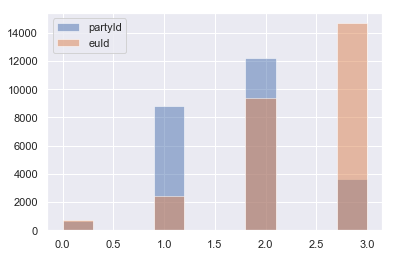

In [47]:
partyIDStrengthW15.hist(label='partyId',alpha=.5);
euIDStrengthW15.hist(label='euId',alpha=.5);
plt.legend();

In [56]:
euIDLead = euIDStrengthW15-partyIDStrengthW15

In [60]:
euIDLead.value_counts().sort_index()

-3.0      37
-2.0     259
-1.0    1459
 0.0    7819
 1.0    9942
 2.0    3625
 3.0     271
dtype: int64

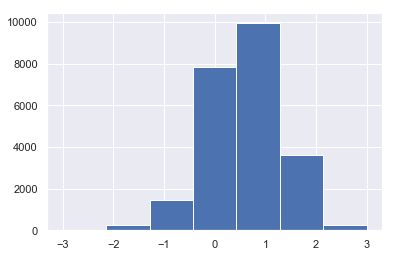

In [58]:
euIDLead.hist(bins=7);

In [50]:
euIDStrengthW15.value_counts()

3.0    14676
2.0     9374
1.0     2443
0.0      699
dtype: int64

In [52]:
partyIDStrengthW15[euIDStrengthW15==3.0].value_counts()

2.0    6679
1.0    3461
3.0    2674
0.0     271
dtype: int64

In [69]:
BES_Panel["profile_past_vote_2017"][euIDLead<=-1.0].value_counts()

Stay/remain in the EU    676
Leave the EU             572
Don't know                 7
Name: profile_eurefvote, dtype: int64

In [64]:
search(BES_Panel,"profile_past")

profile_past_vote_2005    53351
profile_past_vote_2010    63248
profile_past_vote_2017    37245
profile_past_vote_2015    60846
dtype: int64

In [75]:
euref2017GE_comb = BES_Panel[["profile_eurefvote","profile_past_vote_2017"]].apply(lambda x: x.fillna("").sum(),axis=1)

In [76]:
euref2017GE_comb.value_counts()

                                                                 40952
Leave the EUConservative                                         10081
Stay/remain in the EULabour                                       9302
Stay/remain in the EU                                             7792
Leave the EU                                                      6434
Stay/remain in the EUConservative                                 4175
Leave the EULabour                                                3939
Stay/remain in the EULiberal Democrat                             2559
Stay/remain in the EUScottish National Party (SNP)                1222
Labour                                                            1214
Leave the EUUnited Kingdom Independence Party (UKIP)               864
Leave the EULiberal Democrat                                       565
Stay/remain in the EUGreen Party                                   498
Conservative                                                       496
Leave 

In [77]:
euref2017GE_comb[euIDLead<=-1.0].value_counts()

                                                        432
Stay/remain in the EULabour                             273
Stay/remain in the EUConservative                       251
Leave the EUConservative                                239
Leave the EULabour                                      210
Stay/remain in the EU                                    78
Leave the EU                                             60
Labour                                                   37
Stay/remain in the EUScottish National Party (SNP)       36
Stay/remain in the EULiberal Democrat                    25
Leave the EUUnited Kingdom Independence Party (UKIP)     18
Conservative                                             17
Leave the EUScottish National Party (SNP)                16
Leave the EULiberal Democrat                             15
Leave the EUGreen Party                                   7
Stay/remain in the EUGreen Party                          7
Scottish National Party (SNP)           

In [84]:
euref2017GE_comb[euIDLead>=1.0].value_counts()

Leave the EUConservative                                         3201
                                                                 2796
Stay/remain in the EULabour                                      2440
Stay/remain in the EUConservative                                 986
Stay/remain in the EULiberal Democrat                             905
Leave the EULabour                                                877
Stay/remain in the EU                                             637
Leave the EU                                                      610
Leave the EUUnited Kingdom Independence Party (UKIP)              244
Stay/remain in the EUScottish National Party (SNP)                238
Labour                                                            161
Stay/remain in the EUGreen Party                                  145
Leave the EULiberal Democrat                                      139
Conservative                                                       77
Leave the EUOther   